In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from datetime import datetime
import pickle
import os
import json
import seaborn as sns
import math
import torch.nn.functional as F


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
class FeatureCorrelationModule(nn.Module):
    """
    A module that explicitly models feature correlations to better handle MNAR scenarios.
    """
    def __init__(self, num_features, d_model, dropout=0.1):
        super().__init__()
        self.correlation_proj = nn.Linear(d_model, d_model)
        self.feature_gate = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Sigmoid()
        )
        self.correlation_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Input features [batch_size, num_features, d_model]
            mask: Missing value mask [batch_size, num_features]
            
        Returns:
            Correlation-enhanced features
        """
        batch_size, num_features, d_model = x.size()
        
        # Project features for correlation computation
        x_proj = self.correlation_proj(x)
        
        # Compute pairwise feature correlations (scaled dot-product)
        corr_matrix = torch.bmm(x_proj, x_proj.transpose(1, 2)) / math.sqrt(d_model)
        
        # If we have a mask, adjust correlation for missing values
        if mask is not None:
            # Create attention mask (1 for observed values, 0 for missing)
            obs_mask = 1 - mask.float()
            mask_matrix = torch.bmm(obs_mask.unsqueeze(2), obs_mask.unsqueeze(1))
            
            # Apply mask to correlation matrix (masked positions get -1e9)
            masked_corr = corr_matrix.masked_fill(mask_matrix == 0, -1e9)
            
            # Softmax to get normalized correlation weights
            corr_weights = F.softmax(masked_corr, dim=-1)
        else:
            corr_weights = F.softmax(corr_matrix, dim=-1)
        
        # Apply correlation weights to propagate information across features
        corr_features = torch.bmm(corr_weights, x)
        
        # Compute feature-specific gates to control information flow
        gates = self.feature_gate(x)
        
        # Gate the correlation features and apply residual connection
        gated_corr = gates * corr_features
        enhanced_features = x + self.dropout(gated_corr)
        
        # Apply layer normalization
        enhanced_features = self.correlation_norm(enhanced_features)
        
        return enhanced_features


In [5]:
class FeatureValueDependentEncoder(nn.Module):
    """
    A module that explicitly models the relationship between feature values and missingness,
    which is crucial for MNAR scenarios.
    """
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        # Increase capacity of the value encoder with one more layer
        self.value_encoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),  # Add dropout for regularization
            nn.Linear(d_model, d_model),
            nn.GELU(),  # Add one more non-linearity
            nn.Linear(d_model, d_model),  # Add one more layer
            nn.LayerNorm(d_model)
        )
        
        # Enhance missingness encoder to better capture patterns
        self.missingness_encoder = nn.Sequential(
            nn.Linear(1, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),  # Add dropout for regularization
            nn.Linear(d_model // 2, d_model),
            nn.LayerNorm(d_model)
        )
        
        # Add attention mechanism for better fusion
        self.attention = nn.MultiheadAttention(d_model, num_heads=4, dropout=dropout)
        
        # Enhanced fusion layer
        self.fusion_layer = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model)
        )
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Input features [batch_size, num_features, d_model]
            mask: Missing value mask [batch_size, num_features]
            
        Returns:
            Features with enhanced MNAR understanding
        """
        # Encode feature values
        value_encoding = self.value_encoder(x)
        
        # If we have a mask, encode missingness patterns
        if mask is not None:
            # Encode missingness (expanded to match d_model dimension)
            mask_encoding = self.missingness_encoder(mask.float().unsqueeze(-1))
            
            # Apply attention between value encoding and mask encoding
            # Reshape for attention: [seq_len, batch_size, d_model]
            batch_size, num_features, d_model = value_encoding.size()
            v_enc = value_encoding.transpose(0, 1)
            m_enc = mask_encoding.transpose(0, 1)
            
            # Self-attention on value encodings with mask as query
            attn_output, _ = self.attention(m_enc, v_enc, v_enc)
            
            # Reshape back: [batch_size, seq_len, d_model]
            attn_output = attn_output.transpose(0, 1)
            
            # Combine with original mask encoding
            mask_encoding = mask_encoding + attn_output
            
            # Combine value and missingness encodings
            combined = torch.cat([value_encoding, mask_encoding], dim=-1)
            enhanced = self.fusion_layer(combined)
        else:
            # Without mask, just use value encoding
            enhanced = value_encoding
            
        return enhanced

In [6]:
class RelativePositionEncoding(nn.Module):
    """
    Learnable relative position encoding for features in the transformer model.
    This allows the model to understand relationships between features based on their positions.
    """
    def __init__(self, max_seq_len, d_model):
        super().__init__()
        self.rel_pos_embedding = nn.Parameter(torch.randn(2 * max_seq_len - 1, d_model))
        self.max_seq_len = max_seq_len
        
    def forward(self, x):
        """
        Apply relative positional encodings to the input.
        
        Args:
            x: Input tensor [batch_size, seq_len, d_model]
            
        Returns:
            Tensor with relative positional information.
        """
        seq_len = x.size(1)
        pos_indices = torch.arange(seq_len, device=x.device)
        rel_pos_indices = pos_indices.unsqueeze(1) - pos_indices.unsqueeze(0) + self.max_seq_len - 1
        rel_pos_encoded = self.rel_pos_embedding[rel_pos_indices]
        
        return rel_pos_encoded

In [7]:
class MultiHeadAttentionWithRelPos(nn.Module):
    """
    Multi-head attention with relative positional encoding.
    """
    def __init__(self, d_model, num_heads, dropout=0.1, max_seq_len=1000):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        
        self.rel_pos_encoding = RelativePositionEncoding(max_seq_len, d_model)
        
        self.rel_pos_proj = nn.Linear(d_model, d_model)

        self.scale = self.head_dim ** -0.5
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, key_padding_mask=None, need_weights=False):
        """
        Forward pass with relative positional encoding.
        
        Args:
            query, key, value: Input tensors [batch_size, seq_len, d_model]
            key_padding_mask: Mask for padded values [batch_size, seq_len]
            need_weights: Whether to return attention weights
            
        Returns:
            Output tensor and optionally attention weights
        """
        batch_size = query.size(0)
        seq_len = query.size(1)
        
        #Linear projections and reshape for multi-head attention
        q = self.q_proj(query).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        #content-based attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # [batch, heads, seq_len, seq_len]
        
        rel_bias = torch.zeros((seq_len, seq_len), device=query.device)
        positions = torch.arange(seq_len, device=query.device)
        relative_positions = positions.unsqueeze(1) - positions.unsqueeze(0)

        rel_bias = -torch.abs(relative_positions) * 0.1

        attn_scores = attn_scores + rel_bias.unsqueeze(0).unsqueeze(0)

        if key_padding_mask is not None:
            attn_mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
            attn_scores = attn_scores.masked_fill(attn_mask, float('-inf'))

        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        output = torch.matmul(attn_weights, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

        output = self.out_proj(output)
        
        if need_weights:
            return output, attn_weights
        else:
            return output


In [8]:
class RelativePositionTransformerLayer(nn.Module):
    """
    Transformer encoder layer with relative positional encoding.
    """
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, 
                 activation="gelu", max_seq_len=1000, norm_first=True):
        super().__init__()

        self.self_attn = MultiHeadAttentionWithRelPos(
            d_model, nhead, dropout=dropout, max_seq_len=max_seq_len
        )

        #FFN
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        #Activation
        self.activation = getattr(nn.functional, activation)
        self.norm_first = norm_first
        
    def forward(self, src, src_key_padding_mask=None):
        """
        Forward pass of the transformer layer.
        
        Args:
            src: Input tensor [batch_size, seq_len, d_model]
            src_key_padding_mask: Mask for padded values [batch_size, seq_len]
            
        Returns:
            Processed tensor
        """
        # Pre-norm architecture
        if self.norm_first:
            src2 = self.norm1(src)
            src2 = self.self_attn(src2, src2, src2, key_padding_mask=src_key_padding_mask)
            src = src + self.dropout1(src2)
            
            src2 = self.norm2(src)
            src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
            src = src + self.dropout2(src2)
        else:
            # Multi-head attention block with post-normalization
            src2 = self.self_attn(src, src, src, key_padding_mask=src_key_padding_mask)
            src = self.norm1(src + self.dropout1(src2))
            
            # Feedforward block with post-normalization
            src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
            src = self.norm2(src + self.dropout2(src2))
            
        return src

In [9]:
class RelativePositionTransformerEncoder(nn.Module):
    """
    Transformer encoder with relative positional encoding.
    """
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])
        self.num_layers = num_layers
        
    def forward(self, src, mask=None):
        """
        Forward pass of the transformer encoder.
        
        Args:
            src: Input tensor [batch_size, seq_len, d_model]
            mask: Mask for padded values [batch_size, seq_len]
            
        Returns:
            Encoded tensor
        """
        output = src
        for layer in self.layers:
            output = layer(output, src_key_padding_mask=mask)
        return output

In [10]:
class TabularTransformerWithRelPos(nn.Module):
    """
    Enhanced transformer model for tabular data imputation with improved
    MNAR handling through correlation modeling.
    """
    def __init__(self, 
                 num_features, 
                 d_model=128, 
                 nhead=8, 
                 num_layers=3, 
                 dim_feedforward=512, 
                 dropout=0.1, 
                 activation='gelu',
                 max_seq_len=1000):
        super().__init__()
        
        self.d_model = d_model
        self.num_features = num_features
        
        # Feature value embedding
        self.value_embedding = nn.Sequential(
            nn.Linear(1, d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout * 0.5),
            nn.GELU(),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model)
        )
        
        # Column embedding (learnable)
        self.column_embedding = nn.Embedding(num_features, d_model)
        
        # Missing value embedding
        self.missing_embedding = nn.Parameter(torch.randn(1, d_model))
        
        # Feature correlation module to model dependencies between features
        self.feature_correlation = FeatureCorrelationModule(num_features, d_model, dropout)
        
        # Feature-value dependent encoder for MNAR awareness
        self.feature_value_encoder = FeatureValueDependentEncoder(d_model, dropout)
        
        # Layer normalization before transformer
        self.norm = nn.LayerNorm(d_model)
        
        # Create transformer encoder layers
        encoder_layer = RelativePositionTransformerLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            max_seq_len=max_seq_len,
            norm_first=True
        )
        
        # Create transformer encoder
        self.transformer_encoder = RelativePositionTransformerEncoder(encoder_layer, num_layers)

        # Output projection
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, 1)
        )
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights using Kaiming initialization for better convergence"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                
    def _generate_attention_mask(self, mask):
        """Generate attention mask for transformer"""
        if mask is None:
            return None
        attn_mask = mask.bool()
        return attn_mask
                
    def forward(self, x, column_indices, mask=None):
        """
        Forward pass with enhanced correlation modeling for MNAR patterns.
        
        Args:
            x: Input tensor [batch_size, num_features]
            column_indices: Tensor of column indices [num_features]
            mask: Optional mask for missing values [batch_size, num_features]
            
        Returns:
            Tensor of predicted values [batch_size, num_features]
        """
        batch_size = x.size(0)
        
        # Reshape to [batch_size, num_features, 1] for embedding
        x = x.unsqueeze(-1)
        
        # Embed feature values
        x_embedded = self.value_embedding(x)
        
        # Add column embeddings
        col_embed = self.column_embedding(column_indices).unsqueeze(0).expand(batch_size, -1, -1)
        x_embedded = x_embedded + col_embed
        
        # Apply special handling for missing values
        if mask is not None:
            # Expand mask for broadcasting
            mask_expanded = mask.unsqueeze(-1).expand_as(x_embedded)
            # Replace embeddings for missing values with learned missing embedding
            missing_embed = self.missing_embedding.expand_as(x_embedded)
            x_embedded = torch.where(mask_expanded == 1, missing_embed, x_embedded)
        
        # Enhanced feature correlation modeling - key for MNAR patterns
        x_correlated = self.feature_correlation(x_embedded, mask)
        
        # Feature-value dependent encoding - explicitly models relationship 
        # between values and missingness
        x_value_aware = self.feature_value_encoder(x_correlated, mask)
        
        # Apply layer normalization
        x_embedded = self.norm(x_value_aware)
        
        # Apply transformer encoder
        attn_mask = self._generate_attention_mask(mask) if mask is not None else None
        x_encoded = self.transformer_encoder(x_embedded, attn_mask)
        
        # Project to output
        output = self.output_projection(x_encoded).squeeze(-1)
        
        return output

In [11]:
class EnsembleModel(nn.Module):
    """
    Ensemble of transformer models for improved prediction.
    """
    def __init__(self, num_features, config, num_models=3):
        super().__init__()
        self.num_models = num_models
        
        # Create multiple base models
        self.models = nn.ModuleList([
            TabularTransformerWithRelPos(
                num_features=num_features,
                d_model=config["d_model"],
                nhead=config["num_heads"],
                num_layers=config["num_layers"],
                dim_feedforward=config["dim_feedforward"],
                dropout=config["dropout"],
                activation=config["activation"],
                max_seq_len=max(2 * num_features, 100)
            ) for _ in range(num_models)
        ])
        
    def forward(self, x, column_indices, mask=None):
        # Get predictions from all models
        all_preds = []
        for model in self.models:
            preds = model(x, column_indices, mask)
            all_preds.append(preds.unsqueeze(0))
        
        # Stack and average predictions
        all_preds = torch.cat(all_preds, dim=0)
        avg_preds = torch.mean(all_preds, dim=0)
        
        return avg_preds

In [12]:
def create_missing_mask(data, missing_fraction=0.2, mechanism="MCAR"):
    """
    Create a mask for missing values using different mechanisms.
    
    Args:
        data (torch.Tensor): Input data tensor
        missing_fraction (float): Fraction of values to mask
        mechanism (str): One of "MCAR", "MAR", or "MNAR"
        
    Returns:
        torch.Tensor: Binary mask (1 = missing, 0 = present)
    """
    try:
        # MCAR implementation - completely random
        if mechanism == "MCAR":
            mask = torch.rand(data.shape, device=data.device) < missing_fraction
            return mask.int()
        
        # Simulated MAR (missing at random) implementation
        # In MAR, missingness depends on observed values but not on missing values
        elif mechanism == "MAR":
            # Create a base random mask
            mask = torch.zeros(data.shape, device=data.device, dtype=torch.int)
            
            # Number of features
            num_features = data.shape[1]
            
            # For each column, make missingness depend on values in other columns
            for col_idx in range(num_features):
                # Choose a different column as predictor (wrapping around if needed)
                predictor_col = (col_idx + 1) % num_features
                
                # Get predictor values
                predictor_values = data[:, predictor_col]
                
                # Normalize predictor values to [0, 1] range
                if predictor_values.max() > predictor_values.min():
                    normalized_values = (predictor_values - predictor_values.min()) / (predictor_values.max() - predictor_values.min())
                else:
                    normalized_values = torch.zeros_like(predictor_values)
                
                # Higher predictor values = higher chance of missingness
                # Add randomness to avoid making it purely deterministic
                prob = normalized_values * 0.5 + torch.rand(data.shape[0], device=data.device) * 0.5
                mask[:, col_idx] = (prob > (1 - missing_fraction)).int()
            
            return mask
        
        # Simulated MNAR (missing not at random) implementation
        # In MNAR, missingness depends on the missing values themselves
        elif mechanism == "MNAR":
            # Create a base random mask
            mask = torch.zeros(data.shape, device=data.device, dtype=torch.int)
            
            # For each column, make missingness depend on its own values
            for col_idx in range(data.shape[1]):
                # Get column values
                col_values = data[:, col_idx]
                
                # Normalize values to [0, 1] range
                if col_values.max() > col_values.min():
                    normalized_values = (col_values - col_values.min()) / (col_values.max() - col_values.min())
                else:
                    normalized_values = torch.zeros_like(col_values)
                
                # For MNAR, higher values have higher probability of being missing
                # Add randomness to avoid making it purely deterministic
                prob = normalized_values * 0.7 + torch.rand(data.shape[0], device=data.device) * 0.3
                mask[:, col_idx] = (prob > (1 - missing_fraction)).int()
            
            return mask
        
        # Default to MCAR if unknown mechanism
        else:
            print(f"Unknown missing data mechanism: {mechanism}. Defaulting to MCAR.")
            return create_missing_mask(data, missing_fraction, "MCAR")
            
    except Exception as e:
        print(f"Error creating {mechanism} mask: {e}")
        # Fall back to MCAR if there's an error
        return create_missing_mask(data, missing_fraction, "MCAR")

In [13]:
def load_and_prepare_data(data_path, test_size=0.2, val_size=0.1, random_state=SEED):
    """
    Load and prepare data for model training.
    
    Args:
        data_path (str): Path to the CSV file
        test_size (float): Proportion of data to use for testing
        val_size (float): Proportion of training data to use for validation
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: Preprocessed train, validation, test tensors, scaler, and column indices
    """
    print(f"Loading data from {data_path}")
    df = pd.read_csv(data_path, index_col=None)
    
    # Check for missing values
    missing_count = df.isna().sum().sum()
    if missing_count > 0:
        print(f"Warning: Dataset contains {missing_count} missing values. These will be handled in preprocessing.")
        # Simple imputation for missing values
        df = df.fillna(df.mean())
    
    # Convert to numpy for preprocessing
    data = df.to_numpy()
    
    # Split data into train and test
    train_val_data, test_data = train_test_split(
        data, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Split train_val into train and validation
    val_ratio = val_size / (1 - test_size)
    train_data, val_data = train_test_split(
        train_val_data,
        test_size=val_ratio,
        random_state=random_state
    )
    
    # Normalize data
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    val_data_scaled = scaler.transform(val_data)
    test_data_scaled = scaler.transform(test_data)
    
    # Convert to PyTorch tensors
    train_tensor = torch.tensor(train_data_scaled, dtype=torch.float32).to(device)
    val_tensor = torch.tensor(val_data_scaled, dtype=torch.float32).to(device)
    test_tensor = torch.tensor(test_data_scaled, dtype=torch.float32).to(device)
    
    # Create column indices
    column_indices = torch.arange(train_tensor.shape[1]).to(device)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Number of training samples: {train_tensor.shape[0]}")
    print(f"Number of validation samples: {val_tensor.shape[0]}")
    print(f"Number of test samples: {test_tensor.shape[0]}")
    print(f"Number of features: {train_tensor.shape[1]}")
    
    return train_tensor, val_tensor, test_tensor, scaler, column_indices

In [14]:
def compute_mnar_weighted_loss(predictions, ground_truth, mask, mechanism=None):
    """
    Compute loss with sophisticated weighting for MNAR scenarios based on
    feature correlations and value magnitudes.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        mechanism (str): Missing data mechanism (MCAR, MAR, MNAR)
        
    Returns:
        torch.Tensor: Weighted loss
    """
    batch_size, num_features = ground_truth.shape
    mse_loss = nn.MSELoss(reduction='none')
    element_loss = mse_loss(predictions, ground_truth)
    
    # Base mechanism-specific weighting
    if mechanism == "MNAR":
        base_weight = 2.0
    elif mechanism == "MAR":
        base_weight = 1.2
    else:  # MCAR
        base_weight = 1.0
    
    if mechanism == "MNAR":
        # For MNAR, compute correlation-based weights
        # First, get observed feature values
        observed_mask = 1 - mask
        
        # Calculate feature statistics where observed
        # For each feature, compute mean of observed values
        feature_means = torch.zeros_like(ground_truth)
        for i in range(num_features):
            feat_observed = ground_truth[:, i] * observed_mask[:, i]
            feat_count = observed_mask[:, i].sum() + 1e-8
            feat_mean = feat_observed.sum() / feat_count
            feature_means[:, i] = feat_mean
        
        # Calculate absolute deviation from feature mean
        abs_deviation = torch.abs(ground_truth - feature_means)
        
        # Normalize deviations to [0, 1] range for each feature
        max_devs = abs_deviation.max(dim=0, keepdim=True)[0]
        min_devs = abs_deviation.min(dim=0, keepdim=True)[0]
        range_devs = max_devs - min_devs + 1e-8
        norm_deviation = (abs_deviation - min_devs) / range_devs
        
        # Higher deviations get higher weights (values far from mean are harder to predict in MNAR)
        # This captures the dependency between the value itself and its missingness
        value_weights = 1.0 + norm_deviation * 1.5
        
        # Final weights combine base weight with value-dependent weights
        weights = base_weight * mask * value_weights
    else:
        # For MAR and MCAR, use simpler weighting
        weights = base_weight * mask
    
    # Compute weighted average loss
    weighted_loss = (element_loss * weights).sum() / (weights.sum() + 1e-8)
    
    return weighted_loss

In [15]:
def compute_loss(predictions, ground_truth, mask, mechanism=None):
    """
    Compute loss using the enhanced MNAR-weighted loss function.
    """
    return compute_mnar_weighted_loss(predictions, ground_truth, mask, mechanism)

In [16]:
def compute_rmse(predictions, ground_truth, mask):
    """
    Compute Root Mean Squared Error on masked positions.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        
    Returns:
        float: RMSE value
    """
    masked_preds = predictions[mask == 1]
    masked_truth = ground_truth[mask == 1]
    
    if len(masked_preds) == 0:
        return 0.0
    
    mse = torch.mean((masked_preds - masked_truth) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [17]:
def compute_nrmse(predictions, ground_truth, mask):
    """
    Compute Normalized Root Mean Squared Error on masked positions.
    
    Args:
        predictions (torch.Tensor): Predicted values
        ground_truth (torch.Tensor): True values
        mask (torch.Tensor): Binary mask (1 = missing, 0 = present)
        
    Returns:
        float: NRMSE value
    """
    masked_preds = predictions[mask == 1]
    masked_truth = ground_truth[mask == 1]
    
    if len(masked_preds) == 0:
        return 0.0
    
    mse = torch.mean((masked_preds - masked_truth) ** 2)
    rmse = torch.sqrt(mse)
    
    data_range = ground_truth.max() - ground_truth.min()
    nrmse = rmse / data_range
    return nrmse.item()

In [18]:
def train_epoch(model, dataloader, optimizer, missing_fraction, mechanisms=None, scheduler=None):
    """
    Train for one epoch with mixup data augmentation and gradient clipping.
    
    Args:
        model (nn.Module): Model to train
        dataloader (DataLoader): Training data loader
        optimizer (Optimizer): Optimizer
        missing_fraction (float): Fraction of values to mask
        mechanisms (list): List of missing data mechanisms to use
        scheduler (LRScheduler, optional): Learning rate scheduler
        
    Returns:
        dict: Dictionary with training metrics
    """
    model.train()
    total_loss = 0
    
    # Mixup probability
    mixup_prob = 0.3
    
    if mechanisms is None:
        mechanisms = ["MCAR"]
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        x = batch[0].to(device)
        

        mechanism = random.choice(mechanisms)
        
        # Create a mask for missing values
        mask = create_missing_mask(x, missing_fraction, mechanism)
        
        # Create input with missing values set to 0
        x_masked = x.clone()
        x_masked[mask == 1] = 0
        
        # Apply mixup with probability
        if random.random() < mixup_prob:
            # Create shuffled indices
            indices = torch.randperm(x.size(0), device=device)
            
            # Mix up samples with lambda drawn from beta distribution
            lam = np.random.beta(0.2, 0.2)
            
            # Mix the data
            mixed_x = lam * x_masked + (1 - lam) * x_masked[indices]
            mixed_mask = mask | mask[indices]  # Union of masks
            
            # Forward pass with mixed data
            optimizer.zero_grad()
            column_indices = torch.arange(x.shape[1], device=device)
            predictions = model(mixed_x, column_indices, mixed_mask)
            
            # Compute mixed loss
            loss = lam * compute_loss(predictions, x, mask, mechanism) + \
                   (1 - lam) * compute_loss(predictions, x[indices], mask[indices], mechanism)
        else:
            # Standard forward pass
            optimizer.zero_grad()
            column_indices = torch.arange(x.shape[1], device=device)
            predictions = model(x_masked, column_indices, mask)
            
            # Compute loss
            loss = compute_loss(predictions, x, mask, mechanism)
            
        # Backward pass
        loss.backward()
        
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        # Update progress bar
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    return {"loss": avg_loss}


In [19]:
def validate(model, dataloader, missing_fraction, mechanisms=None):
    """
    Validate the model on all mechanisms.
    
    Args:
        model (nn.Module): Model to validate
        dataloader (DataLoader): Validation data loader
        missing_fraction (float): Fraction of values to mask
        mechanisms (list): List of missing data mechanisms to use
        
    Returns:
        dict: Dictionary with validation metrics
    """
    model.eval()
    total_loss = 0
    total_rmse = 0
    total_nrmse = 0
    
    if mechanisms is None:
        mechanisms = ["MCAR"]
    
    mechanism_metrics = {m: {"loss": 0, "rmse": 0, "nrmse": 0, "count": 0} for m in mechanisms}
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            
            for mechanism in mechanisms:
                # Create a mask for missing values
                mask = create_missing_mask(x, missing_fraction, mechanism)
                
                # Create input with missing values set to 0
                x_masked = x.clone()
                x_masked[mask == 1] = 0
                
                # Forward pass
                column_indices = torch.arange(x.shape[1], device=device)
                predictions = model(x_masked, column_indices, mask)
                
                # Compute metrics
                loss = compute_loss(predictions, x, mask)
                rmse = compute_rmse(predictions, x, mask)
                nrmse = compute_nrmse(predictions, x, mask)
                
                # Update mechanism-specific metrics
                mechanism_metrics[mechanism]["loss"] += loss.item()
                mechanism_metrics[mechanism]["rmse"] += rmse
                mechanism_metrics[mechanism]["nrmse"] += nrmse
                mechanism_metrics[mechanism]["count"] += 1
                
                # Update overall metrics
                total_loss += loss.item()
                total_rmse += rmse
                total_nrmse += nrmse
    
    # Calculate averages
    num_evaluations = len(dataloader) * len(mechanisms)
    avg_loss = total_loss / num_evaluations
    avg_rmse = total_rmse / num_evaluations
    avg_nrmse = total_nrmse / num_evaluations
    
    # Calculate mechanism-specific averages
    for m in mechanisms:
        if mechanism_metrics[m]["count"] > 0:
            mechanism_metrics[m]["loss"] /= mechanism_metrics[m]["count"]
            mechanism_metrics[m]["rmse"] /= mechanism_metrics[m]["count"]
            mechanism_metrics[m]["nrmse"] /= mechanism_metrics[m]["count"]
    
    return {
        "loss": avg_loss,
        "rmse": avg_rmse,
        "nrmse": avg_nrmse,
        "mechanisms": mechanism_metrics
    }

In [20]:
def plot_training_history(history, save_path=None):
    """
    Plot training history.
    
    Args:
        history (dict): Training history
        save_path (str, optional): Path to save the plot
    """
    plt.figure(figsize=(20, 12))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot NRMSE
    plt.subplot(2, 2, 2)
    plt.plot(history["val_nrmse"], label="Overall NRMSE")
    plt.plot(history["val_mcar_nrmse"], label="MCAR NRMSE")
    plt.plot(history["val_mar_nrmse"], label="MAR NRMSE")
    plt.plot(history["val_mnar_nrmse"], label="MNAR NRMSE")
    plt.title("NRMSE by Mechanism")
    plt.xlabel("Epoch")
    plt.ylabel("NRMSE")
    plt.legend()
    
    # Plot learning rate
    plt.subplot(2, 2, 3)
    plt.plot(history["lr"])
    plt.title("Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    
    if save_path:
        plt.savefig(save_path)
    
    plt.tight_layout()
    plt.show()

In [21]:
def save_model(model, scaler, config, save_dir="models"):
    """
    Save model and related objects.
    
    Args:
        model (nn.Module): Trained model
        scaler (StandardScaler): Data scaler
        config (dict): Model configuration
        save_dir (str): Directory to save model
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model
    model_path = os.path.join(save_dir, "tabular_transformer_relpos.pth")
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config
    }, model_path)
    
    # Save scaler
    scaler_path = os.path.join(save_dir, "scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    
    print(f"Model saved to {model_path}")
    print(f"Scaler saved to {scaler_path}")

In [22]:
def train_model(train_data, val_data, column_indices, config, model_type="single"):
    """
    Train the model (single model or ensemble).
    
    Args:
        train_data (torch.Tensor): Training data
        val_data (torch.Tensor): Validation data
        column_indices (torch.Tensor): Column indices
        config (dict): Configuration dictionary
        model_type (str): Type of model to train ("single" or "ensemble")
        
    Returns:
        tuple: Trained model and training history
    """
    print("Starting model training...")
    
    # Create dataloaders
    train_dataset = TensorDataset(train_data)
    val_dataset = TensorDataset(val_data)
    
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config["batch_size"], 
        shuffle=True
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=config["batch_size"]
    )
    
    # Create model based on type
    num_features = train_data.shape[1]
    
    if model_type == "ensemble":
        print("Creating ensemble model with 3 base models...")
        model = EnsembleModel(
            num_features=num_features,
            config=config,
            num_models=3
        ).to(device)
    else:
        print("Creating single transformer model...")
        model = TabularTransformerWithRelPos(
            num_features=num_features,
            d_model=config["d_model"],
            nhead=config["num_heads"],
            num_layers=config["num_layers"],
            dim_feedforward=config["dim_feedforward"],
            dropout=config["dropout"],
            activation=config["activation"],
            max_seq_len=max(2 * num_features, 100)  # Set max_seq_len based on feature count
        ).to(device)
    
    # Set up optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )
    
    # Learning rate scheduler - use OneCycleLR for better convergence
    total_steps = len(train_dataloader) * config["num_epochs"]
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["learning_rate"],
        total_steps=total_steps,
        pct_start=0.3,  # Warm-up phase percentage
        anneal_strategy='cos',
        div_factor=25.0,  # Initial lr = max_lr/div_factor
        final_div_factor=10000.0  # Final lr = initial_lr/final_div_factor
    )
    
    # Training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_rmse": [],
        "val_nrmse": [],
        "val_mcar_nrmse": [],
        "val_mar_nrmse": [],
        "val_mnar_nrmse": [],
        "lr": []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    
    mechanisms = ["MCAR", "MAR", "MNAR"]
    
    # Training loop
    for epoch in range(config["num_epochs"]):
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        
        # Train
        train_metrics = train_epoch(
            model,
            train_dataloader,
            optimizer,
            config["missing_fraction"],
            mechanisms,
            scheduler,
        )
        
        # Validate
        val_metrics = validate(
            model,
            val_dataloader,
            config["missing_fraction"],
            mechanisms
        )
        
        # Update history
        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_rmse"].append(val_metrics["rmse"])
        history["val_nrmse"].append(val_metrics["nrmse"])
        history["val_mcar_nrmse"].append(val_metrics["mechanisms"]["MCAR"]["nrmse"])
        history["val_mar_nrmse"].append(val_metrics["mechanisms"]["MAR"]["nrmse"])
        history["val_mnar_nrmse"].append(val_metrics["mechanisms"]["MNAR"]["nrmse"])
        history["lr"].append(optimizer.param_groups[0]["lr"])
        
        # Print metrics
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val NRMSE: {val_metrics['nrmse']:.4f}")
        print(f"Val MCAR NRMSE: {val_metrics['mechanisms']['MCAR']['nrmse']:.4f}")
        print(f"Val MAR NRMSE: {val_metrics['mechanisms']['MAR']['nrmse']:.4f}")
        print(f"Val MNAR NRMSE: {val_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
        
        # Check for improvement
        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
        # Early stopping
        if patience_counter >= config["patience"]:
            print(f"Early stopping after {epoch + 1} epochs")
            break
    
    # Load best model
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history

In [23]:
def cross_validate_model(data, column_indices, config, n_folds=5, model_type="single"):
    """
    Perform k-fold cross-validation.
    
    Args:
        data (torch.Tensor): Data to split
        column_indices (torch.Tensor): Feature column indices
        config (dict): Configuration dictionary
        n_folds (int): Number of folds
        model_type (str): Type of model to train ("single" or "ensemble")
        
    Returns:
        dict: Dictionary with average metrics across folds
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    
    all_metrics = []
    all_models = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
        print(f"\nTraining fold {fold+1}/{n_folds}")
        
        # Split data
        train_data = data[train_idx]
        val_data = data[val_idx]
        
        # Train model (can be single or ensemble based on model_type)
        model, history = train_model(train_data, val_data, column_indices, config, model_type=model_type)
        
        # Store model
        all_models.append(model)
        
        # Validate
        val_dataloader = DataLoader(TensorDataset(val_data), batch_size=config["batch_size"])
        metrics = validate(model, val_dataloader, config["missing_fraction"], ["MCAR", "MAR", "MNAR"])
        
        all_metrics.append(metrics)
        
        print(f"Fold {fold+1} metrics:")
        print(f"  NRMSE: {metrics['nrmse']:.4f}")
        print(f"  MCAR NRMSE: {metrics['mechanisms']['MCAR']['nrmse']:.4f}")
        print(f"  MAR NRMSE: {metrics['mechanisms']['MAR']['nrmse']:.4f}")
        print(f"  MNAR NRMSE: {metrics['mechanisms']['MNAR']['nrmse']:.4f}")
    
    # Average metrics across folds
    avg_metrics = {
        "nrmse": np.mean([m["nrmse"] for m in all_metrics]),
        "mcar_nrmse": np.mean([m["mechanisms"]["MCAR"]["nrmse"] for m in all_metrics]),
        "mar_nrmse": np.mean([m["mechanisms"]["MAR"]["nrmse"] for m in all_metrics]),
        "mnar_nrmse": np.mean([m["mechanisms"]["MNAR"]["nrmse"] for m in all_metrics])
    }
    
    # Standard deviation of metrics
    std_metrics = {
        "nrmse_std": np.std([m["nrmse"] for m in all_metrics]),
        "mcar_nrmse_std": np.std([m["mechanisms"]["MCAR"]["nrmse"] for m in all_metrics]),
        "mar_nrmse_std": np.std([m["mechanisms"]["MAR"]["nrmse"] for m in all_metrics]),
        "mnar_nrmse_std": np.std([m["mechanisms"]["MNAR"]["nrmse"] for m in all_metrics])
    }
    
    # Add standard deviations to results
    avg_metrics.update(std_metrics)
    
    print("\nAverage metrics across folds:")
    print(f"  NRMSE: {avg_metrics['nrmse']:.4f} ± {avg_metrics['nrmse_std']:.4f}")
    print(f"  MCAR NRMSE: {avg_metrics['mcar_nrmse']:.4f} ± {avg_metrics['mcar_nrmse_std']:.4f}")
    print(f"  MAR NRMSE: {avg_metrics['mar_nrmse']:.4f} ± {avg_metrics['mar_nrmse_std']:.4f}")
    print(f"  MNAR NRMSE: {avg_metrics['mnar_nrmse']:.4f} ± {avg_metrics['mnar_nrmse_std']:.4f}")
    
    return avg_metrics, all_models

In [24]:
def train_mnar_specialized_model(train_data, val_data, column_indices, config):
    """
    Train a model specialized for MNAR data.
    
    Args:
        train_data (torch.Tensor): Training data
        val_data (torch.Tensor): Validation data
        column_indices (torch.Tensor): Column indices
        config (dict): Configuration dictionary
        
    Returns:
        tuple: Trained model and training history
    """
    print("Starting specialized MNAR model training...")
    
    # Create dataloaders
    train_dataset = TensorDataset(train_data)
    val_dataset = TensorDataset(val_data)
    
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config["batch_size"], 
        shuffle=True
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=config["batch_size"]
    )
    
    # Create model
    num_features = train_data.shape[1]
    model = TabularTransformerWithRelPos(
        num_features=num_features,
        d_model=config["d_model"],
        nhead=config["num_heads"],
        num_layers=config["num_layers"],
        dim_feedforward=config["dim_feedforward"],
        dropout=config["dropout"],
        activation=config["activation"],
        max_seq_len=max(2 * num_features, 100)
    ).to(device)
    
    # Set up optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )
    
    # Learning rate scheduler
    total_steps = len(train_dataloader) * config["num_epochs"]
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["learning_rate"],
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=10000.0
    )
    
    # Training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_mnar_nrmse": [],
        "lr": []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    
    # Only train with MNAR mechanism
    mechanisms = ["MNAR"]
    
    # Training loop
    for epoch in range(config["num_epochs"]):
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        
        # Train
        train_metrics = train_epoch(
            model,
            train_dataloader,
            optimizer,
            config["missing_fraction"],
            mechanisms,
            scheduler,
        )
        
        # Validate
        val_metrics = validate(
            model,
            val_dataloader,
            config["missing_fraction"],
            mechanisms
        )
        
        # Update history
        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_mnar_nrmse"].append(val_metrics["mechanisms"]["MNAR"]["nrmse"])
        history["lr"].append(optimizer.param_groups[0]["lr"])
        
        # Print metrics
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val MNAR NRMSE: {val_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
        
        # Check for improvement
        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
        # Early stopping
        if patience_counter >= config["patience"]:
            print(f"Early stopping after {epoch + 1} epochs")
            break
    
    # Load best model
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history

Loading data from ./data/physionet_39_features_only_no_leakage.csv
Dataset shape: (2008, 39)
Number of training samples: 1405
Number of validation samples: 201
Number of test samples: 402
Number of features: 39

=== Running K-Fold Cross-Validation ===

---- K-Fold with Single Model ----

Training fold 1/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00,  6.83it/s, loss=2.41]


Train Loss: 2.1718
Val Loss: 1.5051
Val NRMSE: 0.0458
Val MCAR NRMSE: 0.0450
Val MAR NRMSE: 0.0410
Val MNAR NRMSE: 0.0513
New best validation loss: 1.5051

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.22it/s, loss=0.995]


Train Loss: 1.4961
Val Loss: 1.3427
Val NRMSE: 0.0432
Val MCAR NRMSE: 0.0396
Val MAR NRMSE: 0.0376
Val MNAR NRMSE: 0.0524
New best validation loss: 1.3427

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.06it/s, loss=1.24] 


Train Loss: 1.7326
Val Loss: 1.3847
Val NRMSE: 0.0439
Val MCAR NRMSE: 0.0427
Val MAR NRMSE: 0.0366
Val MNAR NRMSE: 0.0526
No improvement for 1 epochs

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.33it/s, loss=1.15]


Train Loss: 1.8929
Val Loss: 1.4115
Val NRMSE: 0.0443
Val MCAR NRMSE: 0.0421
Val MAR NRMSE: 0.0396
Val MNAR NRMSE: 0.0513
No improvement for 2 epochs

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.10it/s, loss=3.57]


Train Loss: 2.0217
Val Loss: 1.4093
Val NRMSE: 0.0441
Val MCAR NRMSE: 0.0390
Val MAR NRMSE: 0.0391
Val MNAR NRMSE: 0.0542
No improvement for 3 epochs

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.32it/s, loss=0.47]


Train Loss: 1.4931
Val Loss: 1.3754
Val NRMSE: 0.0434
Val MCAR NRMSE: 0.0352
Val MAR NRMSE: 0.0389
Val MNAR NRMSE: 0.0559
No improvement for 4 epochs

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.57it/s, loss=1.5] 


Train Loss: 2.5950
Val Loss: 1.3608
Val NRMSE: 0.0434
Val MCAR NRMSE: 0.0386
Val MAR NRMSE: 0.0390
Val MNAR NRMSE: 0.0528
No improvement for 5 epochs

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.63it/s, loss=3.13]


Train Loss: 2.1378
Val Loss: 1.4324
Val NRMSE: 0.0443
Val MCAR NRMSE: 0.0400
Val MAR NRMSE: 0.0369
Val MNAR NRMSE: 0.0561
No improvement for 6 epochs

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.35it/s, loss=1.64] 


Train Loss: 1.6558
Val Loss: 1.3198
Val NRMSE: 0.0426
Val MCAR NRMSE: 0.0373
Val MAR NRMSE: 0.0363
Val MNAR NRMSE: 0.0542
New best validation loss: 1.3198

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.73it/s, loss=0.741]


Train Loss: 1.4373
Val Loss: 1.3401
Val NRMSE: 0.0431
Val MCAR NRMSE: 0.0393
Val MAR NRMSE: 0.0362
Val MNAR NRMSE: 0.0537
No improvement for 1 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.79it/s, loss=1.13]


Train Loss: 1.4696
Val Loss: 1.4836
Val NRMSE: 0.0449
Val MCAR NRMSE: 0.0383
Val MAR NRMSE: 0.0383
Val MNAR NRMSE: 0.0580
No improvement for 2 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.53it/s, loss=0.891]


Train Loss: 1.4929
Val Loss: 1.4464
Val NRMSE: 0.0452
Val MCAR NRMSE: 0.0438
Val MAR NRMSE: 0.0412
Val MNAR NRMSE: 0.0508
No improvement for 3 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.53it/s, loss=0.574]


Train Loss: 1.7465
Val Loss: 1.3876
Val NRMSE: 0.0441
Val MCAR NRMSE: 0.0420
Val MAR NRMSE: 0.0384
Val MNAR NRMSE: 0.0519
No improvement for 4 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.61it/s, loss=0.513]


Train Loss: 2.1438
Val Loss: 1.4050
Val NRMSE: 0.0440
Val MCAR NRMSE: 0.0381
Val MAR NRMSE: 0.0381
Val MNAR NRMSE: 0.0559
No improvement for 5 epochs

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.67it/s, loss=0.538]


Train Loss: 1.8309
Val Loss: 1.3826
Val NRMSE: 0.0437
Val MCAR NRMSE: 0.0387
Val MAR NRMSE: 0.0395
Val MNAR NRMSE: 0.0530
No improvement for 6 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.58it/s, loss=0.897]


Train Loss: 1.8027
Val Loss: 1.4744
Val NRMSE: 0.0450
Val MCAR NRMSE: 0.0378
Val MAR NRMSE: 0.0402
Val MNAR NRMSE: 0.0569
No improvement for 7 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.63it/s, loss=2.22]


Train Loss: 1.6135
Val Loss: 1.4595
Val NRMSE: 0.0444
Val MCAR NRMSE: 0.0390
Val MAR NRMSE: 0.0363
Val MNAR NRMSE: 0.0581
No improvement for 8 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.55it/s, loss=0.815]


Train Loss: 1.5876
Val Loss: 1.3840
Val NRMSE: 0.0440
Val MCAR NRMSE: 0.0434
Val MAR NRMSE: 0.0379
Val MNAR NRMSE: 0.0507
No improvement for 9 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.07it/s, loss=0.452]


Train Loss: 1.3725
Val Loss: 1.3883
Val NRMSE: 0.0439
Val MCAR NRMSE: 0.0430
Val MAR NRMSE: 0.0361
Val MNAR NRMSE: 0.0525
No improvement for 10 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.42it/s, loss=0.843]


Train Loss: 1.6981
Val Loss: 1.4311
Val NRMSE: 0.0450
Val MCAR NRMSE: 0.0430
Val MAR NRMSE: 0.0414
Val MNAR NRMSE: 0.0505
No improvement for 11 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.41it/s, loss=1.37]


Train Loss: 1.9734
Val Loss: 1.4643
Val NRMSE: 0.0455
Val MCAR NRMSE: 0.0449
Val MAR NRMSE: 0.0409
Val MNAR NRMSE: 0.0506
No improvement for 12 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.42it/s, loss=0.426]


Train Loss: 1.5603
Val Loss: 1.5941
Val NRMSE: 0.0474
Val MCAR NRMSE: 0.0468
Val MAR NRMSE: 0.0443
Val MNAR NRMSE: 0.0512
No improvement for 13 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.80it/s, loss=0.526]


Train Loss: 1.7534
Val Loss: 1.4592
Val NRMSE: 0.0451
Val MCAR NRMSE: 0.0392
Val MAR NRMSE: 0.0420
Val MNAR NRMSE: 0.0540
No improvement for 14 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.61it/s, loss=0.526]


Train Loss: 1.5983
Val Loss: 1.5517
Val NRMSE: 0.0468
Val MCAR NRMSE: 0.0462
Val MAR NRMSE: 0.0433
Val MNAR NRMSE: 0.0509
No improvement for 15 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.14it/s, loss=0.496]


Train Loss: 1.2137
Val Loss: 1.4725
Val NRMSE: 0.0452
Val MCAR NRMSE: 0.0415
Val MAR NRMSE: 0.0380
Val MNAR NRMSE: 0.0562
No improvement for 16 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.78it/s, loss=0.91] 


Train Loss: 1.3016
Val Loss: 1.3130
Val NRMSE: 0.0426
Val MCAR NRMSE: 0.0381
Val MAR NRMSE: 0.0368
Val MNAR NRMSE: 0.0529
New best validation loss: 1.3130

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.30it/s, loss=0.624]


Train Loss: 1.8104
Val Loss: 1.3716
Val NRMSE: 0.0437
Val MCAR NRMSE: 0.0412
Val MAR NRMSE: 0.0379
Val MNAR NRMSE: 0.0520
No improvement for 1 epochs

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.71it/s, loss=1.08] 


Train Loss: 1.3857
Val Loss: 1.4053
Val NRMSE: 0.0436
Val MCAR NRMSE: 0.0354
Val MAR NRMSE: 0.0386
Val MNAR NRMSE: 0.0569
No improvement for 2 epochs

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.97it/s, loss=0.318]


Train Loss: 1.4119
Val Loss: 1.5974
Val NRMSE: 0.0465
Val MCAR NRMSE: 0.0380
Val MAR NRMSE: 0.0406
Val MNAR NRMSE: 0.0610
No improvement for 3 epochs

Epoch 30/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.49it/s, loss=0.935]


Train Loss: 2.0312
Val Loss: 1.6392
Val NRMSE: 0.0482
Val MCAR NRMSE: 0.0483
Val MAR NRMSE: 0.0451
Val MNAR NRMSE: 0.0512
No improvement for 4 epochs

Epoch 31/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.32it/s, loss=0.472]


Train Loss: 1.5638
Val Loss: 1.4896
Val NRMSE: 0.0458
Val MCAR NRMSE: 0.0476
Val MAR NRMSE: 0.0383
Val MNAR NRMSE: 0.0514
No improvement for 5 epochs

Epoch 32/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.60it/s, loss=0.38] 


Train Loss: 1.6157
Val Loss: 1.3785
Val NRMSE: 0.0433
Val MCAR NRMSE: 0.0388
Val MAR NRMSE: 0.0357
Val MNAR NRMSE: 0.0553
No improvement for 6 epochs

Epoch 33/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.71it/s, loss=0.413]


Train Loss: 1.2139
Val Loss: 1.3239
Val NRMSE: 0.0429
Val MCAR NRMSE: 0.0390
Val MAR NRMSE: 0.0370
Val MNAR NRMSE: 0.0528
No improvement for 7 epochs

Epoch 34/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.63it/s, loss=0.799]


Train Loss: 1.5159
Val Loss: 1.3770
Val NRMSE: 0.0438
Val MCAR NRMSE: 0.0397
Val MAR NRMSE: 0.0377
Val MNAR NRMSE: 0.0541
No improvement for 8 epochs

Epoch 35/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.82it/s, loss=0.645]


Train Loss: 1.3856
Val Loss: 1.3134
Val NRMSE: 0.0425
Val MCAR NRMSE: 0.0382
Val MAR NRMSE: 0.0364
Val MNAR NRMSE: 0.0529
No improvement for 9 epochs

Epoch 36/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.76it/s, loss=1.31] 


Train Loss: 1.2575
Val Loss: 1.5136
Val NRMSE: 0.0457
Val MCAR NRMSE: 0.0396
Val MAR NRMSE: 0.0396
Val MNAR NRMSE: 0.0580
No improvement for 10 epochs

Epoch 37/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.66it/s, loss=0.824]


Train Loss: 1.4796
Val Loss: 1.3270
Val NRMSE: 0.0428
Val MCAR NRMSE: 0.0404
Val MAR NRMSE: 0.0352
Val MNAR NRMSE: 0.0529
No improvement for 11 epochs

Epoch 38/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.69it/s, loss=2.58]


Train Loss: 1.7454
Val Loss: 1.4243
Val NRMSE: 0.0445
Val MCAR NRMSE: 0.0394
Val MAR NRMSE: 0.0399
Val MNAR NRMSE: 0.0542
No improvement for 12 epochs

Epoch 39/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.45it/s, loss=0.274]


Train Loss: 1.7206
Val Loss: 1.3428
Val NRMSE: 0.0433
Val MCAR NRMSE: 0.0408
Val MAR NRMSE: 0.0367
Val MNAR NRMSE: 0.0524
No improvement for 13 epochs

Epoch 40/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.64it/s, loss=0.478]


Train Loss: 1.8171
Val Loss: 1.4117
Val NRMSE: 0.0445
Val MCAR NRMSE: 0.0423
Val MAR NRMSE: 0.0393
Val MNAR NRMSE: 0.0519
No improvement for 14 epochs

Epoch 41/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.51it/s, loss=0.832]


Train Loss: 1.3349
Val Loss: 1.4324
Val NRMSE: 0.0445
Val MCAR NRMSE: 0.0380
Val MAR NRMSE: 0.0398
Val MNAR NRMSE: 0.0557
No improvement for 15 epochs

Epoch 42/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.53it/s, loss=0.456]


Train Loss: 1.6052
Val Loss: 1.4496
Val NRMSE: 0.0452
Val MCAR NRMSE: 0.0453
Val MAR NRMSE: 0.0391
Val MNAR NRMSE: 0.0510
No improvement for 16 epochs

Epoch 43/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=0.725]


Train Loss: 1.8510
Val Loss: 1.2948
Val NRMSE: 0.0424
Val MCAR NRMSE: 0.0372
Val MAR NRMSE: 0.0379
Val MNAR NRMSE: 0.0522
New best validation loss: 1.2948

Epoch 44/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.27it/s, loss=0.595]


Train Loss: 1.4792
Val Loss: 1.4137
Val NRMSE: 0.0445
Val MCAR NRMSE: 0.0428
Val MAR NRMSE: 0.0383
Val MNAR NRMSE: 0.0526
No improvement for 1 epochs

Epoch 45/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.43it/s, loss=2.61]


Train Loss: 2.0193
Val Loss: 1.4698
Val NRMSE: 0.0454
Val MCAR NRMSE: 0.0452
Val MAR NRMSE: 0.0392
Val MNAR NRMSE: 0.0518
No improvement for 2 epochs

Epoch 46/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.56it/s, loss=1.51]


Train Loss: 1.5949
Val Loss: 1.3844
Val NRMSE: 0.0437
Val MCAR NRMSE: 0.0398
Val MAR NRMSE: 0.0373
Val MNAR NRMSE: 0.0539
No improvement for 3 epochs

Epoch 47/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.86it/s, loss=1.51] 


Train Loss: 1.5034
Val Loss: 1.4175
Val NRMSE: 0.0445
Val MCAR NRMSE: 0.0395
Val MAR NRMSE: 0.0411
Val MNAR NRMSE: 0.0530
No improvement for 4 epochs

Epoch 48/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.87it/s, loss=0.383]


Train Loss: 1.6006
Val Loss: 1.3818
Val NRMSE: 0.0433
Val MCAR NRMSE: 0.0346
Val MAR NRMSE: 0.0386
Val MNAR NRMSE: 0.0567
No improvement for 5 epochs

Epoch 49/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.38it/s, loss=0.926]


Train Loss: 1.3050
Val Loss: 1.3634
Val NRMSE: 0.0432
Val MCAR NRMSE: 0.0424
Val MAR NRMSE: 0.0345
Val MNAR NRMSE: 0.0528
No improvement for 6 epochs

Epoch 50/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.71it/s, loss=0.578]


Train Loss: 1.4467
Val Loss: 1.3275
Val NRMSE: 0.0428
Val MCAR NRMSE: 0.0400
Val MAR NRMSE: 0.0352
Val MNAR NRMSE: 0.0533
No improvement for 7 epochs

Epoch 51/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.65it/s, loss=1.04]


Train Loss: 1.2817
Val Loss: 1.3839
Val NRMSE: 0.0436
Val MCAR NRMSE: 0.0363
Val MAR NRMSE: 0.0407
Val MNAR NRMSE: 0.0539
No improvement for 8 epochs

Epoch 52/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.50it/s, loss=0.332]


Train Loss: 1.3819
Val Loss: 1.4326
Val NRMSE: 0.0450
Val MCAR NRMSE: 0.0408
Val MAR NRMSE: 0.0412
Val MNAR NRMSE: 0.0529
No improvement for 9 epochs

Epoch 53/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.35it/s, loss=0.797]


Train Loss: 1.7799
Val Loss: 1.3758
Val NRMSE: 0.0437
Val MCAR NRMSE: 0.0429
Val MAR NRMSE: 0.0360
Val MNAR NRMSE: 0.0521
No improvement for 10 epochs

Epoch 54/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.48it/s, loss=1.14]


Train Loss: 1.5619
Val Loss: 1.3868
Val NRMSE: 0.0435
Val MCAR NRMSE: 0.0366
Val MAR NRMSE: 0.0377
Val MNAR NRMSE: 0.0562
No improvement for 11 epochs

Epoch 55/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.35it/s, loss=0.94]


Train Loss: 1.5628
Val Loss: 1.3518
Val NRMSE: 0.0434
Val MCAR NRMSE: 0.0396
Val MAR NRMSE: 0.0384
Val MNAR NRMSE: 0.0522
No improvement for 12 epochs

Epoch 56/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.29it/s, loss=0.907]


Train Loss: 1.3107
Val Loss: 1.3891
Val NRMSE: 0.0439
Val MCAR NRMSE: 0.0385
Val MAR NRMSE: 0.0388
Val MNAR NRMSE: 0.0544
No improvement for 13 epochs

Epoch 57/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.35it/s, loss=0.358]


Train Loss: 1.1869
Val Loss: 1.4512
Val NRMSE: 0.0446
Val MCAR NRMSE: 0.0375
Val MAR NRMSE: 0.0404
Val MNAR NRMSE: 0.0558
No improvement for 14 epochs

Epoch 58/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.23it/s, loss=0.777]


Train Loss: 1.0778
Val Loss: 1.3541
Val NRMSE: 0.0430
Val MCAR NRMSE: 0.0352
Val MAR NRMSE: 0.0391
Val MNAR NRMSE: 0.0546
No improvement for 15 epochs

Epoch 59/100


Training: 100%|██████████| 11/11 [00:01<00:00,  7.97it/s, loss=2.13]


Train Loss: 1.6939
Val Loss: 1.3895
Val NRMSE: 0.0441
Val MCAR NRMSE: 0.0405
Val MAR NRMSE: 0.0399
Val MNAR NRMSE: 0.0519
No improvement for 16 epochs

Epoch 60/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.09it/s, loss=10.1]


Train Loss: 2.4020
Val Loss: 1.4542
Val NRMSE: 0.0452
Val MCAR NRMSE: 0.0434
Val MAR NRMSE: 0.0391
Val MNAR NRMSE: 0.0532
No improvement for 17 epochs

Epoch 61/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.14it/s, loss=0.291]


Train Loss: 1.8459
Val Loss: 1.3674
Val NRMSE: 0.0435
Val MCAR NRMSE: 0.0402
Val MAR NRMSE: 0.0377
Val MNAR NRMSE: 0.0527
No improvement for 18 epochs

Epoch 62/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.19it/s, loss=0.505]


Train Loss: 1.8126
Val Loss: 1.3562
Val NRMSE: 0.0434
Val MCAR NRMSE: 0.0413
Val MAR NRMSE: 0.0372
Val MNAR NRMSE: 0.0518
No improvement for 19 epochs

Epoch 63/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.13it/s, loss=0.664]


Train Loss: 1.7198
Val Loss: 1.3440
Val NRMSE: 0.0432
Val MCAR NRMSE: 0.0385
Val MAR NRMSE: 0.0392
Val MNAR NRMSE: 0.0519
No improvement for 20 epochs

Epoch 64/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.09it/s, loss=0.62]


Train Loss: 1.4112
Val Loss: 1.4565
Val NRMSE: 0.0452
Val MCAR NRMSE: 0.0428
Val MAR NRMSE: 0.0400
Val MNAR NRMSE: 0.0529
No improvement for 21 epochs

Epoch 65/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.00it/s, loss=1.43]


Train Loss: 1.2974
Val Loss: 1.5096
Val NRMSE: 0.0457
Val MCAR NRMSE: 0.0380
Val MAR NRMSE: 0.0416
Val MNAR NRMSE: 0.0574
No improvement for 22 epochs

Epoch 66/100


Training: 100%|██████████| 11/11 [00:01<00:00,  7.91it/s, loss=0.961]


Train Loss: 1.4234
Val Loss: 1.3607
Val NRMSE: 0.0431
Val MCAR NRMSE: 0.0366
Val MAR NRMSE: 0.0373
Val MNAR NRMSE: 0.0556
No improvement for 23 epochs

Epoch 67/100


Training: 100%|██████████| 11/11 [00:01<00:00,  7.82it/s, loss=0.592]


Train Loss: 2.2666
Val Loss: 1.3766
Val NRMSE: 0.0438
Val MCAR NRMSE: 0.0411
Val MAR NRMSE: 0.0378
Val MNAR NRMSE: 0.0525
No improvement for 24 epochs

Epoch 68/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.06it/s, loss=0.659]


Train Loss: 1.7723
Val Loss: 1.3887
Val NRMSE: 0.0442
Val MCAR NRMSE: 0.0433
Val MAR NRMSE: 0.0380
Val MNAR NRMSE: 0.0513
No improvement for 25 epochs
Early stopping after 68 epochs
Fold 1 metrics:
  NRMSE: 0.0449
  MCAR NRMSE: 0.0416
  MAR NRMSE: 0.0396
  MNAR NRMSE: 0.0535

Training fold 2/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.04it/s, loss=1.11]


Train Loss: 2.0282
Val Loss: 1.9382
Val NRMSE: 0.0782
Val MCAR NRMSE: 0.0557
Val MAR NRMSE: 0.0697
Val MNAR NRMSE: 0.1093
New best validation loss: 1.9382

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.12it/s, loss=2.05]


Train Loss: 1.9369
Val Loss: 1.6986
Val NRMSE: 0.0731
Val MCAR NRMSE: 0.0543
Val MAR NRMSE: 0.0627
Val MNAR NRMSE: 0.1024
New best validation loss: 1.6986

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.31it/s, loss=1.4] 


Train Loss: 3.0412
Val Loss: 1.4517
Val NRMSE: 0.0686
Val MCAR NRMSE: 0.0603
Val MAR NRMSE: 0.0584
Val MNAR NRMSE: 0.0871
New best validation loss: 1.4517

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.50it/s, loss=3.15]


Train Loss: 2.0401
Val Loss: 1.5314
Val NRMSE: 0.0698
Val MCAR NRMSE: 0.0556
Val MAR NRMSE: 0.0589
Val MNAR NRMSE: 0.0948
No improvement for 1 epochs

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.48it/s, loss=0.813]


Train Loss: 1.8041
Val Loss: 2.0049
Val NRMSE: 0.0799
Val MCAR NRMSE: 0.0567
Val MAR NRMSE: 0.0734
Val MNAR NRMSE: 0.1094
No improvement for 2 epochs

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.86it/s, loss=2.18] 


Train Loss: 1.3863
Val Loss: 1.7079
Val NRMSE: 0.0738
Val MCAR NRMSE: 0.0530
Val MAR NRMSE: 0.0653
Val MNAR NRMSE: 0.1032
No improvement for 3 epochs

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.58it/s, loss=1.33]


Train Loss: 1.5993
Val Loss: 1.6368
Val NRMSE: 0.0718
Val MCAR NRMSE: 0.0550
Val MAR NRMSE: 0.0600
Val MNAR NRMSE: 0.1003
No improvement for 4 epochs

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.77it/s, loss=0.932]


Train Loss: 1.3368
Val Loss: 1.8009
Val NRMSE: 0.0752
Val MCAR NRMSE: 0.0514
Val MAR NRMSE: 0.0668
Val MNAR NRMSE: 0.1074
No improvement for 5 epochs

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.65it/s, loss=0.413]


Train Loss: 1.3774
Val Loss: 1.5523
Val NRMSE: 0.0703
Val MCAR NRMSE: 0.0563
Val MAR NRMSE: 0.0595
Val MNAR NRMSE: 0.0950
No improvement for 6 epochs

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.82it/s, loss=4.3]  


Train Loss: 1.7845
Val Loss: 1.7326
Val NRMSE: 0.0740
Val MCAR NRMSE: 0.0545
Val MAR NRMSE: 0.0643
Val MNAR NRMSE: 0.1033
No improvement for 7 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.80it/s, loss=1.2] 


Train Loss: 1.8880
Val Loss: 1.4706
Val NRMSE: 0.0692
Val MCAR NRMSE: 0.0594
Val MAR NRMSE: 0.0605
Val MNAR NRMSE: 0.0877
No improvement for 8 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.88it/s, loss=0.691]


Train Loss: 1.4533
Val Loss: 1.9646
Val NRMSE: 0.0786
Val MCAR NRMSE: 0.0568
Val MAR NRMSE: 0.0679
Val MNAR NRMSE: 0.1111
No improvement for 9 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.77it/s, loss=0.844]


Train Loss: 1.1649
Val Loss: 1.6180
Val NRMSE: 0.0724
Val MCAR NRMSE: 0.0566
Val MAR NRMSE: 0.0629
Val MNAR NRMSE: 0.0975
No improvement for 10 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.44it/s, loss=3.41]


Train Loss: 1.9480
Val Loss: 1.5702
Val NRMSE: 0.0718
Val MCAR NRMSE: 0.0664
Val MAR NRMSE: 0.0648
Val MNAR NRMSE: 0.0841
No improvement for 11 epochs

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.50it/s, loss=0.938]


Train Loss: 1.7475
Val Loss: 1.5483
Val NRMSE: 0.0696
Val MCAR NRMSE: 0.0528
Val MAR NRMSE: 0.0594
Val MNAR NRMSE: 0.0966
No improvement for 12 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.60it/s, loss=0.759]


Train Loss: 1.1595
Val Loss: 1.6296
Val NRMSE: 0.0718
Val MCAR NRMSE: 0.0533
Val MAR NRMSE: 0.0600
Val MNAR NRMSE: 0.1020
No improvement for 13 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.53it/s, loss=0.607]


Train Loss: 1.8122
Val Loss: 1.7672
Val NRMSE: 0.0742
Val MCAR NRMSE: 0.0529
Val MAR NRMSE: 0.0647
Val MNAR NRMSE: 0.1051
No improvement for 14 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.27it/s, loss=1.77]


Train Loss: 1.7638
Val Loss: 1.4867
Val NRMSE: 0.0685
Val MCAR NRMSE: 0.0527
Val MAR NRMSE: 0.0618
Val MNAR NRMSE: 0.0910
No improvement for 15 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.63it/s, loss=1.08]


Train Loss: 2.0127
Val Loss: 1.5194
Val NRMSE: 0.0697
Val MCAR NRMSE: 0.0615
Val MAR NRMSE: 0.0622
Val MNAR NRMSE: 0.0853
No improvement for 16 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.46it/s, loss=1.06]


Train Loss: 1.9651
Val Loss: 1.4850
Val NRMSE: 0.0697
Val MCAR NRMSE: 0.0658
Val MAR NRMSE: 0.0610
Val MNAR NRMSE: 0.0825
No improvement for 17 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.56it/s, loss=1.36] 


Train Loss: 1.3713
Val Loss: 2.0798
Val NRMSE: 0.0810
Val MCAR NRMSE: 0.0575
Val MAR NRMSE: 0.0706
Val MNAR NRMSE: 0.1150
No improvement for 18 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.61it/s, loss=2.34] 


Train Loss: 1.5490
Val Loss: 1.7725
Val NRMSE: 0.0747
Val MCAR NRMSE: 0.0545
Val MAR NRMSE: 0.0668
Val MNAR NRMSE: 0.1029
No improvement for 19 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.65it/s, loss=3.74]


Train Loss: 1.7515
Val Loss: 1.5688
Val NRMSE: 0.0713
Val MCAR NRMSE: 0.0556
Val MAR NRMSE: 0.0657
Val MNAR NRMSE: 0.0927
No improvement for 20 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.62it/s, loss=1.14]


Train Loss: 1.6063
Val Loss: 1.4940
Val NRMSE: 0.0700
Val MCAR NRMSE: 0.0643
Val MAR NRMSE: 0.0594
Val MNAR NRMSE: 0.0864
No improvement for 21 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.57it/s, loss=0.722]


Train Loss: 1.5394
Val Loss: 1.6163
Val NRMSE: 0.0734
Val MCAR NRMSE: 0.0700
Val MAR NRMSE: 0.0688
Val MNAR NRMSE: 0.0815
No improvement for 22 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.39it/s, loss=0.55]


Train Loss: 1.8415
Val Loss: 1.5395
Val NRMSE: 0.0708
Val MCAR NRMSE: 0.0574
Val MAR NRMSE: 0.0632
Val MNAR NRMSE: 0.0919
No improvement for 23 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.40it/s, loss=1.09]


Train Loss: 2.0095
Val Loss: 1.5963
Val NRMSE: 0.0714
Val MCAR NRMSE: 0.0532
Val MAR NRMSE: 0.0626
Val MNAR NRMSE: 0.0984
No improvement for 24 epochs

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.57it/s, loss=0.84] 


Train Loss: 1.9312
Val Loss: 1.4391
Val NRMSE: 0.0687
Val MCAR NRMSE: 0.0645
Val MAR NRMSE: 0.0582
Val MNAR NRMSE: 0.0834
New best validation loss: 1.4391

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.47it/s, loss=0.971]


Train Loss: 1.6205
Val Loss: 1.4751
Val NRMSE: 0.0698
Val MCAR NRMSE: 0.0572
Val MAR NRMSE: 0.0604
Val MNAR NRMSE: 0.0918
No improvement for 1 epochs

Epoch 30/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.60it/s, loss=0.701]


Train Loss: 1.4322
Val Loss: 1.6901
Val NRMSE: 0.0733
Val MCAR NRMSE: 0.0545
Val MAR NRMSE: 0.0649
Val MNAR NRMSE: 0.1006
No improvement for 2 epochs

Epoch 31/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.66it/s, loss=3.31]


Train Loss: 1.5584
Val Loss: 1.5642
Val NRMSE: 0.0708
Val MCAR NRMSE: 0.0562
Val MAR NRMSE: 0.0612
Val MNAR NRMSE: 0.0951
No improvement for 3 epochs

Epoch 32/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.06it/s, loss=0.869]


Train Loss: 1.1744
Val Loss: 1.9096
Val NRMSE: 0.0781
Val MCAR NRMSE: 0.0572
Val MAR NRMSE: 0.0684
Val MNAR NRMSE: 0.1088
No improvement for 4 epochs

Epoch 33/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.37it/s, loss=1.25] 


Train Loss: 1.5494
Val Loss: 1.4844
Val NRMSE: 0.0691
Val MCAR NRMSE: 0.0570
Val MAR NRMSE: 0.0576
Val MNAR NRMSE: 0.0929
No improvement for 5 epochs

Epoch 34/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.49it/s, loss=1.56]


Train Loss: 1.2897
Val Loss: 1.7795
Val NRMSE: 0.0746
Val MCAR NRMSE: 0.0536
Val MAR NRMSE: 0.0659
Val MNAR NRMSE: 0.1042
No improvement for 6 epochs

Epoch 35/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.44it/s, loss=0.95]


Train Loss: 1.9874
Val Loss: 1.5156
Val NRMSE: 0.0697
Val MCAR NRMSE: 0.0559
Val MAR NRMSE: 0.0588
Val MNAR NRMSE: 0.0944
No improvement for 7 epochs

Epoch 36/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.40it/s, loss=1.3] 


Train Loss: 1.7920
Val Loss: 1.4335
Val NRMSE: 0.0679
Val MCAR NRMSE: 0.0596
Val MAR NRMSE: 0.0563
Val MNAR NRMSE: 0.0877
New best validation loss: 1.4335

Epoch 37/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.27it/s, loss=0.67]


Train Loss: 1.8171
Val Loss: 1.5685
Val NRMSE: 0.0723
Val MCAR NRMSE: 0.0658
Val MAR NRMSE: 0.0685
Val MNAR NRMSE: 0.0827
No improvement for 1 epochs

Epoch 38/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.57it/s, loss=1.49]


Train Loss: 1.4911
Val Loss: 1.6206
Val NRMSE: 0.0714
Val MCAR NRMSE: 0.0534
Val MAR NRMSE: 0.0630
Val MNAR NRMSE: 0.0977
No improvement for 2 epochs

Epoch 39/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.28it/s, loss=1.05]


Train Loss: 1.5443
Val Loss: 1.4310
Val NRMSE: 0.0689
Val MCAR NRMSE: 0.0620
Val MAR NRMSE: 0.0598
Val MNAR NRMSE: 0.0848
New best validation loss: 1.4310

Epoch 40/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.36it/s, loss=0.477]


Train Loss: 1.3271
Val Loss: 1.7288
Val NRMSE: 0.0739
Val MCAR NRMSE: 0.0527
Val MAR NRMSE: 0.0642
Val MNAR NRMSE: 0.1047
No improvement for 1 epochs

Epoch 41/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.31it/s, loss=0.549]


Train Loss: 1.6017
Val Loss: 1.5218
Val NRMSE: 0.0705
Val MCAR NRMSE: 0.0635
Val MAR NRMSE: 0.0597
Val MNAR NRMSE: 0.0884
No improvement for 2 epochs

Epoch 42/100


Training: 100%|██████████| 11/11 [00:01<00:00,  7.76it/s, loss=0.505]


Train Loss: 1.7466
Val Loss: 1.5046
Val NRMSE: 0.0702
Val MCAR NRMSE: 0.0626
Val MAR NRMSE: 0.0587
Val MNAR NRMSE: 0.0894
No improvement for 3 epochs

Epoch 43/100


Training: 100%|██████████| 11/11 [00:01<00:00,  7.94it/s, loss=0.486]


Train Loss: 2.0859
Val Loss: 1.6525
Val NRMSE: 0.0726
Val MCAR NRMSE: 0.0553
Val MAR NRMSE: 0.0627
Val MNAR NRMSE: 0.0999
No improvement for 4 epochs

Epoch 44/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.28it/s, loss=0.841]


Train Loss: 1.8435
Val Loss: 1.6739
Val NRMSE: 0.0730
Val MCAR NRMSE: 0.0546
Val MAR NRMSE: 0.0635
Val MNAR NRMSE: 0.1008
No improvement for 5 epochs

Epoch 45/100


Training: 100%|██████████| 11/11 [00:01<00:00,  7.82it/s, loss=1.27]


Train Loss: 1.7769
Val Loss: 1.4820
Val NRMSE: 0.0700
Val MCAR NRMSE: 0.0579
Val MAR NRMSE: 0.0641
Val MNAR NRMSE: 0.0880
No improvement for 6 epochs

Epoch 46/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.15it/s, loss=0.149]


Train Loss: 1.3236
Val Loss: 1.6838
Val NRMSE: 0.0724
Val MCAR NRMSE: 0.0538
Val MAR NRMSE: 0.0625
Val MNAR NRMSE: 0.1010
No improvement for 7 epochs

Epoch 47/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.11it/s, loss=0.833]


Train Loss: 1.7379
Val Loss: 1.5157
Val NRMSE: 0.0692
Val MCAR NRMSE: 0.0564
Val MAR NRMSE: 0.0594
Val MNAR NRMSE: 0.0919
No improvement for 8 epochs

Epoch 48/100


Training: 100%|██████████| 11/11 [00:01<00:00,  7.88it/s, loss=1.06]


Train Loss: 2.0200
Val Loss: 1.5376
Val NRMSE: 0.0709
Val MCAR NRMSE: 0.0603
Val MAR NRMSE: 0.0631
Val MNAR NRMSE: 0.0895
No improvement for 9 epochs

Epoch 49/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.58it/s, loss=1.14] 


Train Loss: 1.3653
Val Loss: 1.5250
Val NRMSE: 0.0694
Val MCAR NRMSE: 0.0531
Val MAR NRMSE: 0.0586
Val MNAR NRMSE: 0.0965
No improvement for 10 epochs

Epoch 50/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.39it/s, loss=0.774]


Train Loss: 1.6584
Val Loss: 1.6484
Val NRMSE: 0.0730
Val MCAR NRMSE: 0.0548
Val MAR NRMSE: 0.0639
Val MNAR NRMSE: 0.1004
No improvement for 11 epochs

Epoch 51/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.09it/s, loss=0.712]


Train Loss: 1.3923
Val Loss: 1.4342
Val NRMSE: 0.0677
Val MCAR NRMSE: 0.0521
Val MAR NRMSE: 0.0598
Val MNAR NRMSE: 0.0913
No improvement for 12 epochs

Epoch 52/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.30it/s, loss=2.04]


Train Loss: 1.9151
Val Loss: 1.4721
Val NRMSE: 0.0694
Val MCAR NRMSE: 0.0605
Val MAR NRMSE: 0.0614
Val MNAR NRMSE: 0.0862
No improvement for 13 epochs

Epoch 53/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.44it/s, loss=0.781]


Train Loss: 1.4978
Val Loss: 1.5239
Val NRMSE: 0.0697
Val MCAR NRMSE: 0.0540
Val MAR NRMSE: 0.0608
Val MNAR NRMSE: 0.0944
No improvement for 14 epochs

Epoch 54/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.53it/s, loss=1.24]


Train Loss: 1.4472
Val Loss: 1.4425
Val NRMSE: 0.0682
Val MCAR NRMSE: 0.0554
Val MAR NRMSE: 0.0565
Val MNAR NRMSE: 0.0926
No improvement for 15 epochs

Epoch 55/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.78it/s, loss=0.415]


Train Loss: 1.1883
Val Loss: 1.6256
Val NRMSE: 0.0722
Val MCAR NRMSE: 0.0547
Val MAR NRMSE: 0.0627
Val MNAR NRMSE: 0.0993
No improvement for 16 epochs

Epoch 56/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.46it/s, loss=0.62]


Train Loss: 1.3837
Val Loss: 1.4737
Val NRMSE: 0.0692
Val MCAR NRMSE: 0.0561
Val MAR NRMSE: 0.0614
Val MNAR NRMSE: 0.0901
No improvement for 17 epochs

Epoch 57/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.26it/s, loss=2.59]


Train Loss: 1.8593
Val Loss: 1.4337
Val NRMSE: 0.0683
Val MCAR NRMSE: 0.0600
Val MAR NRMSE: 0.0559
Val MNAR NRMSE: 0.0889
No improvement for 18 epochs

Epoch 58/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.42it/s, loss=1.04] 


Train Loss: 1.5339
Val Loss: 1.5429
Val NRMSE: 0.0704
Val MCAR NRMSE: 0.0567
Val MAR NRMSE: 0.0620
Val MNAR NRMSE: 0.0926
No improvement for 19 epochs

Epoch 59/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.44it/s, loss=0.449]


Train Loss: 1.6823
Val Loss: 1.5501
Val NRMSE: 0.0705
Val MCAR NRMSE: 0.0571
Val MAR NRMSE: 0.0590
Val MNAR NRMSE: 0.0954
No improvement for 20 epochs

Epoch 60/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.08it/s, loss=0.387]


Train Loss: 1.7955
Val Loss: 1.4600
Val NRMSE: 0.0680
Val MCAR NRMSE: 0.0546
Val MAR NRMSE: 0.0597
Val MNAR NRMSE: 0.0896
No improvement for 21 epochs

Epoch 61/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.20it/s, loss=0.513]


Train Loss: 1.5079
Val Loss: 1.5423
Val NRMSE: 0.0707
Val MCAR NRMSE: 0.0572
Val MAR NRMSE: 0.0612
Val MNAR NRMSE: 0.0937
No improvement for 22 epochs

Epoch 62/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.92it/s, loss=0.635]


Train Loss: 1.3145
Val Loss: 1.4351
Val NRMSE: 0.0678
Val MCAR NRMSE: 0.0522
Val MAR NRMSE: 0.0572
Val MNAR NRMSE: 0.0940
No improvement for 23 epochs

Epoch 63/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.76it/s, loss=0.405]


Train Loss: 1.6117
Val Loss: 1.5403
Val NRMSE: 0.0703
Val MCAR NRMSE: 0.0590
Val MAR NRMSE: 0.0605
Val MNAR NRMSE: 0.0916
No improvement for 24 epochs

Epoch 64/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.23it/s, loss=1.09]


Train Loss: 1.6407
Val Loss: 1.5756
Val NRMSE: 0.0711
Val MCAR NRMSE: 0.0549
Val MAR NRMSE: 0.0649
Val MNAR NRMSE: 0.0936
No improvement for 25 epochs
Early stopping after 64 epochs
Fold 2 metrics:
  NRMSE: 0.0704
  MCAR NRMSE: 0.0539
  MAR NRMSE: 0.0649
  MNAR NRMSE: 0.0924

Training fold 3/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.04it/s, loss=0.941]


Train Loss: 1.4988
Val Loss: 1.6578
Val NRMSE: 0.0462
Val MCAR NRMSE: 0.0395
Val MAR NRMSE: 0.0396
Val MNAR NRMSE: 0.0594
New best validation loss: 1.6578

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00,  7.97it/s, loss=0.644]


Train Loss: 1.1897
Val Loss: 1.6967
Val NRMSE: 0.0467
Val MCAR NRMSE: 0.0406
Val MAR NRMSE: 0.0405
Val MNAR NRMSE: 0.0589
No improvement for 1 epochs

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.50it/s, loss=1.02]


Train Loss: 1.4865
Val Loss: 1.6223
Val NRMSE: 0.0455
Val MCAR NRMSE: 0.0399
Val MAR NRMSE: 0.0361
Val MNAR NRMSE: 0.0605
New best validation loss: 1.6223

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.39it/s, loss=0.285]


Train Loss: 1.8083
Val Loss: 1.8091
Val NRMSE: 0.0480
Val MCAR NRMSE: 0.0402
Val MAR NRMSE: 0.0439
Val MNAR NRMSE: 0.0600
No improvement for 1 epochs

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.97it/s, loss=3.6]  


Train Loss: 1.5511
Val Loss: 1.8446
Val NRMSE: 0.0487
Val MCAR NRMSE: 0.0444
Val MAR NRMSE: 0.0427
Val MNAR NRMSE: 0.0592
No improvement for 2 epochs

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.33it/s, loss=0.789]


Train Loss: 1.4225
Val Loss: 1.7144
Val NRMSE: 0.0464
Val MCAR NRMSE: 0.0379
Val MAR NRMSE: 0.0390
Val MNAR NRMSE: 0.0623
No improvement for 3 epochs

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.03it/s, loss=1.04]


Train Loss: 2.5262
Val Loss: 1.6545
Val NRMSE: 0.0459
Val MCAR NRMSE: 0.0376
Val MAR NRMSE: 0.0397
Val MNAR NRMSE: 0.0605
No improvement for 4 epochs

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.47it/s, loss=0.438]


Train Loss: 1.1051
Val Loss: 1.7445
Val NRMSE: 0.0467
Val MCAR NRMSE: 0.0357
Val MAR NRMSE: 0.0418
Val MNAR NRMSE: 0.0624
No improvement for 5 epochs

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.10it/s, loss=0.904]


Train Loss: 1.3592
Val Loss: 1.8120
Val NRMSE: 0.0484
Val MCAR NRMSE: 0.0400
Val MAR NRMSE: 0.0466
Val MNAR NRMSE: 0.0584
No improvement for 6 epochs

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.48it/s, loss=0.455]


Train Loss: 1.5287
Val Loss: 1.8186
Val NRMSE: 0.0487
Val MCAR NRMSE: 0.0403
Val MAR NRMSE: 0.0432
Val MNAR NRMSE: 0.0626
No improvement for 7 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.40it/s, loss=1.4] 


Train Loss: 2.2647
Val Loss: 1.7421
Val NRMSE: 0.0481
Val MCAR NRMSE: 0.0443
Val MAR NRMSE: 0.0425
Val MNAR NRMSE: 0.0574
No improvement for 8 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.85it/s, loss=0.596]


Train Loss: 2.0895
Val Loss: 1.8089
Val NRMSE: 0.0481
Val MCAR NRMSE: 0.0404
Val MAR NRMSE: 0.0413
Val MNAR NRMSE: 0.0625
No improvement for 9 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.47it/s, loss=2.04]


Train Loss: 1.5031
Val Loss: 1.9996
Val NRMSE: 0.0502
Val MCAR NRMSE: 0.0439
Val MAR NRMSE: 0.0447
Val MNAR NRMSE: 0.0619
No improvement for 10 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=1.05]


Train Loss: 1.4122
Val Loss: 1.8197
Val NRMSE: 0.0482
Val MCAR NRMSE: 0.0400
Val MAR NRMSE: 0.0461
Val MNAR NRMSE: 0.0586
No improvement for 11 epochs

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.38it/s, loss=0.694]


Train Loss: 1.5127
Val Loss: 2.0740
Val NRMSE: 0.0518
Val MCAR NRMSE: 0.0452
Val MAR NRMSE: 0.0480
Val MNAR NRMSE: 0.0621
No improvement for 12 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.86it/s, loss=1.29]


Train Loss: 1.1388
Val Loss: 1.8780
Val NRMSE: 0.0487
Val MCAR NRMSE: 0.0385
Val MAR NRMSE: 0.0459
Val MNAR NRMSE: 0.0618
No improvement for 13 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.49it/s, loss=2.02] 


Train Loss: 1.2653
Val Loss: 1.6892
Val NRMSE: 0.0467
Val MCAR NRMSE: 0.0420
Val MAR NRMSE: 0.0395
Val MNAR NRMSE: 0.0584
No improvement for 14 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.64it/s, loss=1.18]


Train Loss: 1.4014
Val Loss: 1.7628
Val NRMSE: 0.0480
Val MCAR NRMSE: 0.0422
Val MAR NRMSE: 0.0416
Val MNAR NRMSE: 0.0600
No improvement for 15 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.67it/s, loss=0.498]


Train Loss: 1.4991
Val Loss: 2.2423
Val NRMSE: 0.0535
Val MCAR NRMSE: 0.0412
Val MAR NRMSE: 0.0509
Val MNAR NRMSE: 0.0684
No improvement for 16 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.82it/s, loss=0.905]


Train Loss: 1.4317
Val Loss: 1.8866
Val NRMSE: 0.0495
Val MCAR NRMSE: 0.0485
Val MAR NRMSE: 0.0422
Val MNAR NRMSE: 0.0578
No improvement for 17 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.88it/s, loss=1.04]


Train Loss: 2.3716
Val Loss: 1.9027
Val NRMSE: 0.0491
Val MCAR NRMSE: 0.0423
Val MAR NRMSE: 0.0440
Val MNAR NRMSE: 0.0609
No improvement for 18 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.97it/s, loss=0.477]


Train Loss: 1.2868
Val Loss: 2.1015
Val NRMSE: 0.0525
Val MCAR NRMSE: 0.0404
Val MAR NRMSE: 0.0495
Val MNAR NRMSE: 0.0675
No improvement for 19 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.96it/s, loss=2.15]


Train Loss: 1.5345
Val Loss: 1.7691
Val NRMSE: 0.0478
Val MCAR NRMSE: 0.0432
Val MAR NRMSE: 0.0400
Val MNAR NRMSE: 0.0602
No improvement for 20 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.50it/s, loss=11.3]


Train Loss: 2.7377
Val Loss: 1.7188
Val NRMSE: 0.0463
Val MCAR NRMSE: 0.0381
Val MAR NRMSE: 0.0421
Val MNAR NRMSE: 0.0588
No improvement for 21 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.46it/s, loss=0.837]


Train Loss: 1.2643
Val Loss: 1.6897
Val NRMSE: 0.0464
Val MCAR NRMSE: 0.0409
Val MAR NRMSE: 0.0370
Val MNAR NRMSE: 0.0611
No improvement for 22 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.80it/s, loss=1.81] 


Train Loss: 1.5063
Val Loss: 1.7978
Val NRMSE: 0.0477
Val MCAR NRMSE: 0.0404
Val MAR NRMSE: 0.0444
Val MNAR NRMSE: 0.0584
No improvement for 23 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.46it/s, loss=1.13]


Train Loss: 1.9672
Val Loss: 1.8485
Val NRMSE: 0.0501
Val MCAR NRMSE: 0.0481
Val MAR NRMSE: 0.0454
Val MNAR NRMSE: 0.0566
No improvement for 24 epochs

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.04it/s, loss=0.537]


Train Loss: 1.2979
Val Loss: 1.8519
Val NRMSE: 0.0489
Val MCAR NRMSE: 0.0404
Val MAR NRMSE: 0.0458
Val MNAR NRMSE: 0.0604
No improvement for 25 epochs
Early stopping after 28 epochs
Fold 3 metrics:
  NRMSE: 0.0466
  MCAR NRMSE: 0.0365
  MAR NRMSE: 0.0427
  MNAR NRMSE: 0.0605

Training fold 4/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.10it/s, loss=1.24]


Train Loss: 1.6212
Val Loss: 1.8716
Val NRMSE: 0.0417
Val MCAR NRMSE: 0.0366
Val MAR NRMSE: 0.0379
Val MNAR NRMSE: 0.0505
New best validation loss: 1.8716

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.64it/s, loss=0.316]


Train Loss: 1.9272
Val Loss: 2.0396
Val NRMSE: 0.0445
Val MCAR NRMSE: 0.0424
Val MAR NRMSE: 0.0410
Val MNAR NRMSE: 0.0501
No improvement for 1 epochs

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.65it/s, loss=0.969]


Train Loss: 1.4979
Val Loss: 1.9437
Val NRMSE: 0.0422
Val MCAR NRMSE: 0.0342
Val MAR NRMSE: 0.0389
Val MNAR NRMSE: 0.0534
No improvement for 2 epochs

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.59it/s, loss=1.75]


Train Loss: 1.6788
Val Loss: 2.3181
Val NRMSE: 0.0454
Val MCAR NRMSE: 0.0378
Val MAR NRMSE: 0.0434
Val MNAR NRMSE: 0.0549
No improvement for 3 epochs

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.48it/s, loss=1.09]


Train Loss: 1.6919
Val Loss: 2.0159
Val NRMSE: 0.0430
Val MCAR NRMSE: 0.0381
Val MAR NRMSE: 0.0404
Val MNAR NRMSE: 0.0507
No improvement for 4 epochs

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.74it/s, loss=2.98]


Train Loss: 1.5837
Val Loss: 1.6683
Val NRMSE: 0.0393
Val MCAR NRMSE: 0.0325
Val MAR NRMSE: 0.0335
Val MNAR NRMSE: 0.0520
New best validation loss: 1.6683

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.84it/s, loss=0.776]


Train Loss: 1.5539
Val Loss: 2.1175
Val NRMSE: 0.0435
Val MCAR NRMSE: 0.0405
Val MAR NRMSE: 0.0399
Val MNAR NRMSE: 0.0501
No improvement for 1 epochs

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.73it/s, loss=1]   


Train Loss: 2.1381
Val Loss: 2.0458
Val NRMSE: 0.0434
Val MCAR NRMSE: 0.0437
Val MAR NRMSE: 0.0367
Val MNAR NRMSE: 0.0496
No improvement for 2 epochs

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.68it/s, loss=0.758]


Train Loss: 1.5565
Val Loss: 1.8311
Val NRMSE: 0.0409
Val MCAR NRMSE: 0.0352
Val MAR NRMSE: 0.0374
Val MNAR NRMSE: 0.0502
No improvement for 3 epochs

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.04it/s, loss=2.39]


Train Loss: 1.5861
Val Loss: 1.9109
Val NRMSE: 0.0418
Val MCAR NRMSE: 0.0383
Val MAR NRMSE: 0.0336
Val MNAR NRMSE: 0.0534
No improvement for 4 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.12it/s, loss=1.84] 


Train Loss: 1.5653
Val Loss: 2.1675
Val NRMSE: 0.0442
Val MCAR NRMSE: 0.0383
Val MAR NRMSE: 0.0400
Val MNAR NRMSE: 0.0544
No improvement for 5 epochs

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.54it/s, loss=0.535]


Train Loss: 1.3704
Val Loss: 2.0470
Val NRMSE: 0.0436
Val MCAR NRMSE: 0.0329
Val MAR NRMSE: 0.0440
Val MNAR NRMSE: 0.0539
No improvement for 6 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.85it/s, loss=1.03] 


Train Loss: 1.4032
Val Loss: 1.8665
Val NRMSE: 0.0413
Val MCAR NRMSE: 0.0353
Val MAR NRMSE: 0.0377
Val MNAR NRMSE: 0.0508
No improvement for 7 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.42it/s, loss=1.14]


Train Loss: 1.5895
Val Loss: 2.2060
Val NRMSE: 0.0449
Val MCAR NRMSE: 0.0384
Val MAR NRMSE: 0.0393
Val MNAR NRMSE: 0.0571
No improvement for 8 epochs

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.67it/s, loss=3.2] 


Train Loss: 1.7212
Val Loss: 1.7233
Val NRMSE: 0.0402
Val MCAR NRMSE: 0.0341
Val MAR NRMSE: 0.0349
Val MNAR NRMSE: 0.0516
No improvement for 9 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.31it/s, loss=0.657]


Train Loss: 1.4427
Val Loss: 2.0516
Val NRMSE: 0.0437
Val MCAR NRMSE: 0.0348
Val MAR NRMSE: 0.0443
Val MNAR NRMSE: 0.0521
No improvement for 10 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.68it/s, loss=0.758]


Train Loss: 1.6668
Val Loss: 1.7578
Val NRMSE: 0.0402
Val MCAR NRMSE: 0.0323
Val MAR NRMSE: 0.0349
Val MNAR NRMSE: 0.0534
No improvement for 11 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.90it/s, loss=0.897]


Train Loss: 1.4909
Val Loss: 2.0398
Val NRMSE: 0.0430
Val MCAR NRMSE: 0.0312
Val MAR NRMSE: 0.0409
Val MNAR NRMSE: 0.0568
No improvement for 12 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.75it/s, loss=0.769]


Train Loss: 1.5656
Val Loss: 1.9888
Val NRMSE: 0.0423
Val MCAR NRMSE: 0.0382
Val MAR NRMSE: 0.0371
Val MNAR NRMSE: 0.0515
No improvement for 13 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.13it/s, loss=0.468]


Train Loss: 1.4488
Val Loss: 2.4574
Val NRMSE: 0.0482
Val MCAR NRMSE: 0.0412
Val MAR NRMSE: 0.0443
Val MNAR NRMSE: 0.0590
No improvement for 14 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.91it/s, loss=1.16]


Train Loss: 1.3697
Val Loss: 1.9097
Val NRMSE: 0.0433
Val MCAR NRMSE: 0.0430
Val MAR NRMSE: 0.0370
Val MNAR NRMSE: 0.0499
No improvement for 15 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.63it/s, loss=1.1] 


Train Loss: 1.2518
Val Loss: 1.9444
Val NRMSE: 0.0422
Val MCAR NRMSE: 0.0359
Val MAR NRMSE: 0.0382
Val MNAR NRMSE: 0.0524
No improvement for 16 epochs

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.84it/s, loss=0.773]


Train Loss: 1.3821
Val Loss: 2.4617
Val NRMSE: 0.0505
Val MCAR NRMSE: 0.0527
Val MAR NRMSE: 0.0462
Val MNAR NRMSE: 0.0526
No improvement for 17 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.21it/s, loss=2.67]


Train Loss: 1.8480
Val Loss: 1.8516
Val NRMSE: 0.0402
Val MCAR NRMSE: 0.0357
Val MAR NRMSE: 0.0303
Val MNAR NRMSE: 0.0545
No improvement for 18 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.85it/s, loss=0.654]


Train Loss: 1.2254
Val Loss: 2.1355
Val NRMSE: 0.0443
Val MCAR NRMSE: 0.0369
Val MAR NRMSE: 0.0432
Val MNAR NRMSE: 0.0529
No improvement for 19 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.86it/s, loss=0.27]


Train Loss: 1.4271
Val Loss: 1.9641
Val NRMSE: 0.0426
Val MCAR NRMSE: 0.0382
Val MAR NRMSE: 0.0360
Val MNAR NRMSE: 0.0535
No improvement for 20 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.83it/s, loss=1.3] 


Train Loss: 1.3471
Val Loss: 1.8198
Val NRMSE: 0.0413
Val MCAR NRMSE: 0.0350
Val MAR NRMSE: 0.0385
Val MNAR NRMSE: 0.0505
No improvement for 21 epochs

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.58it/s, loss=0.513]


Train Loss: 1.7095
Val Loss: 1.9841
Val NRMSE: 0.0427
Val MCAR NRMSE: 0.0399
Val MAR NRMSE: 0.0380
Val MNAR NRMSE: 0.0501
No improvement for 22 epochs

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.56it/s, loss=1.48]


Train Loss: 1.5481
Val Loss: 1.9356
Val NRMSE: 0.0419
Val MCAR NRMSE: 0.0354
Val MAR NRMSE: 0.0386
Val MNAR NRMSE: 0.0516
No improvement for 23 epochs

Epoch 30/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.32it/s, loss=1.08]


Train Loss: 1.7206
Val Loss: 2.0666
Val NRMSE: 0.0439
Val MCAR NRMSE: 0.0439
Val MAR NRMSE: 0.0383
Val MNAR NRMSE: 0.0493
No improvement for 24 epochs

Epoch 31/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.44it/s, loss=0.293]


Train Loss: 1.1996
Val Loss: 1.8617
Val NRMSE: 0.0418
Val MCAR NRMSE: 0.0349
Val MAR NRMSE: 0.0363
Val MNAR NRMSE: 0.0541
No improvement for 25 epochs
Early stopping after 31 epochs
Fold 4 metrics:
  NRMSE: 0.0422
  MCAR NRMSE: 0.0329
  MAR NRMSE: 0.0405
  MNAR NRMSE: 0.0532

Training fold 5/5
Starting model training...
Creating single transformer model...

Epoch 1/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.97it/s, loss=1.44]


Train Loss: 2.7228
Val Loss: 1.5633
Val NRMSE: 0.0623
Val MCAR NRMSE: 0.0627
Val MAR NRMSE: 0.0611
Val MNAR NRMSE: 0.0630
New best validation loss: 1.5633

Epoch 2/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.80it/s, loss=1.09]


Train Loss: 1.8214
Val Loss: 1.5974
Val NRMSE: 0.0628
Val MCAR NRMSE: 0.0638
Val MAR NRMSE: 0.0614
Val MNAR NRMSE: 0.0631
No improvement for 1 epochs

Epoch 3/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.45it/s, loss=0.964]


Train Loss: 1.4233
Val Loss: 1.2770
Val NRMSE: 0.0553
Val MCAR NRMSE: 0.0449
Val MAR NRMSE: 0.0549
Val MNAR NRMSE: 0.0662
New best validation loss: 1.2770

Epoch 4/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.10it/s, loss=1.14]


Train Loss: 1.5518
Val Loss: 1.3176
Val NRMSE: 0.0557
Val MCAR NRMSE: 0.0491
Val MAR NRMSE: 0.0538
Val MNAR NRMSE: 0.0641
No improvement for 1 epochs

Epoch 5/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.87it/s, loss=1.35]


Train Loss: 1.8148
Val Loss: 1.4259
Val NRMSE: 0.0591
Val MCAR NRMSE: 0.0610
Val MAR NRMSE: 0.0561
Val MNAR NRMSE: 0.0601
No improvement for 2 epochs

Epoch 6/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.66it/s, loss=1.68]


Train Loss: 1.9344
Val Loss: 1.3752
Val NRMSE: 0.0577
Val MCAR NRMSE: 0.0568
Val MAR NRMSE: 0.0565
Val MNAR NRMSE: 0.0599
No improvement for 3 epochs

Epoch 7/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.77it/s, loss=1.93]


Train Loss: 1.7644
Val Loss: 1.2952
Val NRMSE: 0.0558
Val MCAR NRMSE: 0.0508
Val MAR NRMSE: 0.0544
Val MNAR NRMSE: 0.0621
No improvement for 4 epochs

Epoch 8/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.57it/s, loss=0.787]


Train Loss: 2.0789
Val Loss: 1.5871
Val NRMSE: 0.0629
Val MCAR NRMSE: 0.0672
Val MAR NRMSE: 0.0601
Val MNAR NRMSE: 0.0614
No improvement for 5 epochs

Epoch 9/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.78it/s, loss=4.33]


Train Loss: 1.8636
Val Loss: 1.4502
Val NRMSE: 0.0592
Val MCAR NRMSE: 0.0472
Val MAR NRMSE: 0.0585
Val MNAR NRMSE: 0.0719
No improvement for 6 epochs

Epoch 10/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.88it/s, loss=0.473]


Train Loss: 1.8142
Val Loss: 1.3471
Val NRMSE: 0.0569
Val MCAR NRMSE: 0.0527
Val MAR NRMSE: 0.0572
Val MNAR NRMSE: 0.0607
No improvement for 7 epochs

Epoch 11/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.84it/s, loss=0.65] 


Train Loss: 2.0557
Val Loss: 1.2344
Val NRMSE: 0.0543
Val MCAR NRMSE: 0.0489
Val MAR NRMSE: 0.0518
Val MNAR NRMSE: 0.0621
New best validation loss: 1.2344

Epoch 12/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.87it/s, loss=1.2] 


Train Loss: 1.9495
Val Loss: 1.2981
Val NRMSE: 0.0554
Val MCAR NRMSE: 0.0495
Val MAR NRMSE: 0.0532
Val MNAR NRMSE: 0.0636
No improvement for 1 epochs

Epoch 13/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.79it/s, loss=1.12]


Train Loss: 1.9410
Val Loss: 1.3779
Val NRMSE: 0.0576
Val MCAR NRMSE: 0.0585
Val MAR NRMSE: 0.0542
Val MNAR NRMSE: 0.0601
No improvement for 2 epochs

Epoch 14/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.14it/s, loss=1.33]


Train Loss: 1.5844
Val Loss: 1.3267
Val NRMSE: 0.0563
Val MCAR NRMSE: 0.0495
Val MAR NRMSE: 0.0553
Val MNAR NRMSE: 0.0641
No improvement for 3 epochs

Epoch 15/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.53it/s, loss=0.74]


Train Loss: 1.6655
Val Loss: 1.5759
Val NRMSE: 0.0607
Val MCAR NRMSE: 0.0483
Val MAR NRMSE: 0.0604
Val MNAR NRMSE: 0.0735
No improvement for 4 epochs

Epoch 16/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.39it/s, loss=2.03]


Train Loss: 2.4417
Val Loss: 1.4787
Val NRMSE: 0.0606
Val MCAR NRMSE: 0.0636
Val MAR NRMSE: 0.0575
Val MNAR NRMSE: 0.0608
No improvement for 5 epochs

Epoch 17/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.68it/s, loss=1.3] 


Train Loss: 2.2685
Val Loss: 1.3138
Val NRMSE: 0.0568
Val MCAR NRMSE: 0.0510
Val MAR NRMSE: 0.0556
Val MNAR NRMSE: 0.0639
No improvement for 6 epochs

Epoch 18/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.82it/s, loss=1.61]


Train Loss: 1.5850
Val Loss: 1.6991
Val NRMSE: 0.0636
Val MCAR NRMSE: 0.0493
Val MAR NRMSE: 0.0614
Val MNAR NRMSE: 0.0802
No improvement for 7 epochs

Epoch 19/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.10it/s, loss=1.14]


Train Loss: 1.5082
Val Loss: 1.4277
Val NRMSE: 0.0582
Val MCAR NRMSE: 0.0476
Val MAR NRMSE: 0.0566
Val MNAR NRMSE: 0.0704
No improvement for 8 epochs

Epoch 20/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.64it/s, loss=1.16]


Train Loss: 1.6706
Val Loss: 1.3336
Val NRMSE: 0.0566
Val MCAR NRMSE: 0.0571
Val MAR NRMSE: 0.0527
Val MNAR NRMSE: 0.0599
No improvement for 9 epochs

Epoch 21/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.31it/s, loss=0.726]


Train Loss: 1.8848
Val Loss: 1.2945
Val NRMSE: 0.0553
Val MCAR NRMSE: 0.0470
Val MAR NRMSE: 0.0522
Val MNAR NRMSE: 0.0669
No improvement for 10 epochs

Epoch 22/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.55it/s, loss=1.88]


Train Loss: 1.4850
Val Loss: 1.2328
Val NRMSE: 0.0541
Val MCAR NRMSE: 0.0476
Val MAR NRMSE: 0.0514
Val MNAR NRMSE: 0.0634
New best validation loss: 1.2328

Epoch 23/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.72it/s, loss=0.595]


Train Loss: 1.4698
Val Loss: 1.4484
Val NRMSE: 0.0581
Val MCAR NRMSE: 0.0499
Val MAR NRMSE: 0.0554
Val MNAR NRMSE: 0.0690
No improvement for 1 epochs

Epoch 24/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.55it/s, loss=2.67]


Train Loss: 1.6675
Val Loss: 1.9649
Val NRMSE: 0.0696
Val MCAR NRMSE: 0.0745
Val MAR NRMSE: 0.0692
Val MNAR NRMSE: 0.0650
No improvement for 2 epochs

Epoch 25/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.84it/s, loss=1.47]


Train Loss: 2.2387
Val Loss: 1.4505
Val NRMSE: 0.0586
Val MCAR NRMSE: 0.0473
Val MAR NRMSE: 0.0577
Val MNAR NRMSE: 0.0707
No improvement for 3 epochs

Epoch 26/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.88it/s, loss=0.777]


Train Loss: 1.3347
Val Loss: 1.2712
Val NRMSE: 0.0554
Val MCAR NRMSE: 0.0505
Val MAR NRMSE: 0.0539
Val MNAR NRMSE: 0.0618
No improvement for 4 epochs

Epoch 27/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.95it/s, loss=1.38]


Train Loss: 1.9204
Val Loss: 1.2730
Val NRMSE: 0.0544
Val MCAR NRMSE: 0.0458
Val MAR NRMSE: 0.0512
Val MNAR NRMSE: 0.0663
No improvement for 5 epochs

Epoch 28/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=1.69] 


Train Loss: 1.4531
Val Loss: 1.2327
Val NRMSE: 0.0544
Val MCAR NRMSE: 0.0469
Val MAR NRMSE: 0.0524
Val MNAR NRMSE: 0.0640
New best validation loss: 1.2327

Epoch 29/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.51it/s, loss=0.803]


Train Loss: 1.6621
Val Loss: 1.2546
Val NRMSE: 0.0546
Val MCAR NRMSE: 0.0495
Val MAR NRMSE: 0.0535
Val MNAR NRMSE: 0.0608
No improvement for 1 epochs

Epoch 30/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.52it/s, loss=0.549]


Train Loss: 1.7606
Val Loss: 1.2850
Val NRMSE: 0.0545
Val MCAR NRMSE: 0.0490
Val MAR NRMSE: 0.0498
Val MNAR NRMSE: 0.0648
No improvement for 2 epochs

Epoch 31/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.37it/s, loss=0.817]


Train Loss: 1.7492
Val Loss: 1.3526
Val NRMSE: 0.0569
Val MCAR NRMSE: 0.0466
Val MAR NRMSE: 0.0581
Val MNAR NRMSE: 0.0659
No improvement for 3 epochs

Epoch 32/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.09it/s, loss=0.767]


Train Loss: 2.4474
Val Loss: 1.1987
Val NRMSE: 0.0532
Val MCAR NRMSE: 0.0498
Val MAR NRMSE: 0.0488
Val MNAR NRMSE: 0.0610
New best validation loss: 1.1987

Epoch 33/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=1.73]


Train Loss: 1.5790
Val Loss: 1.3055
Val NRMSE: 0.0554
Val MCAR NRMSE: 0.0487
Val MAR NRMSE: 0.0529
Val MNAR NRMSE: 0.0647
No improvement for 1 epochs

Epoch 34/100


Training: 100%|██████████| 11/11 [00:01<00:00,  7.99it/s, loss=1.61]


Train Loss: 1.8929
Val Loss: 1.2323
Val NRMSE: 0.0544
Val MCAR NRMSE: 0.0504
Val MAR NRMSE: 0.0522
Val MNAR NRMSE: 0.0608
No improvement for 2 epochs

Epoch 35/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.95it/s, loss=11.4]


Train Loss: 2.5192
Val Loss: 1.2855
Val NRMSE: 0.0545
Val MCAR NRMSE: 0.0494
Val MAR NRMSE: 0.0506
Val MNAR NRMSE: 0.0637
No improvement for 3 epochs

Epoch 36/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.29it/s, loss=0.935]


Train Loss: 1.5605
Val Loss: 1.2737
Val NRMSE: 0.0547
Val MCAR NRMSE: 0.0489
Val MAR NRMSE: 0.0517
Val MNAR NRMSE: 0.0636
No improvement for 4 epochs

Epoch 37/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.80it/s, loss=0.418]


Train Loss: 1.4915
Val Loss: 1.2761
Val NRMSE: 0.0550
Val MCAR NRMSE: 0.0444
Val MAR NRMSE: 0.0541
Val MNAR NRMSE: 0.0664
No improvement for 5 epochs

Epoch 38/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.43it/s, loss=0.961]


Train Loss: 1.7132
Val Loss: 1.2583
Val NRMSE: 0.0548
Val MCAR NRMSE: 0.0511
Val MAR NRMSE: 0.0504
Val MNAR NRMSE: 0.0628
No improvement for 6 epochs

Epoch 39/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.22it/s, loss=1.15]


Train Loss: 1.0828
Val Loss: 1.1833
Val NRMSE: 0.0532
Val MCAR NRMSE: 0.0458
Val MAR NRMSE: 0.0493
Val MNAR NRMSE: 0.0645
New best validation loss: 1.1833

Epoch 40/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.17it/s, loss=1.88]


Train Loss: 1.7374
Val Loss: 1.2430
Val NRMSE: 0.0539
Val MCAR NRMSE: 0.0495
Val MAR NRMSE: 0.0499
Val MNAR NRMSE: 0.0624
No improvement for 1 epochs

Epoch 41/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.58it/s, loss=2.31]


Train Loss: 1.5864
Val Loss: 1.3564
Val NRMSE: 0.0564
Val MCAR NRMSE: 0.0452
Val MAR NRMSE: 0.0578
Val MNAR NRMSE: 0.0661
No improvement for 2 epochs

Epoch 42/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.36it/s, loss=0.994]


Train Loss: 2.4416
Val Loss: 1.2911
Val NRMSE: 0.0554
Val MCAR NRMSE: 0.0489
Val MAR NRMSE: 0.0530
Val MNAR NRMSE: 0.0643
No improvement for 3 epochs

Epoch 43/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.48it/s, loss=4.9] 


Train Loss: 1.7588
Val Loss: 1.2099
Val NRMSE: 0.0538
Val MCAR NRMSE: 0.0485
Val MAR NRMSE: 0.0493
Val MNAR NRMSE: 0.0635
No improvement for 4 epochs

Epoch 44/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.53it/s, loss=1.91]


Train Loss: 1.8538
Val Loss: 1.2013
Val NRMSE: 0.0540
Val MCAR NRMSE: 0.0444
Val MAR NRMSE: 0.0518
Val MNAR NRMSE: 0.0659
No improvement for 5 epochs

Epoch 45/100


Training: 100%|██████████| 11/11 [00:01<00:00,  7.98it/s, loss=0.674]


Train Loss: 1.7686
Val Loss: 1.2616
Val NRMSE: 0.0545
Val MCAR NRMSE: 0.0497
Val MAR NRMSE: 0.0528
Val MNAR NRMSE: 0.0609
No improvement for 6 epochs

Epoch 46/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.55it/s, loss=0.997]


Train Loss: 1.8020
Val Loss: 1.2552
Val NRMSE: 0.0548
Val MCAR NRMSE: 0.0509
Val MAR NRMSE: 0.0519
Val MNAR NRMSE: 0.0617
No improvement for 7 epochs

Epoch 47/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.44it/s, loss=1.2] 


Train Loss: 1.6574
Val Loss: 1.4013
Val NRMSE: 0.0574
Val MCAR NRMSE: 0.0459
Val MAR NRMSE: 0.0603
Val MNAR NRMSE: 0.0661
No improvement for 8 epochs

Epoch 48/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.46it/s, loss=0.486]


Train Loss: 1.3388
Val Loss: 1.2765
Val NRMSE: 0.0551
Val MCAR NRMSE: 0.0476
Val MAR NRMSE: 0.0526
Val MNAR NRMSE: 0.0651
No improvement for 9 epochs

Epoch 49/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.81it/s, loss=0.49]


Train Loss: 1.3461
Val Loss: 1.3112
Val NRMSE: 0.0559
Val MCAR NRMSE: 0.0467
Val MAR NRMSE: 0.0549
Val MNAR NRMSE: 0.0662
No improvement for 10 epochs

Epoch 50/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.58it/s, loss=1.72]


Train Loss: 1.8038
Val Loss: 1.2799
Val NRMSE: 0.0555
Val MCAR NRMSE: 0.0507
Val MAR NRMSE: 0.0530
Val MNAR NRMSE: 0.0627
No improvement for 11 epochs

Epoch 51/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.64it/s, loss=1.13]


Train Loss: 1.6639
Val Loss: 1.2404
Val NRMSE: 0.0544
Val MCAR NRMSE: 0.0469
Val MAR NRMSE: 0.0522
Val MNAR NRMSE: 0.0641
No improvement for 12 epochs

Epoch 52/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.86it/s, loss=0.945]


Train Loss: 1.5400
Val Loss: 1.3171
Val NRMSE: 0.0553
Val MCAR NRMSE: 0.0452
Val MAR NRMSE: 0.0556
Val MNAR NRMSE: 0.0651
No improvement for 13 epochs

Epoch 53/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.30it/s, loss=1.03]


Train Loss: 1.4735
Val Loss: 1.2523
Val NRMSE: 0.0552
Val MCAR NRMSE: 0.0496
Val MAR NRMSE: 0.0530
Val MNAR NRMSE: 0.0631
No improvement for 14 epochs

Epoch 54/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.71it/s, loss=0.898]


Train Loss: 1.6941
Val Loss: 1.3147
Val NRMSE: 0.0568
Val MCAR NRMSE: 0.0567
Val MAR NRMSE: 0.0536
Val MNAR NRMSE: 0.0600
No improvement for 15 epochs

Epoch 55/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.84it/s, loss=0.802]


Train Loss: 1.6533
Val Loss: 1.3410
Val NRMSE: 0.0563
Val MCAR NRMSE: 0.0513
Val MAR NRMSE: 0.0554
Val MNAR NRMSE: 0.0621
No improvement for 16 epochs

Epoch 56/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.59it/s, loss=1.75]


Train Loss: 1.6137
Val Loss: 1.3109
Val NRMSE: 0.0558
Val MCAR NRMSE: 0.0464
Val MAR NRMSE: 0.0555
Val MNAR NRMSE: 0.0656
No improvement for 17 epochs

Epoch 57/100


Training: 100%|██████████| 11/11 [00:01<00:00,  9.03it/s, loss=0.824]


Train Loss: 1.2935
Val Loss: 1.1848
Val NRMSE: 0.0530
Val MCAR NRMSE: 0.0477
Val MAR NRMSE: 0.0466
Val MNAR NRMSE: 0.0647
No improvement for 18 epochs

Epoch 58/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.94it/s, loss=8.61]


Train Loss: 2.9364
Val Loss: 1.2895
Val NRMSE: 0.0550
Val MCAR NRMSE: 0.0515
Val MAR NRMSE: 0.0522
Val MNAR NRMSE: 0.0614
No improvement for 19 epochs

Epoch 59/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.61it/s, loss=0.552]


Train Loss: 1.5292
Val Loss: 1.2877
Val NRMSE: 0.0552
Val MCAR NRMSE: 0.0502
Val MAR NRMSE: 0.0529
Val MNAR NRMSE: 0.0624
No improvement for 20 epochs

Epoch 60/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.31it/s, loss=4.07]


Train Loss: 2.2587
Val Loss: 1.3121
Val NRMSE: 0.0556
Val MCAR NRMSE: 0.0482
Val MAR NRMSE: 0.0549
Val MNAR NRMSE: 0.0637
No improvement for 21 epochs

Epoch 61/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.88it/s, loss=0.405]


Train Loss: 1.3187
Val Loss: 1.2368
Val NRMSE: 0.0546
Val MCAR NRMSE: 0.0474
Val MAR NRMSE: 0.0534
Val MNAR NRMSE: 0.0630
No improvement for 22 epochs

Epoch 62/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.82it/s, loss=1]   


Train Loss: 1.7685
Val Loss: 1.2926
Val NRMSE: 0.0551
Val MCAR NRMSE: 0.0457
Val MAR NRMSE: 0.0556
Val MNAR NRMSE: 0.0640
No improvement for 23 epochs

Epoch 63/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.89it/s, loss=1.43]


Train Loss: 1.7251
Val Loss: 1.2423
Val NRMSE: 0.0549
Val MCAR NRMSE: 0.0479
Val MAR NRMSE: 0.0538
Val MNAR NRMSE: 0.0628
No improvement for 24 epochs

Epoch 64/100


Training: 100%|██████████| 11/11 [00:01<00:00,  8.45it/s, loss=0.751]


Train Loss: 1.7566
Val Loss: 1.2751
Val NRMSE: 0.0551
Val MCAR NRMSE: 0.0482
Val MAR NRMSE: 0.0547
Val MNAR NRMSE: 0.0622
No improvement for 25 epochs
Early stopping after 64 epochs
Fold 5 metrics:
  NRMSE: 0.0543
  MCAR NRMSE: 0.0481
  MAR NRMSE: 0.0525
  MNAR NRMSE: 0.0622

Average metrics across folds:
  NRMSE: 0.0517 ± 0.0102
  MCAR NRMSE: 0.0426 ± 0.0076
  MAR NRMSE: 0.0481 ± 0.0096
  MNAR NRMSE: 0.0644 ± 0.0145

---- K-Fold with Ensemble Model ----

Training fold 1/3
Starting model training...
Creating ensemble model with 3 base models...

Epoch 1/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.12it/s, loss=1.2]  


Train Loss: 1.6223
Val Loss: 1.1809
Val NRMSE: 0.0593
Val MCAR NRMSE: 0.0545
Val MAR NRMSE: 0.0518
Val MNAR NRMSE: 0.0717
New best validation loss: 1.1809

Epoch 2/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.21it/s, loss=5.22] 


Train Loss: 1.9768
Val Loss: 1.4302
Val NRMSE: 0.0651
Val MCAR NRMSE: 0.0506
Val MAR NRMSE: 0.0600
Val MNAR NRMSE: 0.0847
No improvement for 1 epochs

Epoch 3/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.20it/s, loss=0.778]


Train Loss: 1.9044
Val Loss: 1.2272
Val NRMSE: 0.0610
Val MCAR NRMSE: 0.0547
Val MAR NRMSE: 0.0547
Val MNAR NRMSE: 0.0734
No improvement for 2 epochs

Epoch 4/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s, loss=1.01]


Train Loss: 1.7233
Val Loss: 1.3000
Val NRMSE: 0.0631
Val MCAR NRMSE: 0.0599
Val MAR NRMSE: 0.0615
Val MNAR NRMSE: 0.0678
No improvement for 3 epochs

Epoch 5/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.07it/s, loss=2.16] 


Train Loss: 1.6326
Val Loss: 1.2216
Val NRMSE: 0.0608
Val MCAR NRMSE: 0.0582
Val MAR NRMSE: 0.0555
Val MNAR NRMSE: 0.0687
No improvement for 4 epochs

Epoch 6/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s, loss=13.7] 


Train Loss: 2.6485
Val Loss: 1.3009
Val NRMSE: 0.0634
Val MCAR NRMSE: 0.0529
Val MAR NRMSE: 0.0563
Val MNAR NRMSE: 0.0811
No improvement for 5 epochs

Epoch 7/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s, loss=1.94] 


Train Loss: 1.5685
Val Loss: 1.1845
Val NRMSE: 0.0605
Val MCAR NRMSE: 0.0553
Val MAR NRMSE: 0.0560
Val MNAR NRMSE: 0.0703
No improvement for 6 epochs

Epoch 8/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.96it/s, loss=0.978]


Train Loss: 1.9344
Val Loss: 1.2277
Val NRMSE: 0.0608
Val MCAR NRMSE: 0.0514
Val MAR NRMSE: 0.0559
Val MNAR NRMSE: 0.0752
No improvement for 7 epochs

Epoch 9/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=5.87] 


Train Loss: 1.7992
Val Loss: 1.1966
Val NRMSE: 0.0604
Val MCAR NRMSE: 0.0561
Val MAR NRMSE: 0.0571
Val MNAR NRMSE: 0.0681
No improvement for 8 epochs

Epoch 10/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=1.19] 


Train Loss: 2.7666
Val Loss: 1.2103
Val NRMSE: 0.0605
Val MCAR NRMSE: 0.0504
Val MAR NRMSE: 0.0563
Val MNAR NRMSE: 0.0748
No improvement for 9 epochs

Epoch 11/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=1]    


Train Loss: 1.1758
Val Loss: 1.2074
Val NRMSE: 0.0611
Val MCAR NRMSE: 0.0536
Val MAR NRMSE: 0.0556
Val MNAR NRMSE: 0.0742
No improvement for 10 epochs

Epoch 12/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s, loss=1.96] 


Train Loss: 1.7588
Val Loss: 1.6888
Val NRMSE: 0.0727
Val MCAR NRMSE: 0.0790
Val MAR NRMSE: 0.0700
Val MNAR NRMSE: 0.0691
No improvement for 11 epochs

Epoch 13/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.03it/s, loss=4.31] 


Train Loss: 1.9047
Val Loss: 1.2209
Val NRMSE: 0.0608
Val MCAR NRMSE: 0.0507
Val MAR NRMSE: 0.0555
Val MNAR NRMSE: 0.0760
No improvement for 12 epochs

Epoch 14/100


Training: 100%|██████████| 9/9 [00:03<00:00,  3.00it/s, loss=1.32] 


Train Loss: 1.8289
Val Loss: 1.1573
Val NRMSE: 0.0598
Val MCAR NRMSE: 0.0529
Val MAR NRMSE: 0.0556
Val MNAR NRMSE: 0.0709
New best validation loss: 1.1573

Epoch 15/100


Training: 100%|██████████| 9/9 [00:03<00:00,  3.00it/s, loss=1.51] 


Train Loss: 2.1014
Val Loss: 1.1475
Val NRMSE: 0.0588
Val MCAR NRMSE: 0.0495
Val MAR NRMSE: 0.0522
Val MNAR NRMSE: 0.0747
New best validation loss: 1.1475

Epoch 16/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.03it/s, loss=1.05] 


Train Loss: 1.4434
Val Loss: 1.2409
Val NRMSE: 0.0608
Val MCAR NRMSE: 0.0577
Val MAR NRMSE: 0.0558
Val MNAR NRMSE: 0.0689
No improvement for 1 epochs

Epoch 17/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.04it/s, loss=0.752]


Train Loss: 1.5674
Val Loss: 1.2347
Val NRMSE: 0.0618
Val MCAR NRMSE: 0.0610
Val MAR NRMSE: 0.0578
Val MNAR NRMSE: 0.0665
No improvement for 2 epochs

Epoch 18/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.00it/s, loss=1.09] 


Train Loss: 1.9216
Val Loss: 1.3050
Val NRMSE: 0.0625
Val MCAR NRMSE: 0.0530
Val MAR NRMSE: 0.0566
Val MNAR NRMSE: 0.0781
No improvement for 3 epochs

Epoch 19/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.01it/s, loss=1.12] 


Train Loss: 2.1535
Val Loss: 1.2776
Val NRMSE: 0.0626
Val MCAR NRMSE: 0.0624
Val MAR NRMSE: 0.0579
Val MNAR NRMSE: 0.0675
No improvement for 4 epochs

Epoch 20/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=0.88] 


Train Loss: 1.3191
Val Loss: 1.2259
Val NRMSE: 0.0616
Val MCAR NRMSE: 0.0578
Val MAR NRMSE: 0.0573
Val MNAR NRMSE: 0.0697
No improvement for 5 epochs

Epoch 21/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s, loss=1.05]


Train Loss: 2.0974
Val Loss: 1.2417
Val NRMSE: 0.0615
Val MCAR NRMSE: 0.0618
Val MAR NRMSE: 0.0563
Val MNAR NRMSE: 0.0664
No improvement for 6 epochs

Epoch 22/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.05it/s, loss=0.835]


Train Loss: 1.3523
Val Loss: 1.6905
Val NRMSE: 0.0723
Val MCAR NRMSE: 0.0540
Val MAR NRMSE: 0.0697
Val MNAR NRMSE: 0.0931
No improvement for 7 epochs

Epoch 23/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s, loss=1.62] 


Train Loss: 1.7851
Val Loss: 1.3110
Val NRMSE: 0.0633
Val MCAR NRMSE: 0.0633
Val MAR NRMSE: 0.0598
Val MNAR NRMSE: 0.0669
No improvement for 8 epochs

Epoch 24/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.03it/s, loss=0.883]


Train Loss: 1.3828
Val Loss: 1.2597
Val NRMSE: 0.0618
Val MCAR NRMSE: 0.0621
Val MAR NRMSE: 0.0552
Val MNAR NRMSE: 0.0680
No improvement for 9 epochs

Epoch 25/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.96it/s, loss=0.673]


Train Loss: 2.0067
Val Loss: 1.1546
Val NRMSE: 0.0594
Val MCAR NRMSE: 0.0536
Val MAR NRMSE: 0.0550
Val MNAR NRMSE: 0.0695
No improvement for 10 epochs

Epoch 26/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.03it/s, loss=1.78] 


Train Loss: 1.3944
Val Loss: 1.2361
Val NRMSE: 0.0612
Val MCAR NRMSE: 0.0536
Val MAR NRMSE: 0.0563
Val MNAR NRMSE: 0.0737
No improvement for 11 epochs

Epoch 27/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=1.04] 


Train Loss: 1.1847
Val Loss: 1.3331
Val NRMSE: 0.0633
Val MCAR NRMSE: 0.0510
Val MAR NRMSE: 0.0589
Val MNAR NRMSE: 0.0801
No improvement for 12 epochs

Epoch 28/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=0.783]


Train Loss: 1.6308
Val Loss: 1.1485
Val NRMSE: 0.0584
Val MCAR NRMSE: 0.0535
Val MAR NRMSE: 0.0507
Val MNAR NRMSE: 0.0710
No improvement for 13 epochs

Epoch 29/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.05it/s, loss=0.954]


Train Loss: 1.5429
Val Loss: 1.2537
Val NRMSE: 0.0622
Val MCAR NRMSE: 0.0491
Val MAR NRMSE: 0.0596
Val MNAR NRMSE: 0.0779
No improvement for 14 epochs

Epoch 30/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s, loss=1.54] 


Train Loss: 1.4695
Val Loss: 1.1649
Val NRMSE: 0.0593
Val MCAR NRMSE: 0.0541
Val MAR NRMSE: 0.0528
Val MNAR NRMSE: 0.0711
No improvement for 15 epochs

Epoch 31/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.01it/s, loss=6.65] 


Train Loss: 2.1273
Val Loss: 1.3514
Val NRMSE: 0.0645
Val MCAR NRMSE: 0.0536
Val MAR NRMSE: 0.0573
Val MNAR NRMSE: 0.0826
No improvement for 16 epochs

Epoch 32/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s, loss=6.04] 


Train Loss: 2.2911
Val Loss: 1.1607
Val NRMSE: 0.0594
Val MCAR NRMSE: 0.0539
Val MAR NRMSE: 0.0539
Val MNAR NRMSE: 0.0704
No improvement for 17 epochs

Epoch 33/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s, loss=0.867]


Train Loss: 1.7571
Val Loss: 1.1526
Val NRMSE: 0.0598
Val MCAR NRMSE: 0.0532
Val MAR NRMSE: 0.0553
Val MNAR NRMSE: 0.0708
No improvement for 18 epochs

Epoch 34/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s, loss=1.18] 


Train Loss: 2.2487
Val Loss: 1.2146
Val NRMSE: 0.0604
Val MCAR NRMSE: 0.0566
Val MAR NRMSE: 0.0551
Val MNAR NRMSE: 0.0694
No improvement for 19 epochs

Epoch 35/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s, loss=1.57]


Train Loss: 2.1321
Val Loss: 1.2161
Val NRMSE: 0.0607
Val MCAR NRMSE: 0.0578
Val MAR NRMSE: 0.0552
Val MNAR NRMSE: 0.0691
No improvement for 20 epochs

Epoch 36/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s, loss=1.02] 


Train Loss: 1.4793
Val Loss: 1.2487
Val NRMSE: 0.0618
Val MCAR NRMSE: 0.0602
Val MAR NRMSE: 0.0570
Val MNAR NRMSE: 0.0682
No improvement for 21 epochs

Epoch 37/100


Training: 100%|██████████| 9/9 [00:03<00:00,  3.00it/s, loss=1.23] 


Train Loss: 1.3285
Val Loss: 1.2879
Val NRMSE: 0.0622
Val MCAR NRMSE: 0.0498
Val MAR NRMSE: 0.0594
Val MNAR NRMSE: 0.0773
No improvement for 22 epochs

Epoch 38/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s, loss=1.33] 


Train Loss: 1.8940
Val Loss: 1.2453
Val NRMSE: 0.0622
Val MCAR NRMSE: 0.0632
Val MAR NRMSE: 0.0565
Val MNAR NRMSE: 0.0669
No improvement for 23 epochs

Epoch 39/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=1.22] 


Train Loss: 1.4668
Val Loss: 1.2548
Val NRMSE: 0.0619
Val MCAR NRMSE: 0.0566
Val MAR NRMSE: 0.0551
Val MNAR NRMSE: 0.0741
No improvement for 24 epochs

Epoch 40/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.04it/s, loss=1.11] 


Train Loss: 1.3848
Val Loss: 1.3104
Val NRMSE: 0.0630
Val MCAR NRMSE: 0.0507
Val MAR NRMSE: 0.0581
Val MNAR NRMSE: 0.0802
No improvement for 25 epochs
Early stopping after 40 epochs
Fold 1 metrics:
  NRMSE: 0.0610
  MCAR NRMSE: 0.0487
  MAR NRMSE: 0.0548
  MNAR NRMSE: 0.0794

Training fold 2/3
Starting model training...
Creating ensemble model with 3 base models...

Epoch 1/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s, loss=1.28]


Train Loss: 1.8144
Val Loss: 2.1013
Val NRMSE: 0.0696
Val MCAR NRMSE: 0.0675
Val MAR NRMSE: 0.0636
Val MNAR NRMSE: 0.0776
New best validation loss: 2.1013

Epoch 2/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s, loss=1.44] 


Train Loss: 1.6929
Val Loss: 1.7940
Val NRMSE: 0.0643
Val MCAR NRMSE: 0.0576
Val MAR NRMSE: 0.0543
Val MNAR NRMSE: 0.0811
New best validation loss: 1.7940

Epoch 3/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s, loss=1.4]  


Train Loss: 1.8195
Val Loss: 1.7920
Val NRMSE: 0.0640
Val MCAR NRMSE: 0.0527
Val MAR NRMSE: 0.0560
Val MNAR NRMSE: 0.0834
New best validation loss: 1.7920

Epoch 4/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.00it/s, loss=1.02] 


Train Loss: 2.0799
Val Loss: 1.8845
Val NRMSE: 0.0668
Val MCAR NRMSE: 0.0565
Val MAR NRMSE: 0.0602
Val MNAR NRMSE: 0.0837
No improvement for 1 epochs

Epoch 5/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.91it/s, loss=6.23] 


Train Loss: 1.8038
Val Loss: 1.8327
Val NRMSE: 0.0644
Val MCAR NRMSE: 0.0521
Val MAR NRMSE: 0.0562
Val MNAR NRMSE: 0.0847
No improvement for 2 epochs

Epoch 6/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.04it/s, loss=1.56]


Train Loss: 1.6437
Val Loss: 1.7996
Val NRMSE: 0.0640
Val MCAR NRMSE: 0.0511
Val MAR NRMSE: 0.0551
Val MNAR NRMSE: 0.0858
No improvement for 3 epochs

Epoch 7/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=0.872]


Train Loss: 1.4755
Val Loss: 1.8818
Val NRMSE: 0.0661
Val MCAR NRMSE: 0.0481
Val MAR NRMSE: 0.0610
Val MNAR NRMSE: 0.0892
No improvement for 4 epochs

Epoch 8/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s, loss=1.28] 


Train Loss: 1.3019
Val Loss: 1.8475
Val NRMSE: 0.0668
Val MCAR NRMSE: 0.0638
Val MAR NRMSE: 0.0593
Val MNAR NRMSE: 0.0775
No improvement for 5 epochs

Epoch 9/100


Training: 100%|██████████| 9/9 [00:03<00:00,  3.00it/s, loss=4.34] 


Train Loss: 1.9343
Val Loss: 1.8922
Val NRMSE: 0.0671
Val MCAR NRMSE: 0.0541
Val MAR NRMSE: 0.0612
Val MNAR NRMSE: 0.0861
No improvement for 6 epochs

Epoch 10/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.05it/s, loss=0.737]


Train Loss: 1.5365
Val Loss: 1.9369
Val NRMSE: 0.0671
Val MCAR NRMSE: 0.0492
Val MAR NRMSE: 0.0624
Val MNAR NRMSE: 0.0899
No improvement for 7 epochs

Epoch 11/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.01it/s, loss=1.82] 


Train Loss: 1.6955
Val Loss: 2.1053
Val NRMSE: 0.0701
Val MCAR NRMSE: 0.0666
Val MAR NRMSE: 0.0682
Val MNAR NRMSE: 0.0756
No improvement for 8 epochs

Epoch 12/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s, loss=1.32]


Train Loss: 1.2999
Val Loss: 2.0404
Val NRMSE: 0.0676
Val MCAR NRMSE: 0.0467
Val MAR NRMSE: 0.0621
Val MNAR NRMSE: 0.0941
No improvement for 9 epochs

Epoch 13/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.06it/s, loss=1.01] 


Train Loss: 1.1132
Val Loss: 2.2269
Val NRMSE: 0.0708
Val MCAR NRMSE: 0.0492
Val MAR NRMSE: 0.0613
Val MNAR NRMSE: 0.1019
No improvement for 10 epochs

Epoch 14/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.06it/s, loss=1.13] 


Train Loss: 1.4427
Val Loss: 1.9169
Val NRMSE: 0.0672
Val MCAR NRMSE: 0.0519
Val MAR NRMSE: 0.0644
Val MNAR NRMSE: 0.0854
No improvement for 11 epochs

Epoch 15/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.01it/s, loss=0.909]


Train Loss: 1.4442
Val Loss: 1.8872
Val NRMSE: 0.0658
Val MCAR NRMSE: 0.0523
Val MAR NRMSE: 0.0596
Val MNAR NRMSE: 0.0855
No improvement for 12 epochs

Epoch 16/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.96it/s, loss=0.982]


Train Loss: 1.5101
Val Loss: 1.8876
Val NRMSE: 0.0644
Val MCAR NRMSE: 0.0517
Val MAR NRMSE: 0.0569
Val MNAR NRMSE: 0.0844
No improvement for 13 epochs

Epoch 17/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.03it/s, loss=2.93] 


Train Loss: 1.3990
Val Loss: 1.9058
Val NRMSE: 0.0671
Val MCAR NRMSE: 0.0550
Val MAR NRMSE: 0.0651
Val MNAR NRMSE: 0.0812
No improvement for 14 epochs

Epoch 18/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.00it/s, loss=1.51] 


Train Loss: 1.4093
Val Loss: 1.7710
Val NRMSE: 0.0636
Val MCAR NRMSE: 0.0504
Val MAR NRMSE: 0.0537
Val MNAR NRMSE: 0.0866
New best validation loss: 1.7710

Epoch 19/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.01it/s, loss=2.55]


Train Loss: 1.7665
Val Loss: 1.8077
Val NRMSE: 0.0647
Val MCAR NRMSE: 0.0517
Val MAR NRMSE: 0.0610
Val MNAR NRMSE: 0.0813
No improvement for 1 epochs

Epoch 20/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.09it/s, loss=5.94] 


Train Loss: 2.7591
Val Loss: 1.7931
Val NRMSE: 0.0645
Val MCAR NRMSE: 0.0497
Val MAR NRMSE: 0.0591
Val MNAR NRMSE: 0.0848
No improvement for 2 epochs

Epoch 21/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=8.05] 


Train Loss: 2.1357
Val Loss: 2.0444
Val NRMSE: 0.0691
Val MCAR NRMSE: 0.0503
Val MAR NRMSE: 0.0638
Val MNAR NRMSE: 0.0934
No improvement for 3 epochs

Epoch 22/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.04it/s, loss=0.81] 


Train Loss: 1.0935
Val Loss: 1.9607
Val NRMSE: 0.0668
Val MCAR NRMSE: 0.0484
Val MAR NRMSE: 0.0666
Val MNAR NRMSE: 0.0856
No improvement for 4 epochs

Epoch 23/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=1.84] 


Train Loss: 1.3074
Val Loss: 1.9469
Val NRMSE: 0.0670
Val MCAR NRMSE: 0.0472
Val MAR NRMSE: 0.0605
Val MNAR NRMSE: 0.0933
No improvement for 5 epochs

Epoch 24/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.01it/s, loss=1.15] 


Train Loss: 1.4193
Val Loss: 1.8063
Val NRMSE: 0.0638
Val MCAR NRMSE: 0.0485
Val MAR NRMSE: 0.0614
Val MNAR NRMSE: 0.0815
No improvement for 6 epochs

Epoch 25/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.00it/s, loss=1.56] 


Train Loss: 1.9489
Val Loss: 2.3501
Val NRMSE: 0.0753
Val MCAR NRMSE: 0.0765
Val MAR NRMSE: 0.0717
Val MNAR NRMSE: 0.0776
No improvement for 7 epochs

Epoch 26/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.06it/s, loss=0.908]


Train Loss: 1.7358
Val Loss: 2.0695
Val NRMSE: 0.0678
Val MCAR NRMSE: 0.0477
Val MAR NRMSE: 0.0635
Val MNAR NRMSE: 0.0922
No improvement for 8 epochs

Epoch 27/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s, loss=0.94] 


Train Loss: 1.3865
Val Loss: 1.8572
Val NRMSE: 0.0666
Val MCAR NRMSE: 0.0625
Val MAR NRMSE: 0.0581
Val MNAR NRMSE: 0.0792
No improvement for 9 epochs

Epoch 28/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.04it/s, loss=0.896]


Train Loss: 1.3555
Val Loss: 2.2423
Val NRMSE: 0.0707
Val MCAR NRMSE: 0.0474
Val MAR NRMSE: 0.0674
Val MNAR NRMSE: 0.0974
No improvement for 10 epochs

Epoch 29/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s, loss=4.19] 


Train Loss: 1.7764
Val Loss: 1.9271
Val NRMSE: 0.0677
Val MCAR NRMSE: 0.0561
Val MAR NRMSE: 0.0643
Val MNAR NRMSE: 0.0828
No improvement for 11 epochs

Epoch 30/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.01it/s, loss=0.943]


Train Loss: 1.4558
Val Loss: 2.0002
Val NRMSE: 0.0678
Val MCAR NRMSE: 0.0481
Val MAR NRMSE: 0.0650
Val MNAR NRMSE: 0.0904
No improvement for 12 epochs

Epoch 31/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.05it/s, loss=1.05] 


Train Loss: 1.4992
Val Loss: 1.8774
Val NRMSE: 0.0659
Val MCAR NRMSE: 0.0594
Val MAR NRMSE: 0.0602
Val MNAR NRMSE: 0.0782
No improvement for 13 epochs

Epoch 32/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s, loss=1.78] 


Train Loss: 1.7469
Val Loss: 2.0479
Val NRMSE: 0.0681
Val MCAR NRMSE: 0.0620
Val MAR NRMSE: 0.0633
Val MNAR NRMSE: 0.0791
No improvement for 14 epochs

Epoch 33/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.07it/s, loss=1.21] 


Train Loss: 1.3847
Val Loss: 1.9665
Val NRMSE: 0.0667
Val MCAR NRMSE: 0.0476
Val MAR NRMSE: 0.0635
Val MNAR NRMSE: 0.0891
No improvement for 15 epochs

Epoch 34/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s, loss=1.29] 


Train Loss: 1.5768
Val Loss: 2.0636
Val NRMSE: 0.0701
Val MCAR NRMSE: 0.0655
Val MAR NRMSE: 0.0659
Val MNAR NRMSE: 0.0788
No improvement for 16 epochs

Epoch 35/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s, loss=1.08] 


Train Loss: 1.2880
Val Loss: 1.8685
Val NRMSE: 0.0657
Val MCAR NRMSE: 0.0505
Val MAR NRMSE: 0.0616
Val MNAR NRMSE: 0.0850
No improvement for 17 epochs

Epoch 36/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.03it/s, loss=0.773]


Train Loss: 1.0183
Val Loss: 2.0729
Val NRMSE: 0.0683
Val MCAR NRMSE: 0.0494
Val MAR NRMSE: 0.0603
Val MNAR NRMSE: 0.0952
No improvement for 18 epochs

Epoch 37/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s, loss=18.8] 


Train Loss: 3.4143
Val Loss: 1.7835
Val NRMSE: 0.0638
Val MCAR NRMSE: 0.0470
Val MAR NRMSE: 0.0597
Val MNAR NRMSE: 0.0846
No improvement for 19 epochs

Epoch 38/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.90it/s, loss=1.4]  


Train Loss: 1.4122
Val Loss: 1.9226
Val NRMSE: 0.0655
Val MCAR NRMSE: 0.0526
Val MAR NRMSE: 0.0598
Val MNAR NRMSE: 0.0842
No improvement for 20 epochs

Epoch 39/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.01it/s, loss=0.594]


Train Loss: 1.1162
Val Loss: 1.8909
Val NRMSE: 0.0668
Val MCAR NRMSE: 0.0470
Val MAR NRMSE: 0.0638
Val MNAR NRMSE: 0.0897
No improvement for 21 epochs

Epoch 40/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.91it/s, loss=0.837]


Train Loss: 1.4766
Val Loss: 1.7997
Val NRMSE: 0.0636
Val MCAR NRMSE: 0.0541
Val MAR NRMSE: 0.0547
Val MNAR NRMSE: 0.0820
No improvement for 22 epochs

Epoch 41/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.90it/s, loss=5.61] 


Train Loss: 2.2213
Val Loss: 1.9016
Val NRMSE: 0.0656
Val MCAR NRMSE: 0.0548
Val MAR NRMSE: 0.0583
Val MNAR NRMSE: 0.0839
No improvement for 23 epochs

Epoch 42/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.11it/s, loss=2.06] 


Train Loss: 1.3569
Val Loss: 1.8441
Val NRMSE: 0.0636
Val MCAR NRMSE: 0.0462
Val MAR NRMSE: 0.0562
Val MNAR NRMSE: 0.0883
No improvement for 24 epochs

Epoch 43/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s, loss=0.906]


Train Loss: 1.2213
Val Loss: 1.7127
Val NRMSE: 0.0639
Val MCAR NRMSE: 0.0524
Val MAR NRMSE: 0.0567
Val MNAR NRMSE: 0.0827
New best validation loss: 1.7127

Epoch 44/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.09it/s, loss=4.86] 


Train Loss: 1.4888
Val Loss: 1.9853
Val NRMSE: 0.0676
Val MCAR NRMSE: 0.0462
Val MAR NRMSE: 0.0667
Val MNAR NRMSE: 0.0899
No improvement for 1 epochs

Epoch 45/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.12it/s, loss=1.02] 


Train Loss: 1.5273
Val Loss: 1.8659
Val NRMSE: 0.0665
Val MCAR NRMSE: 0.0546
Val MAR NRMSE: 0.0637
Val MNAR NRMSE: 0.0811
No improvement for 2 epochs

Epoch 46/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s, loss=2.98] 


Train Loss: 1.5081
Val Loss: 1.8327
Val NRMSE: 0.0653
Val MCAR NRMSE: 0.0494
Val MAR NRMSE: 0.0592
Val MNAR NRMSE: 0.0874
No improvement for 3 epochs

Epoch 47/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s, loss=1.14] 


Train Loss: 1.6043
Val Loss: 1.8523
Val NRMSE: 0.0656
Val MCAR NRMSE: 0.0511
Val MAR NRMSE: 0.0622
Val MNAR NRMSE: 0.0835
No improvement for 4 epochs

Epoch 48/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s, loss=0.907]


Train Loss: 1.3021
Val Loss: 1.9961
Val NRMSE: 0.0688
Val MCAR NRMSE: 0.0478
Val MAR NRMSE: 0.0715
Val MNAR NRMSE: 0.0872
No improvement for 5 epochs

Epoch 49/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.91it/s, loss=1.05] 


Train Loss: 1.1581
Val Loss: 1.8581
Val NRMSE: 0.0651
Val MCAR NRMSE: 0.0520
Val MAR NRMSE: 0.0564
Val MNAR NRMSE: 0.0870
No improvement for 6 epochs

Epoch 50/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.90it/s, loss=1.11]


Train Loss: 1.5045
Val Loss: 1.8038
Val NRMSE: 0.0653
Val MCAR NRMSE: 0.0581
Val MAR NRMSE: 0.0574
Val MNAR NRMSE: 0.0803
No improvement for 7 epochs

Epoch 51/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s, loss=0.709]


Train Loss: 1.3228
Val Loss: 1.8358
Val NRMSE: 0.0645
Val MCAR NRMSE: 0.0528
Val MAR NRMSE: 0.0616
Val MNAR NRMSE: 0.0790
No improvement for 8 epochs

Epoch 52/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.92it/s, loss=1.77] 


Train Loss: 1.3191
Val Loss: 1.7949
Val NRMSE: 0.0625
Val MCAR NRMSE: 0.0486
Val MAR NRMSE: 0.0523
Val MNAR NRMSE: 0.0865
No improvement for 9 epochs

Epoch 53/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.06it/s, loss=0.78] 


Train Loss: 1.1844
Val Loss: 1.8763
Val NRMSE: 0.0653
Val MCAR NRMSE: 0.0519
Val MAR NRMSE: 0.0562
Val MNAR NRMSE: 0.0878
No improvement for 10 epochs

Epoch 54/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s, loss=1.16] 


Train Loss: 1.3208
Val Loss: 1.8950
Val NRMSE: 0.0648
Val MCAR NRMSE: 0.0519
Val MAR NRMSE: 0.0595
Val MNAR NRMSE: 0.0830
No improvement for 11 epochs

Epoch 55/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.73it/s, loss=1.1]  


Train Loss: 1.7426
Val Loss: 2.1180
Val NRMSE: 0.0710
Val MCAR NRMSE: 0.0601
Val MAR NRMSE: 0.0737
Val MNAR NRMSE: 0.0791
No improvement for 12 epochs

Epoch 56/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.91it/s, loss=1.06] 


Train Loss: 1.4676
Val Loss: 1.8429
Val NRMSE: 0.0637
Val MCAR NRMSE: 0.0489
Val MAR NRMSE: 0.0579
Val MNAR NRMSE: 0.0844
No improvement for 13 epochs

Epoch 57/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s, loss=1.03] 


Train Loss: 1.4841
Val Loss: 1.8148
Val NRMSE: 0.0643
Val MCAR NRMSE: 0.0497
Val MAR NRMSE: 0.0600
Val MNAR NRMSE: 0.0831
No improvement for 14 epochs

Epoch 58/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s, loss=0.791]


Train Loss: 1.1802
Val Loss: 1.7582
Val NRMSE: 0.0640
Val MCAR NRMSE: 0.0470
Val MAR NRMSE: 0.0580
Val MNAR NRMSE: 0.0869
No improvement for 15 epochs

Epoch 59/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.00it/s, loss=1.4]  


Train Loss: 1.3505
Val Loss: 1.8407
Val NRMSE: 0.0658
Val MCAR NRMSE: 0.0525
Val MAR NRMSE: 0.0588
Val MNAR NRMSE: 0.0860
No improvement for 16 epochs

Epoch 60/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s, loss=0.685]


Train Loss: 1.0749
Val Loss: 1.8982
Val NRMSE: 0.0655
Val MCAR NRMSE: 0.0506
Val MAR NRMSE: 0.0615
Val MNAR NRMSE: 0.0844
No improvement for 17 epochs

Epoch 61/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s, loss=1.24]


Train Loss: 1.3771
Val Loss: 1.8835
Val NRMSE: 0.0640
Val MCAR NRMSE: 0.0447
Val MAR NRMSE: 0.0630
Val MNAR NRMSE: 0.0843
No improvement for 18 epochs

Epoch 62/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.91it/s, loss=1.24] 


Train Loss: 1.1698
Val Loss: 1.9370
Val NRMSE: 0.0663
Val MCAR NRMSE: 0.0515
Val MAR NRMSE: 0.0591
Val MNAR NRMSE: 0.0882
No improvement for 19 epochs

Epoch 63/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s, loss=0.962]


Train Loss: 1.0355
Val Loss: 1.8346
Val NRMSE: 0.0646
Val MCAR NRMSE: 0.0486
Val MAR NRMSE: 0.0576
Val MNAR NRMSE: 0.0877
No improvement for 20 epochs

Epoch 64/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.90it/s, loss=1.49] 


Train Loss: 1.4993
Val Loss: 1.8178
Val NRMSE: 0.0644
Val MCAR NRMSE: 0.0508
Val MAR NRMSE: 0.0600
Val MNAR NRMSE: 0.0822
No improvement for 21 epochs

Epoch 65/100


Training: 100%|██████████| 9/9 [00:03<00:00,  3.00it/s, loss=1.45] 


Train Loss: 1.1913
Val Loss: 1.8877
Val NRMSE: 0.0667
Val MCAR NRMSE: 0.0507
Val MAR NRMSE: 0.0629
Val MNAR NRMSE: 0.0865
No improvement for 22 epochs

Epoch 66/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.82it/s, loss=1.11] 


Train Loss: 2.0841
Val Loss: 1.8090
Val NRMSE: 0.0651
Val MCAR NRMSE: 0.0549
Val MAR NRMSE: 0.0569
Val MNAR NRMSE: 0.0834
No improvement for 23 epochs

Epoch 67/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.64it/s, loss=2.34] 


Train Loss: 1.7927
Val Loss: 1.8495
Val NRMSE: 0.0655
Val MCAR NRMSE: 0.0542
Val MAR NRMSE: 0.0608
Val MNAR NRMSE: 0.0815
No improvement for 24 epochs

Epoch 68/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s, loss=6.65] 


Train Loss: 1.9547
Val Loss: 1.6795
Val NRMSE: 0.0623
Val MCAR NRMSE: 0.0524
Val MAR NRMSE: 0.0527
Val MNAR NRMSE: 0.0818
New best validation loss: 1.6795

Epoch 69/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s, loss=1.5] 


Train Loss: 1.6460
Val Loss: 1.8253
Val NRMSE: 0.0660
Val MCAR NRMSE: 0.0584
Val MAR NRMSE: 0.0597
Val MNAR NRMSE: 0.0798
No improvement for 1 epochs

Epoch 70/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.90it/s, loss=1.07] 


Train Loss: 1.6801
Val Loss: 2.1203
Val NRMSE: 0.0705
Val MCAR NRMSE: 0.0650
Val MAR NRMSE: 0.0624
Val MNAR NRMSE: 0.0841
No improvement for 2 epochs

Epoch 71/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.03it/s, loss=0.924]


Train Loss: 1.1766
Val Loss: 1.8810
Val NRMSE: 0.0673
Val MCAR NRMSE: 0.0529
Val MAR NRMSE: 0.0627
Val MNAR NRMSE: 0.0862
No improvement for 3 epochs

Epoch 72/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=0.907]


Train Loss: 1.1773
Val Loss: 1.7927
Val NRMSE: 0.0648
Val MCAR NRMSE: 0.0512
Val MAR NRMSE: 0.0575
Val MNAR NRMSE: 0.0857
No improvement for 4 epochs

Epoch 73/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=1.95] 


Train Loss: 1.2861
Val Loss: 1.8748
Val NRMSE: 0.0655
Val MCAR NRMSE: 0.0499
Val MAR NRMSE: 0.0589
Val MNAR NRMSE: 0.0878
No improvement for 5 epochs

Epoch 74/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s, loss=0.672]


Train Loss: 1.5722
Val Loss: 1.7891
Val NRMSE: 0.0630
Val MCAR NRMSE: 0.0497
Val MAR NRMSE: 0.0538
Val MNAR NRMSE: 0.0855
No improvement for 6 epochs

Epoch 75/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.04it/s, loss=0.824]


Train Loss: 1.1929
Val Loss: 1.8281
Val NRMSE: 0.0645
Val MCAR NRMSE: 0.0513
Val MAR NRMSE: 0.0573
Val MNAR NRMSE: 0.0850
No improvement for 7 epochs

Epoch 76/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s, loss=1.2]  


Train Loss: 1.8870
Val Loss: 1.6828
Val NRMSE: 0.0624
Val MCAR NRMSE: 0.0480
Val MAR NRMSE: 0.0564
Val MNAR NRMSE: 0.0827
No improvement for 8 epochs

Epoch 77/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s, loss=1.3]  


Train Loss: 1.2195
Val Loss: 1.8764
Val NRMSE: 0.0651
Val MCAR NRMSE: 0.0472
Val MAR NRMSE: 0.0629
Val MNAR NRMSE: 0.0851
No improvement for 9 epochs

Epoch 78/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s, loss=6.23] 


Train Loss: 1.6369
Val Loss: 1.9186
Val NRMSE: 0.0661
Val MCAR NRMSE: 0.0496
Val MAR NRMSE: 0.0623
Val MNAR NRMSE: 0.0865
No improvement for 10 epochs

Epoch 79/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s, loss=0.688]


Train Loss: 1.0721
Val Loss: 1.9276
Val NRMSE: 0.0653
Val MCAR NRMSE: 0.0472
Val MAR NRMSE: 0.0615
Val MNAR NRMSE: 0.0871
No improvement for 11 epochs

Epoch 80/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s, loss=0.805]


Train Loss: 1.6454
Val Loss: 1.8014
Val NRMSE: 0.0650
Val MCAR NRMSE: 0.0536
Val MAR NRMSE: 0.0577
Val MNAR NRMSE: 0.0839
No improvement for 12 epochs

Epoch 81/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s, loss=0.819]


Train Loss: 1.3360
Val Loss: 1.7072
Val NRMSE: 0.0629
Val MCAR NRMSE: 0.0493
Val MAR NRMSE: 0.0557
Val MNAR NRMSE: 0.0838
No improvement for 13 epochs

Epoch 82/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s, loss=1.18] 


Train Loss: 1.5702
Val Loss: 1.9642
Val NRMSE: 0.0684
Val MCAR NRMSE: 0.0529
Val MAR NRMSE: 0.0681
Val MNAR NRMSE: 0.0843
No improvement for 14 epochs

Epoch 83/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.96it/s, loss=1.87] 


Train Loss: 1.2764
Val Loss: 1.8976
Val NRMSE: 0.0648
Val MCAR NRMSE: 0.0478
Val MAR NRMSE: 0.0609
Val MNAR NRMSE: 0.0858
No improvement for 15 epochs

Epoch 84/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s, loss=1.17] 


Train Loss: 1.1075
Val Loss: 1.9942
Val NRMSE: 0.0680
Val MCAR NRMSE: 0.0496
Val MAR NRMSE: 0.0672
Val MNAR NRMSE: 0.0873
No improvement for 16 epochs

Epoch 85/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s, loss=2.05] 


Train Loss: 2.2744
Val Loss: 1.7853
Val NRMSE: 0.0647
Val MCAR NRMSE: 0.0496
Val MAR NRMSE: 0.0616
Val MNAR NRMSE: 0.0829
No improvement for 17 epochs

Epoch 86/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.92it/s, loss=0.854]


Train Loss: 0.9049
Val Loss: 1.8063
Val NRMSE: 0.0646
Val MCAR NRMSE: 0.0511
Val MAR NRMSE: 0.0597
Val MNAR NRMSE: 0.0829
No improvement for 18 epochs

Epoch 87/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s, loss=1.27] 


Train Loss: 1.0125
Val Loss: 1.7253
Val NRMSE: 0.0633
Val MCAR NRMSE: 0.0510
Val MAR NRMSE: 0.0561
Val MNAR NRMSE: 0.0827
No improvement for 19 epochs

Epoch 88/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s, loss=0.991]


Train Loss: 1.0649
Val Loss: 1.8363
Val NRMSE: 0.0657
Val MCAR NRMSE: 0.0533
Val MAR NRMSE: 0.0594
Val MNAR NRMSE: 0.0844
No improvement for 20 epochs

Epoch 89/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s, loss=1.31] 


Train Loss: 1.9529
Val Loss: 1.8196
Val NRMSE: 0.0642
Val MCAR NRMSE: 0.0463
Val MAR NRMSE: 0.0588
Val MNAR NRMSE: 0.0875
No improvement for 21 epochs

Epoch 90/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.96it/s, loss=3.14] 


Train Loss: 1.4599
Val Loss: 1.7751
Val NRMSE: 0.0637
Val MCAR NRMSE: 0.0466
Val MAR NRMSE: 0.0621
Val MNAR NRMSE: 0.0825
No improvement for 22 epochs

Epoch 91/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s, loss=0.999]


Train Loss: 1.5376
Val Loss: 1.8166
Val NRMSE: 0.0626
Val MCAR NRMSE: 0.0471
Val MAR NRMSE: 0.0556
Val MNAR NRMSE: 0.0850
No improvement for 23 epochs

Epoch 92/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=0.768]


Train Loss: 1.3789
Val Loss: 1.8897
Val NRMSE: 0.0670
Val MCAR NRMSE: 0.0531
Val MAR NRMSE: 0.0628
Val MNAR NRMSE: 0.0851
No improvement for 24 epochs

Epoch 93/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.03it/s, loss=0.671]


Train Loss: 1.2704
Val Loss: 1.8672
Val NRMSE: 0.0669
Val MCAR NRMSE: 0.0522
Val MAR NRMSE: 0.0664
Val MNAR NRMSE: 0.0821
No improvement for 25 epochs
Early stopping after 93 epochs
Fold 2 metrics:
  NRMSE: 0.0666
  MCAR NRMSE: 0.0544
  MAR NRMSE: 0.0599
  MNAR NRMSE: 0.0854

Training fold 3/3
Starting model training...
Creating ensemble model with 3 base models...

Epoch 1/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.06it/s, loss=0.816]


Train Loss: 2.0078
Val Loss: 1.7278
Val NRMSE: 0.0481
Val MCAR NRMSE: 0.0413
Val MAR NRMSE: 0.0403
Val MNAR NRMSE: 0.0628
New best validation loss: 1.7278

Epoch 2/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.13it/s, loss=1.11]


Train Loss: 1.5868
Val Loss: 1.6985
Val NRMSE: 0.0474
Val MCAR NRMSE: 0.0396
Val MAR NRMSE: 0.0401
Val MNAR NRMSE: 0.0627
New best validation loss: 1.6985

Epoch 3/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.24it/s, loss=2.77]


Train Loss: 2.1672
Val Loss: 2.1165
Val NRMSE: 0.0511
Val MCAR NRMSE: 0.0425
Val MAR NRMSE: 0.0469
Val MNAR NRMSE: 0.0638
No improvement for 1 epochs

Epoch 4/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.22it/s, loss=0.956]


Train Loss: 1.7570
Val Loss: 1.6787
Val NRMSE: 0.0469
Val MCAR NRMSE: 0.0400
Val MAR NRMSE: 0.0380
Val MNAR NRMSE: 0.0627
New best validation loss: 1.6787

Epoch 5/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.19it/s, loss=1.19] 


Train Loss: 2.1016
Val Loss: 2.2634
Val NRMSE: 0.0540
Val MCAR NRMSE: 0.0509
Val MAR NRMSE: 0.0512
Val MNAR NRMSE: 0.0598
No improvement for 1 epochs

Epoch 6/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.01it/s, loss=1]   


Train Loss: 1.8254
Val Loss: 2.2466
Val NRMSE: 0.0523
Val MCAR NRMSE: 0.0480
Val MAR NRMSE: 0.0482
Val MNAR NRMSE: 0.0606
No improvement for 2 epochs

Epoch 7/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.96it/s, loss=1.28] 


Train Loss: 1.3485
Val Loss: 2.0455
Val NRMSE: 0.0507
Val MCAR NRMSE: 0.0395
Val MAR NRMSE: 0.0460
Val MNAR NRMSE: 0.0668
No improvement for 3 epochs

Epoch 8/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s, loss=1.04] 


Train Loss: 1.5906
Val Loss: 2.2276
Val NRMSE: 0.0543
Val MCAR NRMSE: 0.0522
Val MAR NRMSE: 0.0510
Val MNAR NRMSE: 0.0596
No improvement for 4 epochs

Epoch 9/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s, loss=4.5]  


Train Loss: 2.0219
Val Loss: 1.8789
Val NRMSE: 0.0488
Val MCAR NRMSE: 0.0432
Val MAR NRMSE: 0.0400
Val MNAR NRMSE: 0.0631
No improvement for 5 epochs

Epoch 10/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.08it/s, loss=0.901]


Train Loss: 1.4885
Val Loss: 1.9105
Val NRMSE: 0.0497
Val MCAR NRMSE: 0.0433
Val MAR NRMSE: 0.0455
Val MNAR NRMSE: 0.0602
No improvement for 6 epochs

Epoch 11/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.07it/s, loss=2.81] 


Train Loss: 1.3389
Val Loss: 2.1437
Val NRMSE: 0.0536
Val MCAR NRMSE: 0.0400
Val MAR NRMSE: 0.0475
Val MNAR NRMSE: 0.0732
No improvement for 7 epochs

Epoch 12/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s, loss=0.7]  


Train Loss: 1.7186
Val Loss: 1.8236
Val NRMSE: 0.0487
Val MCAR NRMSE: 0.0410
Val MAR NRMSE: 0.0415
Val MNAR NRMSE: 0.0635
No improvement for 8 epochs

Epoch 13/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.07it/s, loss=0.847]


Train Loss: 1.4722
Val Loss: 1.8800
Val NRMSE: 0.0499
Val MCAR NRMSE: 0.0381
Val MAR NRMSE: 0.0445
Val MNAR NRMSE: 0.0670
No improvement for 9 epochs

Epoch 14/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s, loss=0.747]


Train Loss: 1.3366
Val Loss: 1.9849
Val NRMSE: 0.0501
Val MCAR NRMSE: 0.0392
Val MAR NRMSE: 0.0469
Val MNAR NRMSE: 0.0641
No improvement for 10 epochs

Epoch 15/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s, loss=1.32] 


Train Loss: 1.6387
Val Loss: 2.3339
Val NRMSE: 0.0572
Val MCAR NRMSE: 0.0556
Val MAR NRMSE: 0.0549
Val MNAR NRMSE: 0.0610
No improvement for 11 epochs

Epoch 16/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s, loss=0.899]


Train Loss: 1.5136
Val Loss: 2.1072
Val NRMSE: 0.0535
Val MCAR NRMSE: 0.0404
Val MAR NRMSE: 0.0467
Val MNAR NRMSE: 0.0734
No improvement for 12 epochs

Epoch 17/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.96it/s, loss=4.62]


Train Loss: 1.8424
Val Loss: 1.7252
Val NRMSE: 0.0480
Val MCAR NRMSE: 0.0434
Val MAR NRMSE: 0.0397
Val MNAR NRMSE: 0.0609
No improvement for 13 epochs

Epoch 18/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s, loss=4.95] 


Train Loss: 1.8099
Val Loss: 2.1961
Val NRMSE: 0.0551
Val MCAR NRMSE: 0.0536
Val MAR NRMSE: 0.0517
Val MNAR NRMSE: 0.0600
No improvement for 14 epochs

Epoch 19/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s, loss=2.04] 


Train Loss: 1.9983
Val Loss: 2.0737
Val NRMSE: 0.0515
Val MCAR NRMSE: 0.0385
Val MAR NRMSE: 0.0506
Val MNAR NRMSE: 0.0655
No improvement for 15 epochs

Epoch 20/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.01it/s, loss=0.736]


Train Loss: 1.6365
Val Loss: 1.7274
Val NRMSE: 0.0478
Val MCAR NRMSE: 0.0409
Val MAR NRMSE: 0.0406
Val MNAR NRMSE: 0.0620
No improvement for 16 epochs

Epoch 21/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.96it/s, loss=1.58]


Train Loss: 2.1233
Val Loss: 2.6151
Val NRMSE: 0.0593
Val MCAR NRMSE: 0.0611
Val MAR NRMSE: 0.0558
Val MNAR NRMSE: 0.0612
No improvement for 17 epochs

Epoch 22/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.05it/s, loss=0.685]


Train Loss: 1.6497
Val Loss: 1.8083
Val NRMSE: 0.0486
Val MCAR NRMSE: 0.0382
Val MAR NRMSE: 0.0416
Val MNAR NRMSE: 0.0661
No improvement for 18 epochs

Epoch 23/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s, loss=3.02] 


Train Loss: 2.0416
Val Loss: 1.8782
Val NRMSE: 0.0499
Val MCAR NRMSE: 0.0469
Val MAR NRMSE: 0.0427
Val MNAR NRMSE: 0.0601
No improvement for 19 epochs

Epoch 24/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=1.51] 


Train Loss: 1.9459
Val Loss: 2.0848
Val NRMSE: 0.0516
Val MCAR NRMSE: 0.0481
Val MAR NRMSE: 0.0469
Val MNAR NRMSE: 0.0599
No improvement for 20 epochs

Epoch 25/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.09it/s, loss=5.01] 


Train Loss: 1.7766
Val Loss: 1.9843
Val NRMSE: 0.0496
Val MCAR NRMSE: 0.0379
Val MAR NRMSE: 0.0456
Val MNAR NRMSE: 0.0652
No improvement for 21 epochs

Epoch 26/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s, loss=1.14] 


Train Loss: 1.4451
Val Loss: 1.7607
Val NRMSE: 0.0485
Val MCAR NRMSE: 0.0422
Val MAR NRMSE: 0.0423
Val MNAR NRMSE: 0.0611
No improvement for 22 epochs

Epoch 27/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.03it/s, loss=1]    


Train Loss: 1.6571
Val Loss: 1.9835
Val NRMSE: 0.0501
Val MCAR NRMSE: 0.0384
Val MAR NRMSE: 0.0486
Val MNAR NRMSE: 0.0634
No improvement for 23 epochs

Epoch 28/100


Training: 100%|██████████| 9/9 [00:03<00:00,  2.80it/s, loss=1.05] 


Train Loss: 2.2706
Val Loss: 2.2860
Val NRMSE: 0.0541
Val MCAR NRMSE: 0.0526
Val MAR NRMSE: 0.0505
Val MNAR NRMSE: 0.0591
No improvement for 24 epochs

Epoch 29/100


Training: 100%|██████████| 9/9 [00:02<00:00,  3.00it/s, loss=4.39]


Train Loss: 2.3905
Val Loss: 1.8400
Val NRMSE: 0.0502
Val MCAR NRMSE: 0.0459
Val MAR NRMSE: 0.0447
Val MNAR NRMSE: 0.0600
No improvement for 25 epochs
Early stopping after 29 epochs
Fold 3 metrics:
  NRMSE: 0.0528
  MCAR NRMSE: 0.0508
  MAR NRMSE: 0.0474
  MNAR NRMSE: 0.0604

Average metrics across folds:
  NRMSE: 0.0601 ± 0.0056
  MCAR NRMSE: 0.0513 ± 0.0023
  MAR NRMSE: 0.0540 ± 0.0051
  MNAR NRMSE: 0.0751 ± 0.0107

Using single model for final training.

=== Training Final Model ===
Starting model training...
Creating single transformer model...

Epoch 1/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.08it/s, loss=0.977]


Train Loss: 1.4481
Val Loss: 2.2627
Val NRMSE: 0.0490
Val MCAR NRMSE: 0.0399
Val MAR NRMSE: 0.0443
Val MNAR NRMSE: 0.0629
New best validation loss: 2.2627

Epoch 2/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.02it/s, loss=0.805]


Train Loss: 1.7946
Val Loss: 1.9443
Val NRMSE: 0.0456
Val MCAR NRMSE: 0.0416
Val MAR NRMSE: 0.0349
Val MNAR NRMSE: 0.0604
New best validation loss: 1.9443

Epoch 3/20


Training: 100%|██████████| 11/11 [00:01<00:00,  7.95it/s, loss=1.67]


Train Loss: 1.7115
Val Loss: 1.7551
Val NRMSE: 0.0445
Val MCAR NRMSE: 0.0397
Val MAR NRMSE: 0.0380
Val MNAR NRMSE: 0.0559
New best validation loss: 1.7551

Epoch 4/20


Training: 100%|██████████| 11/11 [00:01<00:00,  7.81it/s, loss=2.48] 


Train Loss: 1.7906
Val Loss: 1.7892
Val NRMSE: 0.0449
Val MCAR NRMSE: 0.0417
Val MAR NRMSE: 0.0362
Val MNAR NRMSE: 0.0569
No improvement for 1 epochs

Epoch 5/20


Training: 100%|██████████| 11/11 [00:01<00:00,  7.77it/s, loss=2.07]


Train Loss: 1.7225
Val Loss: 2.2163
Val NRMSE: 0.0495
Val MCAR NRMSE: 0.0495
Val MAR NRMSE: 0.0431
Val MNAR NRMSE: 0.0558
No improvement for 2 epochs

Epoch 6/20


Training: 100%|██████████| 11/11 [00:01<00:00,  7.87it/s, loss=1.06]


Train Loss: 1.7050
Val Loss: 1.7015
Val NRMSE: 0.0437
Val MCAR NRMSE: 0.0395
Val MAR NRMSE: 0.0348
Val MNAR NRMSE: 0.0567
New best validation loss: 1.7015

Epoch 7/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.00it/s, loss=1.29]


Train Loss: 1.7027
Val Loss: 1.7217
Val NRMSE: 0.0438
Val MCAR NRMSE: 0.0349
Val MAR NRMSE: 0.0378
Val MNAR NRMSE: 0.0586
No improvement for 1 epochs

Epoch 8/20


Training: 100%|██████████| 11/11 [00:01<00:00,  7.77it/s, loss=2.03]


Train Loss: 1.7638
Val Loss: 2.0054
Val NRMSE: 0.0465
Val MCAR NRMSE: 0.0421
Val MAR NRMSE: 0.0421
Val MNAR NRMSE: 0.0553
No improvement for 2 epochs

Epoch 9/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.07it/s, loss=2.96]


Train Loss: 1.6639
Val Loss: 1.8984
Val NRMSE: 0.0453
Val MCAR NRMSE: 0.0420
Val MAR NRMSE: 0.0352
Val MNAR NRMSE: 0.0586
No improvement for 3 epochs

Epoch 10/20


Training: 100%|██████████| 11/11 [00:01<00:00,  7.83it/s, loss=1.39]


Train Loss: 1.8411
Val Loss: 2.1381
Val NRMSE: 0.0478
Val MCAR NRMSE: 0.0449
Val MAR NRMSE: 0.0416
Val MNAR NRMSE: 0.0569
No improvement for 4 epochs

Epoch 11/20


Training: 100%|██████████| 11/11 [00:01<00:00,  7.74it/s, loss=2.12]


Train Loss: 1.9038
Val Loss: 2.0263
Val NRMSE: 0.0458
Val MCAR NRMSE: 0.0363
Val MAR NRMSE: 0.0407
Val MNAR NRMSE: 0.0605
No improvement for 5 epochs

Epoch 12/20


Training: 100%|██████████| 11/11 [00:01<00:00,  7.86it/s, loss=0.834]


Train Loss: 1.5514
Val Loss: 2.1115
Val NRMSE: 0.0471
Val MCAR NRMSE: 0.0417
Val MAR NRMSE: 0.0407
Val MNAR NRMSE: 0.0590
No improvement for 6 epochs

Epoch 13/20


Training: 100%|██████████| 11/11 [00:01<00:00,  7.90it/s, loss=1.65] 


Train Loss: 1.4249
Val Loss: 1.9316
Val NRMSE: 0.0457
Val MCAR NRMSE: 0.0366
Val MAR NRMSE: 0.0418
Val MNAR NRMSE: 0.0586
No improvement for 7 epochs

Epoch 14/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.02it/s, loss=1.09]


Train Loss: 1.8734
Val Loss: 1.7910
Val NRMSE: 0.0448
Val MCAR NRMSE: 0.0400
Val MAR NRMSE: 0.0372
Val MNAR NRMSE: 0.0571
No improvement for 8 epochs

Epoch 15/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.02it/s, loss=1.14]


Train Loss: 1.1606
Val Loss: 1.6997
Val NRMSE: 0.0433
Val MCAR NRMSE: 0.0332
Val MAR NRMSE: 0.0369
Val MNAR NRMSE: 0.0597
New best validation loss: 1.6997

Epoch 16/20


Training: 100%|██████████| 11/11 [00:01<00:00,  7.92it/s, loss=0.865]


Train Loss: 1.5445
Val Loss: 2.1256
Val NRMSE: 0.0475
Val MCAR NRMSE: 0.0418
Val MAR NRMSE: 0.0427
Val MNAR NRMSE: 0.0579
No improvement for 1 epochs

Epoch 17/20


Training: 100%|██████████| 11/11 [00:01<00:00,  7.81it/s, loss=1.27]


Train Loss: 1.4877
Val Loss: 2.1209
Val NRMSE: 0.0474
Val MCAR NRMSE: 0.0406
Val MAR NRMSE: 0.0439
Val MNAR NRMSE: 0.0578
No improvement for 2 epochs

Epoch 18/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.10it/s, loss=0.755]


Train Loss: 1.2662
Val Loss: 2.0143
Val NRMSE: 0.0468
Val MCAR NRMSE: 0.0396
Val MAR NRMSE: 0.0431
Val MNAR NRMSE: 0.0578
No improvement for 3 epochs

Epoch 19/20


Training: 100%|██████████| 11/11 [00:01<00:00,  8.40it/s, loss=0.796]


Train Loss: 1.0687
Val Loss: 1.8996
Val NRMSE: 0.0453
Val MCAR NRMSE: 0.0343
Val MAR NRMSE: 0.0438
Val MNAR NRMSE: 0.0577
No improvement for 4 epochs

Epoch 20/20


Training: 100%|██████████| 11/11 [00:01<00:00,  7.97it/s, loss=2.84] 


Train Loss: 2.0432
Val Loss: 2.1546
Val NRMSE: 0.0478
Val MCAR NRMSE: 0.0436
Val MAR NRMSE: 0.0420
Val MNAR NRMSE: 0.0576
No improvement for 5 epochs


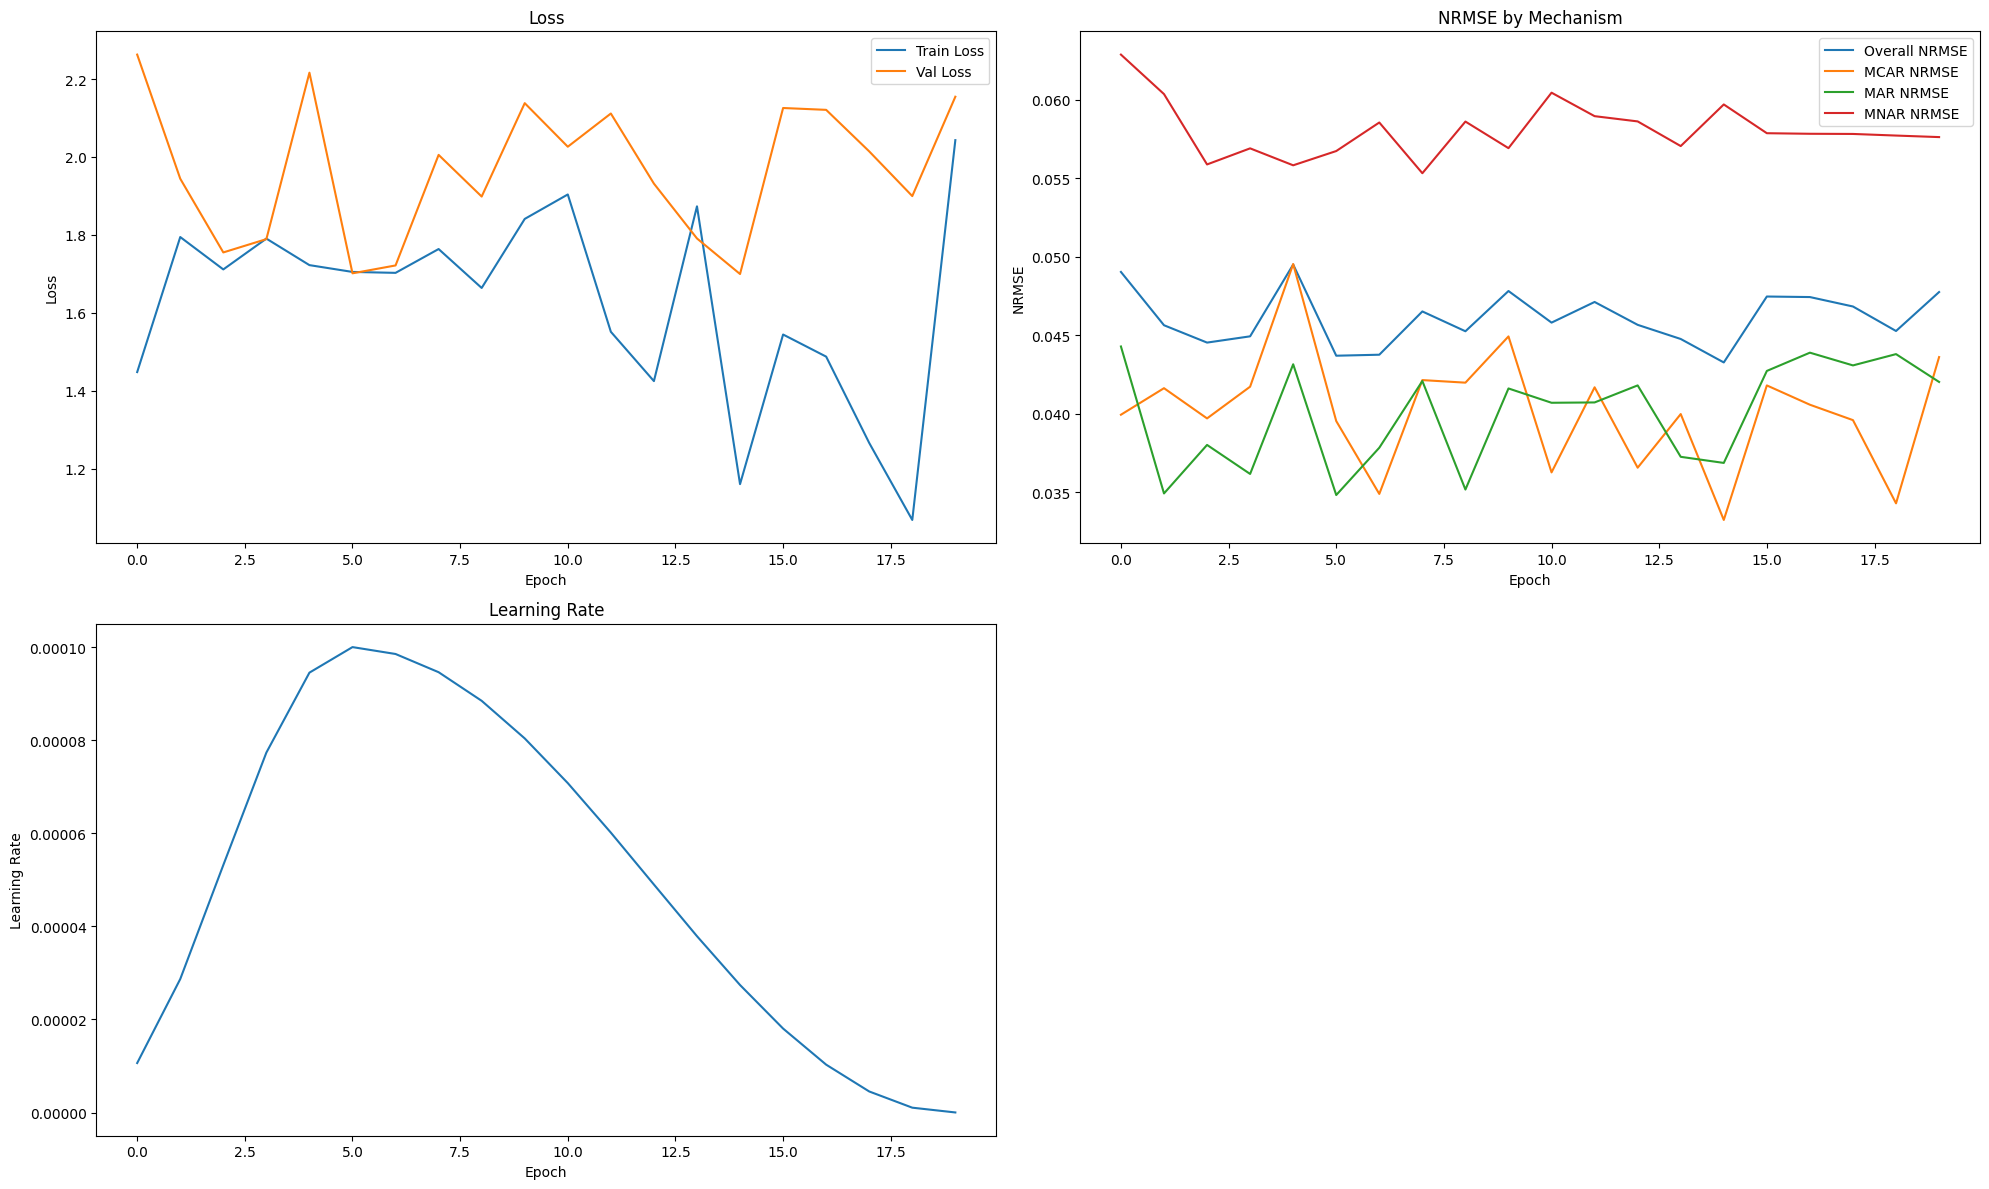


=== Evaluating on Test Set ===
Test metrics:
  Overall NRMSE: 0.0559
  MCAR NRMSE: 0.0509
  MAR NRMSE: 0.0490
  MNAR NRMSE: 0.0677

=== Saving Models ===
Training complete! All models and results saved in: models\2025-04-15_22-07-12_model-ensemble+5Fold


In [25]:
# Main execution code
if __name__ == "__main__":
    # Configuration
    config = {
        # Data parameters
        "data_path": "./data/physionet_39_features_only_no_leakage.csv",
        "test_size": 0.2,
        "val_size": 0.1,
        
        # Model parameters
        "d_model": 384,              
        "num_heads": 12,             
        "num_layers": 6,            
        "dim_feedforward": 1536,    
        "dropout": 0.15,             
        "activation": "gelu",
        
        # Training parameters
        "batch_size": 128,          
        "learning_rate": 0.0001,     
        "weight_decay": 0.005,       
        "num_epochs": 20,           
        "patience": 25,              
        "missing_fraction": 0.3,
        
        "warmup_steps_pct": 0.2,     # Shorter warmup phase
        "min_lr_factor": 5000.0,     # Slower final decay
        
        # Save parameters
        "save_dir": "models"
    }
    
    # Create directories with timestamp
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_dir = os.path.join(config["save_dir"], f"{current_time}_model-ensemble+5Fold")
    os.makedirs(save_dir, exist_ok=True)
    
    # Create experiment log file
    experiment_log = os.path.join(save_dir, "experiment_log.txt")
    with open(experiment_log, "w") as f:
        f.write(f"Experiment started at: {current_time}\n")
        f.write("Configuration:\n")
        for key, value in config.items():
            f.write(f"  {key}: {value}\n")
    
    # Load and prepare data
    train_data, val_data, test_data, scaler, column_indices = load_and_prepare_data(
        config["data_path"],
        config["test_size"],
        config["val_size"]
    )
    
    # Add flag to control whether to run k-fold validation
    RUN_KFOLD = True
    
    if RUN_KFOLD:
        print("\n=== Running K-Fold Cross-Validation ===")
        # Combine train and validation data for k-fold
        combined_data = torch.cat([train_data, val_data], dim=0)
        
        # Set a smaller number of epochs for k-fold to save time
        kfold_config = config.copy()
        kfold_config["num_epochs"] = 100  # Reduced epochs for k-fold
        
        # Run k-fold validation with single model
        print("\n---- K-Fold with Single Model ----")
        cv_metrics_single, _ = cross_validate_model(
            combined_data, 
            column_indices, 
            kfold_config, 
            n_folds=5,
            model_type="single"
        )
        
        # Run k-fold validation with ensemble model
        print("\n---- K-Fold with Ensemble Model ----")
        cv_metrics_ensemble, _ = cross_validate_model(
            combined_data, 
            column_indices, 
            kfold_config, 
            n_folds=3,  # Fewer folds for ensemble to save time
            model_type="ensemble"
        )
        
        # Save cross-validation results
        cv_results_path = os.path.join(save_dir, "cv_results.txt")
        with open(cv_results_path, "w") as f:
            f.write("Single Model Cross-Validation Results:\n")
            f.write(f"  NRMSE: {cv_metrics_single['nrmse']:.4f} ± {cv_metrics_single['nrmse_std']:.4f}\n")
            f.write(f"  MCAR NRMSE: {cv_metrics_single['mcar_nrmse']:.4f} ± {cv_metrics_single['mcar_nrmse_std']:.4f}\n")
            f.write(f"  MAR NRMSE: {cv_metrics_single['mar_nrmse']:.4f} ± {cv_metrics_single['mar_nrmse_std']:.4f}\n")
            f.write(f"  MNAR NRMSE: {cv_metrics_single['mnar_nrmse']:.4f} ± {cv_metrics_single['mnar_nrmse_std']:.4f}\n\n")
            
            f.write("Ensemble Model Cross-Validation Results:\n")
            f.write(f"  NRMSE: {cv_metrics_ensemble['nrmse']:.4f} ± {cv_metrics_ensemble['nrmse_std']:.4f}\n")
            f.write(f"  MCAR NRMSE: {cv_metrics_ensemble['mcar_nrmse']:.4f} ± {cv_metrics_ensemble['mcar_nrmse_std']:.4f}\n")
            f.write(f"  MAR NRMSE: {cv_metrics_ensemble['mar_nrmse']:.4f} ± {cv_metrics_ensemble['mar_nrmse_std']:.4f}\n")
            f.write(f"  MNAR NRMSE: {cv_metrics_ensemble['mnar_nrmse']:.4f} ± {cv_metrics_ensemble['mnar_nrmse_std']:.4f}\n")
    
    # Choose model type based on cross-validation results (if performed)
    if RUN_KFOLD and cv_metrics_ensemble['nrmse'] < cv_metrics_single['nrmse']:
        print("\nEnsemble model performed better in cross-validation. Using ensemble for final model.")
        final_model_type = "ensemble"
    else:
        print("\nUsing single model for final training.")
        final_model_type = "single"
    
    # Train final model on the entire training set
    print("\n=== Training Final Model ===")
    model, history = train_model(train_data, val_data, column_indices, config, model_type=final_model_type)
    
    # Plot training history
    plot_training_history(history, os.path.join(save_dir, "training_history.png"))
    

    # Evaluate on test set
    print("\n=== Evaluating on Test Set ===")
    test_dataloader = DataLoader(TensorDataset(test_data), batch_size=config["batch_size"])
    test_metrics = validate(model, test_dataloader, config["missing_fraction"], ["MCAR", "MAR", "MNAR"])
    
    print(f"Test metrics:")
    print(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}")
    print(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}")
    print(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}")
    print(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}")
    
    
    
    # Save test results
    test_results_path = os.path.join(save_dir, "test_results.txt")
    with open(test_results_path, "w") as f:
        f.write("Test Results:\n")
        f.write(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}\n")
        f.write(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}\n")
        f.write(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}\n")
        f.write(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}\n")
    
    # Save models
    print(f"\n=== Saving Models ===")
    
    # Save final model
    model_save_path = os.path.join(save_dir, "final_model.pth")
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config,
        "model_type": final_model_type
    }, model_save_path)
    
    # Save scaler
    scaler_path = os.path.join(save_dir, "scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    
    # Update experiment log
    with open(experiment_log, "a") as f:
        f.write("\nFinal Test Results:\n")
        f.write(f"  Overall NRMSE: {test_metrics['nrmse']:.4f}\n")
        f.write(f"  MCAR NRMSE: {test_metrics['mechanisms']['MCAR']['nrmse']:.4f}\n")
        f.write(f"  MAR NRMSE: {test_metrics['mechanisms']['MAR']['nrmse']:.4f}\n")
        f.write(f"  MNAR NRMSE: {test_metrics['mechanisms']['MNAR']['nrmse']:.4f}\n")
        
        f.write(f"\nExperiment completed at: {datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")

    print(f"Training complete! All models and results saved in: {save_dir}")



## Model testing

In [26]:
def evaluate_imputation_performance(model, test_data, column_indices, missing_percentages=[0.1, 0.2, 0.3, 0.4, 0.5], 
                                    mechanisms=["MCAR", "MAR", "MNAR"]):
    """
    Evaluate the model's imputation performance across different missing percentages and mechanisms.
    
    Args:
        model (nn.Module): Trained model
        test_data (torch.Tensor): Test data tensor
        column_indices (torch.Tensor): Column indices
        missing_percentages (list): List of missing data percentages to evaluate
        mechanisms (list): List of missing data mechanisms to evaluate
        
    Returns:
        pd.DataFrame: DataFrame with NRMSE results for each mechanism and percentage
    """
    model.eval()
    results = {}
    
    with torch.no_grad():
        for mechanism in mechanisms:
            mechanism_results = []
            
            for missing_pct in missing_percentages:
                batch_size = 128
                total_nrmse = 0
                num_batches = 0
                
                # Create DataLoader for test data
                test_dataloader = DataLoader(TensorDataset(test_data), batch_size=batch_size)
                
                for batch in tqdm(test_dataloader, desc=f"Evaluating {mechanism} at {missing_pct*100}%"):
                    x = batch[0].to(device)
                    
                    # Create a mask for missing values
                    mask = create_missing_mask(x, missing_pct, mechanism)
                    
                    # Create input with missing values set to 0
                    x_masked = x.clone()
                    x_masked[mask == 1] = 0
                    
                    # Forward pass
                    predictions = model(x_masked, column_indices, mask)
                    
                    # Compute NRMSE
                    nrmse = compute_nrmse(predictions, x, mask)
                    total_nrmse += nrmse
                    num_batches += 1
                
                avg_nrmse = total_nrmse / num_batches
                mechanism_results.append(avg_nrmse)
                print(f"{mechanism} at {missing_pct*100}% missing: NRMSE = {avg_nrmse:.4f}")
            
            results[mechanism] = mechanism_results
    
    # Create a DataFrame for visualization
    results_df = pd.DataFrame(results, index=[f"{int(pct*100)}%" for pct in missing_percentages])
    results_df.index.name = "Missing Percentage"
    
    return results_df

In [27]:
def visualize_imputation_performance(results_df, save_path=None):
    """
    Create visualizations for imputation performance.
    
    Args:
        results_df (pd.DataFrame): DataFrame with NRMSE results
        save_path (str, optional): Path to save the figures
    """
    # 1. Create a heatmap visualization
    plt.figure(figsize=(10, 6))
    
    # Create a heatmap with custom colormap (lower values = better = greener)
    sns.heatmap(results_df, annot=True, cmap="RdYlGn_r", fmt=".4f", 
                linewidths=.5, cbar_kws={'label': 'NRMSE (lower is better)'})
    
    plt.title("Imputation Performance (NRMSE) by Missing Mechanism and Percentage")
    plt.tight_layout()
    
    if save_path:
        heatmap_path = save_path.replace(".png", "_heatmap.png")
        plt.savefig(heatmap_path)
        print(f"Heatmap saved to {heatmap_path}")
    
    plt.show()
    
    # 2. Create a line plot
    plt.figure(figsize=(12, 6))
    
    # Convert index to numeric for plotting
    results_df_plot = results_df.copy()
    results_df_plot.index = [int(idx.replace("%", "")) for idx in results_df_plot.index]
    
    # Plot lines for each mechanism
    for column in results_df_plot.columns:
        plt.plot(results_df_plot.index, results_df_plot[column], marker='o', linewidth=2, label=column)
    
    plt.xlabel("Missing Percentage (%)")
    plt.ylabel("NRMSE (lower is better)")
    plt.title("Imputation Performance Across Missing Percentages")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(results_df_plot.index)
    
    if save_path:
        line_path = save_path.replace(".png", "_lineplot.png")
        plt.savefig(line_path)
        print(f"Line plot saved to {line_path}")
    
    plt.show()
    
    # 3. Create a bar chart comparison
    plt.figure(figsize=(12, 6))
    
    # Plot grouped bars
    bar_width = 0.25
    r = np.arange(len(results_df_plot.index))
    
    # Plot bars for each mechanism
    for i, column in enumerate(results_df_plot.columns):
        plt.bar(r + i*bar_width, results_df_plot[column], width=bar_width, label=column)
    
    # Add labels and legend
    plt.xlabel("Missing Percentage (%)")
    plt.ylabel("NRMSE (lower is better)")
    plt.title("Imputation Performance by Missing Mechanism and Percentage")
    plt.xticks(r + bar_width, results_df_plot.index)
    plt.legend()
    
    if save_path:
        bar_path = save_path.replace(".png", "_barchart.png")
        plt.savefig(bar_path)
        print(f"Bar chart saved to {bar_path}")
    
    plt.show()
    
    # 4. Create a table visualization
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('off')
    ax.axis('tight')
    
    # Create a table with colored cells based on values
    # First, normalize the data for coloring
    norm_data = results_df.copy()
    for col in norm_data.columns:
        max_val = norm_data[col].max()
        min_val = norm_data[col].min()
        if max_val > min_val:
            norm_data[col] = (norm_data[col] - min_val) / (max_val - min_val)
        else:
            norm_data[col] = 0
    
    # Create a table with cell colors
    cell_colors = plt.cm.RdYlGn_r(norm_data.values)
    table = ax.table(cellText=results_df.values.round(4), 
                    rowLabels=results_df.index,
                    colLabels=results_df.columns,
                    cellColours=cell_colors,
                    loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    
    plt.title("NRMSE Values by Missing Mechanism and Percentage", y=0.8)
    
    if save_path:
        table_path = save_path.replace(".png", "_table.png")
        plt.savefig(table_path, bbox_inches='tight')
        print(f"Table visualization saved to {table_path}")
    
    plt.show()
    
    return results_df


=== Evaluating Imputation Performance Across Missing Percentages ===


Evaluating MCAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 29.62it/s]


MCAR at 10.0% missing: NRMSE = 0.0553


Evaluating MCAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 30.35it/s]


MCAR at 20.0% missing: NRMSE = 0.0514


Evaluating MCAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 30.20it/s]


MCAR at 30.0% missing: NRMSE = 0.0497


Evaluating MCAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 30.88it/s]


MCAR at 40.0% missing: NRMSE = 0.0489


Evaluating MCAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 29.51it/s]


MCAR at 50.0% missing: NRMSE = 0.0523


Evaluating MAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 19.86it/s]


MAR at 10.0% missing: NRMSE = 0.0418


Evaluating MAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 19.88it/s]


MAR at 20.0% missing: NRMSE = 0.0567


Evaluating MAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 19.22it/s]


MAR at 30.0% missing: NRMSE = 0.0624


Evaluating MAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 18.70it/s]


MAR at 40.0% missing: NRMSE = 0.0559


Evaluating MAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 19.85it/s]


MAR at 50.0% missing: NRMSE = 0.0511


Evaluating MNAR at 10.0%: 100%|██████████| 4/4 [00:00<00:00, 19.27it/s]


MNAR at 10.0% missing: NRMSE = 0.0731


Evaluating MNAR at 20.0%: 100%|██████████| 4/4 [00:00<00:00, 19.13it/s]


MNAR at 20.0% missing: NRMSE = 0.0748


Evaluating MNAR at 30.0%: 100%|██████████| 4/4 [00:00<00:00, 20.16it/s]


MNAR at 30.0% missing: NRMSE = 0.0680


Evaluating MNAR at 40.0%: 100%|██████████| 4/4 [00:00<00:00, 20.19it/s]


MNAR at 40.0% missing: NRMSE = 0.0630


Evaluating MNAR at 50.0%: 100%|██████████| 4/4 [00:00<00:00, 19.88it/s]


MNAR at 50.0% missing: NRMSE = 0.0583
Raw imputation results saved to models\2025-04-15_22-07-12_model-ensemble+5Fold\imputation_performance\imputation_results.csv
Heatmap saved to models\2025-04-15_22-07-12_model-ensemble+5Fold\imputation_performance\imputation_performance_heatmap.png


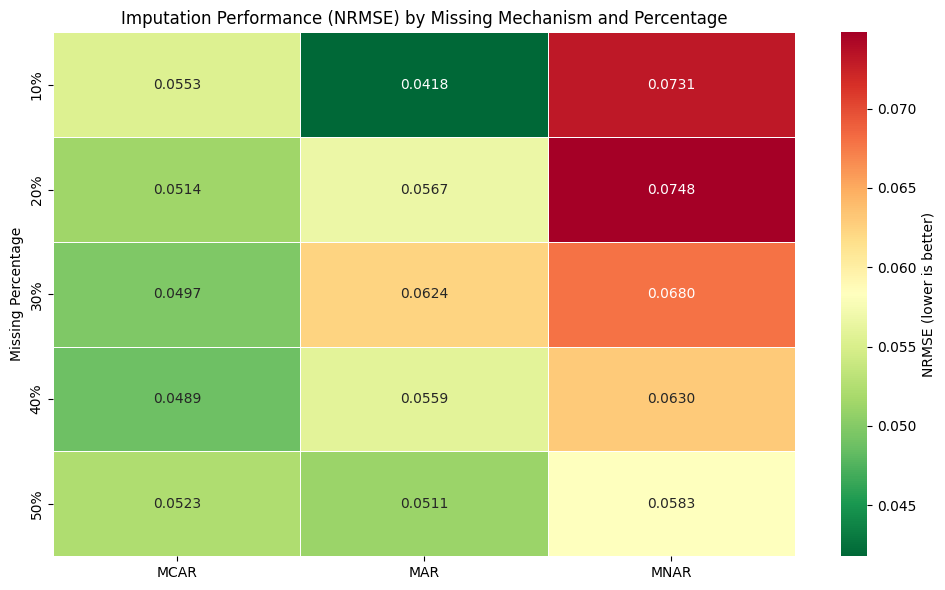

Line plot saved to models\2025-04-15_22-07-12_model-ensemble+5Fold\imputation_performance\imputation_performance_lineplot.png


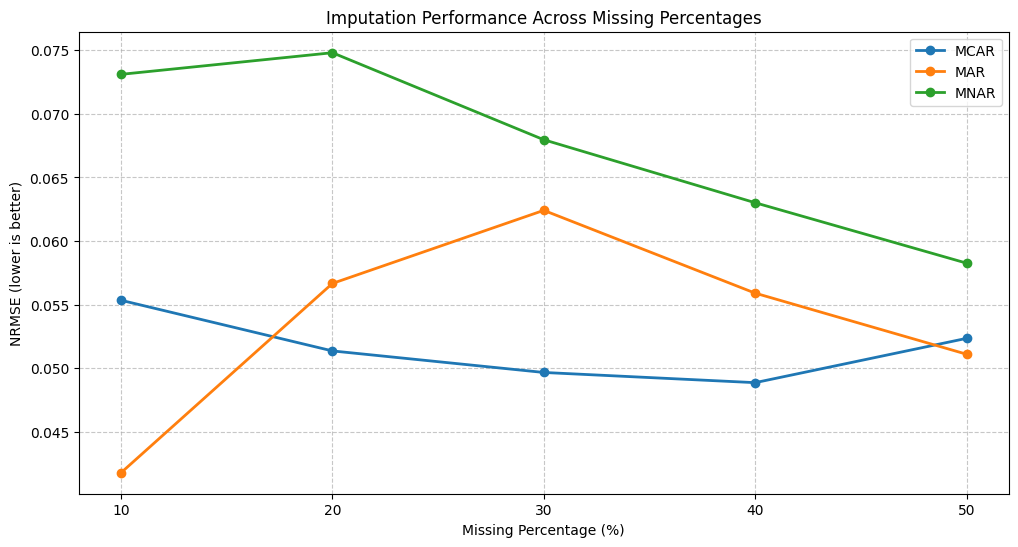

Bar chart saved to models\2025-04-15_22-07-12_model-ensemble+5Fold\imputation_performance\imputation_performance_barchart.png


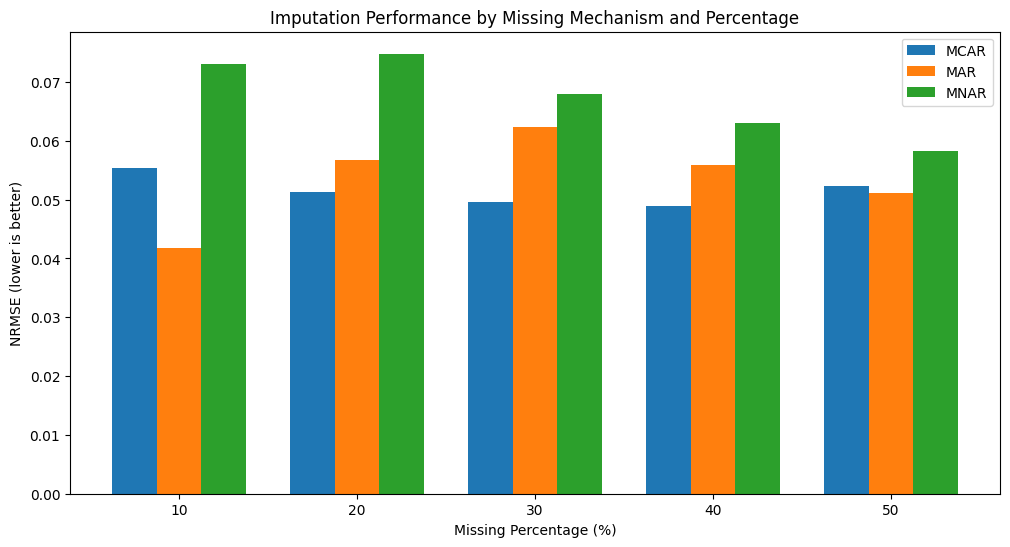

Table visualization saved to models\2025-04-15_22-07-12_model-ensemble+5Fold\imputation_performance\imputation_performance_table.png


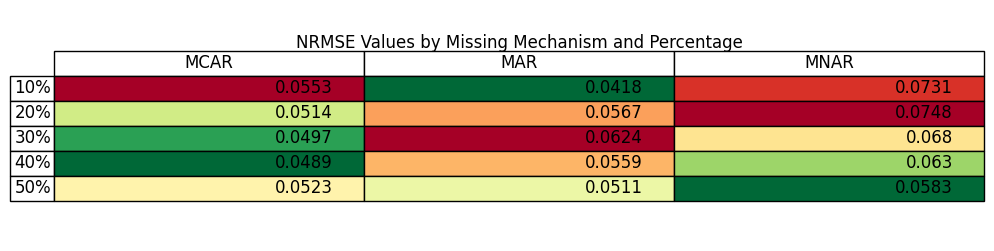


Imputation performance evaluation complete!


In [28]:
if __name__ == "__main__":
    # Create a section for imputation performance evaluation
    print("\n=== Evaluating Imputation Performance Across Missing Percentages ===")
    
    # Define the missing percentages to evaluate
    missing_percentages = [0.1, 0.2, 0.3, 0.4, 0.5]
    mechanisms = ["MCAR", "MAR", "MNAR"]
    
    # Create a directory for imputation performance visualizations
    imputation_dir = os.path.join(save_dir, "imputation_performance")
    os.makedirs(imputation_dir, exist_ok=True)
    
    # Evaluate imputation performance
    results_df = evaluate_imputation_performance(
        model,                    # Use the final trained model
        test_data,                # Test data
        column_indices,           # Column indices
        missing_percentages,      # Missing percentages
        mechanisms                # Missing mechanisms
    )
    
    # Save the raw results to CSV
    results_csv_path = os.path.join(imputation_dir, "imputation_results.csv")
    results_df.to_csv(results_csv_path)
    print(f"Raw imputation results saved to {results_csv_path}")
    
    # Create and save visualizations
    visualize_imputation_performance(
        results_df,
        save_path=os.path.join(imputation_dir, "imputation_performance.png")
    )
        
    print("\nImputation performance evaluation complete!")

## Impute the original dataset

In [29]:
def impute_original_dataset(trained_model, scaler, save_path="imputed_original.csv"):
    """
    Load the original CSV dataset, impute missing values using the pre-trained transformer model,
    and save the imputed dataset.
    
    Args:
        trained_model: The pre-trained imputation model
        scaler: The fitted scaler used during model training
        save_path: Path to save the imputed dataset
    """
    print("\n=== Imputing Original Dataset ===")
    
    # Set model to evaluation mode
    trained_model.eval()
    
    # File path
    original_file_path = "./data/physionet_39_features_only_no_leakage.csv"
    
    # Load the original dataset
    print(f"Loading original dataset from {original_file_path}...")
    df_original = pd.read_csv(original_file_path, index_col=None)
    print(f"Original dataset shape: {df_original.shape}")
    
    # Check for missing values
    missing_count = df_original.isna().sum().sum()
    missing_percentage = (missing_count / (df_original.shape[0] * df_original.shape[1])) * 100
    print(f"Dataset contains {missing_count} missing values ({missing_percentage:.2f}% of all values)")
    
    # Create a copy of the original dataset for imputation
    df_imputed = df_original.copy()
    
    # Extract numerical columns for imputation
    numerical_cols = df_original.select_dtypes(include=['number']).columns
    print(f"Found {len(numerical_cols)} numerical columns")
    
    # Create mask for missing values (True where values are missing)
    missing_mask = df_original[numerical_cols].isna()
    
    # Fill missing values with 0 for initial processing
    df_filled = df_original[numerical_cols].fillna(0)
    
    # Scale the data using the provided scaler
    data_scaled = scaler.transform(df_filled)
    
    # Convert to PyTorch tensor
    data_tensor = torch.tensor(data_scaled, dtype=torch.float32).to(device)
    
    # Create column indices tensor
    column_indices = torch.arange(data_tensor.shape[1]).to(device)
    
    # Create mask tensor (1 where values are missing, 0 otherwise)
    mask_tensor = torch.tensor(missing_mask.values, dtype=torch.int).to(device)
    
    print("Performing imputation with trained model...")
    
    with torch.no_grad():
        # Get predictions from the model
        imputed_tensor = trained_model(data_tensor, column_indices, mask_tensor)
        
        # Convert to numpy for processing
        imputed_np = imputed_tensor.cpu().numpy()
        
        # Inverse transform to original scale
        imputed_np = scaler.inverse_transform(imputed_np)
        
        # Create a DataFrame from the imputed values
        imputed_df = pd.DataFrame(imputed_np, columns=numerical_cols, index=df_original.index)
        
        # Replace missing values in the original dataframe with imputed values
        for col in numerical_cols:
            if col in df_imputed.columns:
                missing_idx = df_imputed[col].isna()
                df_imputed.loc[missing_idx, col] = imputed_df.loc[missing_idx, col]
    
    # Save the imputed dataset
    print(f"Saving imputed dataset to {save_path}...")
    df_imputed.to_csv(save_path)
    
    # Verification
    missing_after = df_imputed[numerical_cols].isna().sum().sum()
    print(f"Missing values in numerical columns after imputation: {missing_after}")
    
    total_missing_after = df_imputed.isna().sum().sum()
    if total_missing_after > 0:
        print(f"Total missing values after imputation: {total_missing_after}")
        print("Note: Non-numerical columns may still contain missing values")
    else:
        print("All missing values have been successfully imputed")
    
    print("Imputation complete!")
    
    return df_imputed

In [ ]:
# Execute the imputation process
if __name__ == "__main__":
    print("\n=== Running Imputation on Original Dataset ===")
    
    # Use the already trained model
    # Assuming 'model' and 'scaler' are the trained model and scaler from earlier in the notebook
    imputed_data = impute_original_dataset(model, scaler, "imputed_original.csv")
    
    # Display sample of the imputed data
    print("\nSample of imputed data:")
    print(imputed_data.head())


=== Running Imputation on Original Dataset ===

=== Imputing Original Dataset ===
Loading original dataset from ./data/physionet_39_features_only_no_leakage.csv...
Original dataset shape: (2008, 39)
Dataset contains 3063 missing values (3.91% of all values)
Found 39 numerical columns
Performing imputation with trained model...


c:\Users\wh1sper\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Saving imputed dataset to imputed_original.csv...
Missing values in numerical columns after imputation: 0
All missing values have been successfully imputed
Imputation complete!

Sample of imputed data:
   verbal.response  eye.opening  movement  GCS  lactate.dehydrogenase  \
0                5            4         6   15             294.000000   
1                5            4         6   15             203.000000   
2                5            4         6   15             137.000000   
3                5            4         6   15             348.338623   
4                5            4         6   15             295.000000   

   glutamic.oxaloacetic.transaminase  globulin  total.bilirubin  \
0                           81.00000      23.8             18.3   
1                           21.00000      25.4             18.3   
2                            9.00000      27.7             11.9   
3                          152.15744      27.0             51.6   
4                       

: 